In [1]:
# Import libraries and modules
import sys
import tensorflow as tf
import numpy as np
import seaborn as sns
import shutil
print(tf.__version__)
print(np.__version__)
np.set_printoptions(threshold=np.inf)

1.13.1
1.16.4


In [2]:
# tf.enable_eager_execution()
tf.executing_eagerly()

False

# Create data

## Create data generator

In [3]:
simple_data_gen = False

pct_seq_before_anom = 70.0
pct_seq_after_anom = 0.0


def create_time_series_norm_params(simple_data_gen):
  """Creates "normal" time series sine parameters.

  Returns multiple "normal" sequences.

  Args:
    simple_data_gen: Bool that determines if we are making simple data
      or more complex.

  Returns:
    np.array of shape = (num_seq, seq_len) of "normal" sequences.
  """
  norm_freq_scale = 1.0
  norm_freq_shift = 1.0

  norm_ampl_scale = 1.0
  norm_ampl_shift = 1.0

  norm_noise = 1.0

  if simple_data_gen:
    norm_freq = 1.0
    norm_ampl = 1.0
  else:
    norm_freq = np.random.random() * norm_freq_scale + norm_freq_shift
    norm_ampl = np.random.random() * norm_ampl_scale + norm_ampl_shift

  return {"norm_freq": norm_freq,
          "norm_ampl": norm_ampl,
          "norm_noise": norm_noise}


def create_time_series_normal(
    simple_data_gen,
    num_seq,
    seq_len,
    norm_freq,
    norm_ampl,
    norm_noise):
  """Creates normal time series data.

  Given the number of sequences to create, the sequence length, and "normal"
  parameters for sine, returns multiple "normal" sequences.

  Args:
    simple_data_gen: Bool that determines if we are making simple data
      or more complex.
    num_seq: Number of sequences we want to create.
    seq_len: Number of timesteps to create for each sequence.
    norm_freq: Sine frequency for "normal" sequences.
    norm_ampl: Sine amplitude for "normal" sequences.
    norm_noise: Noise level for "normal" sequences.

  Returns:
    np.array of shape = (num_seq, seq_len) of "normal" sequences
  """
  if simple_data_gen:
    sequence = np.stack(
        arrays=[np.sin(np.arange(seq_len) * norm_freq) * norm_ampl
                for _ in range(num_seq)],
        axis=0)
  else:
    sequence = np.stack(
        arrays=[np.sin(np.arange(seq_len) * norm_freq) * norm_ampl + \
                  [np.random.random() * norm_noise
                   for _ in range(seq_len)] for _ in range(num_seq)],
        axis=0)

  return sequence


def create_time_series_with_anomaly(
    simple_data_gen,
    num_seq,
    seq_len,
    pct_seq_before_anom,
    pct_seq_after_anom,
    norm_freq,
    norm_ampl,
    norm_noise):
  """Creates anomalous time series data.

  Given the number of sequences to create, the sequence length, and "normal"
  parameters for sine, returns multiple "normal" sequences.

  Args:
    simple_data_gen: Bool that determines if we are making simple data
      or more complex.
    num_seq: Number of sequences we want to create.
    seq_len: Number of timesteps to create for each sequence.
    pct_seq_before_anom: Percent of sequence that will be "normal" before
      anomaly section.
    pct_seq_after_anom: Percent of sequence that will be "normal" after
      anomaly section.
    norm_freq: Sine frequency for "normal" sequences.
    norm_ampl: Sine amplitude for "normal" sequences.
    norm_noise: Noise level for "normal" sequences.

  Returns:
    np.array of shape = (num_seq, seq_len) of "normal" sequences
  """
  seq_len_bf_anom = int(seq_len * pct_seq_before_anom / 100.0)
  seq_len_af_anom = int(seq_len * pct_seq_after_anom / 100.0)
  seq_len_anom = seq_len - seq_len_bf_anom - seq_len_af_anom

  # Extra anomalous parameters
  anom_ampl_multi_min = 8.0
  anom_ampl_multi_max = 20.0

  if simple_data_gen:
    sequence_with_anomaly = np.stack(
        arrays=[np.sin(np.arange(seq_len) * norm_freq) * norm_ampl
                for _ in range(num_seq)],
        axis=0)
  else:
    sequence_with_anomaly = create_time_series_normal(
        simple_data_gen, num_seq, seq_len, norm_freq, norm_ampl, norm_noise)

  sequence_with_anomaly[:, seq_len_bf_anom:seq_len_bf_anom + seq_len_anom] *= \
    ((anom_ampl_multi_max - anom_ampl_multi_min) * \
     np.random.random_sample([num_seq, seq_len_anom]) + anom_ampl_multi_min) * \
    (np.random.randint(2, size=[num_seq, seq_len_anom]) * -2 + 1)

  return sequence_with_anomaly

In [4]:
test_norm_params = create_time_series_norm_params(
    simple_data_gen=simple_data_gen)

/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


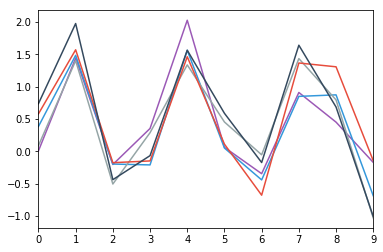

In [5]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i in range(0, 5):
  data = create_time_series_normal(
      simple_data_gen=simple_data_gen,
      num_seq=1,
      seq_len=10,
      norm_freq=test_norm_params["norm_freq"],
      norm_ampl=test_norm_params["norm_ampl"],
      norm_noise=test_norm_params["norm_noise"])

  sns.tsplot(data=data.reshape(-1), color=flatui[i%len(flatui)])

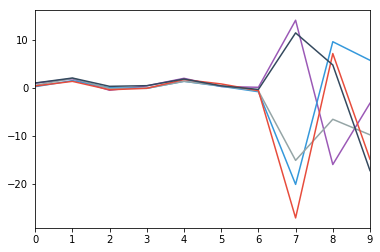

In [6]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i in range(0, 5):
  data = create_time_series_with_anomaly(
      simple_data_gen=simple_data_gen,
      num_seq=1,
      seq_len=10,
      pct_seq_before_anom=pct_seq_before_anom,
      pct_seq_after_anom=pct_seq_after_anom,
      norm_freq=test_norm_params["norm_freq"],
      norm_ampl=test_norm_params["norm_ampl"],
      norm_noise=test_norm_params["norm_noise"])

  sns.tsplot(data=data.reshape(-1), color=flatui[i%len(flatui)])

## Create training and evaluation data

In [7]:
num_train_norm_seq = 64000

num_val_norm_1_seq = 6400
num_val_norm_2_seq = 6400
num_val_anom_seq = 6400

num_test_norm_seq = 6400
num_test_anom_seq = 6400

seq_len = 30
num_tags = 5
tag_columns = ["tag_{0}".format(tag) for tag in range(0, num_tags)]

In [8]:
tag_data_list = [create_time_series_norm_params(
    simple_data_gen=simple_data_gen)
                 for tag in range(num_tags)]
print("tag_data_list = \n{}".format(tag_data_list))

tag_data_list = 
[{'norm_noise': 1.0, 'norm_ampl': 1.9281657901602325, 'norm_freq': 1.522478923631933}, {'norm_noise': 1.0, 'norm_ampl': 1.848539175940426, 'norm_freq': 1.3361444143088368}, {'norm_noise': 1.0, 'norm_ampl': 1.438327722951684, 'norm_freq': 1.4127534895254341}, {'norm_noise': 1.0, 'norm_ampl': 1.0729910167692451, 'norm_freq': 1.9380684122898564}, {'norm_noise': 1.0, 'norm_ampl': 1.8434709256315287, 'norm_freq': 1.1495975017794762}]


In [9]:
# Create training set using normal sequences
train_norm_seq_list = [create_time_series_normal(
    simple_data_gen=simple_data_gen,
    num_seq=num_train_norm_seq,
    seq_len=seq_len,
    norm_freq=tag["norm_freq"],
    norm_ampl=tag["norm_ampl"],
    norm_noise=tag["norm_noise"])
                       for tag in tag_data_list]

train_norm_seq_array = np.stack(
  arrays=[np.stack(
        arrays=[
            np.array2string(
                a=train_norm_seq_list[i][j], separator=";").replace("[", "").replace("]", "").replace(" ", "").replace("\n", "")
            for j in range(num_train_norm_seq)],
        axis=0)
          for i in range(num_tags)],
    axis=1)

np.random.shuffle(train_norm_seq_array)
print("train_norm_seq_array.shape = \n{}".format(train_norm_seq_array.shape))

train_norm_seq_array.shape = 
(64000, 5)


In [10]:
# Create validation sets

# Create set vn1 of normal sequences which will be used for early stopping
# during training as well as using the error vectors to learn mu and sigma
# for mahalanobis distance
val_norm_1_seq_list = [create_time_series_normal(
    simple_data_gen=simple_data_gen,
    num_seq=num_val_norm_1_seq,
    seq_len=seq_len,
    norm_freq=tag["norm_freq"],
    norm_ampl=tag["norm_ampl"],
    norm_noise=tag["norm_noise"])
                       for tag in tag_data_list]

val_norm_1_seq_array = np.stack(
    arrays=[np.stack(
        arrays=[
            np.array2string(
                a=val_norm_1_seq_list[i][j], separator=";").replace("[", "").replace("]", "").replace(" ", "").replace("\n", "")
            for j in range(num_val_norm_1_seq)],
        axis=0)
            for i in range(num_tags)],
    axis=1)
np.random.shuffle(val_norm_1_seq_array)
print("val_norm_1_seq_array.shape = \n{}".format(val_norm_1_seq_array.shape))

# Create set vn2 of normal sequences which will be used for tuning the
# anomaly thresholds
val_norm_2_seq_list = [create_time_series_normal(
    simple_data_gen=simple_data_gen,
    num_seq=num_val_norm_2_seq,
    seq_len=seq_len,
    norm_freq=tag["norm_freq"],
    norm_ampl=tag["norm_ampl"],
    norm_noise=tag["norm_noise"])
                       for tag in tag_data_list]

val_norm_2_seq_array = np.stack(
    arrays=[np.stack(
        arrays=[
            np.array2string(
                a=val_norm_2_seq_list[i][j], separator=";").replace("[", "").replace("]", "").replace(" ", "").replace("\n", "")
            for j in range(num_val_norm_2_seq)],
        axis=0)
            for i in range(num_tags)],
    axis=1)
np.random.shuffle(val_norm_2_seq_array)
print("val_norm_2_seq_array.shape = \n{}".format(val_norm_2_seq_array.shape))

# Create set va of anomalous sequences which will be used for tuning the
# anomaly thresholds
val_anom_seq_list = [create_time_series_with_anomaly(
    simple_data_gen=simple_data_gen,
    num_seq=num_val_anom_seq,
    seq_len=seq_len,
    pct_seq_before_anom=pct_seq_before_anom,
    pct_seq_after_anom=pct_seq_after_anom,
    norm_freq=tag["norm_freq"],
    norm_ampl=tag["norm_ampl"],
    norm_noise=tag["norm_noise"])
                       for tag in tag_data_list]

val_anom_seq_array = np.stack(
    arrays=[np.stack(
        arrays=[
            np.array2string(
                a=val_anom_seq_list[i][j], separator=";").replace("[", "").replace("]", "").replace(" ", "").replace("\n", "")
            for j in range(num_val_anom_seq)],
        axis=0)
            for i in range(num_tags)],
    axis=1)
np.random.shuffle(val_anom_seq_array)
print("val_anom_seq_array.shape = \n{}".format(val_anom_seq_array.shape))

val_norm_1_seq_array.shape = 
(6400, 5)
val_norm_2_seq_array.shape = 
(6400, 5)
val_anom_seq_array.shape = 
(6400, 5)


In [11]:
# Create test sets

# Create set tn of normal sequences which will be used for testing model
test_norm_seq_list = [create_time_series_normal(
    simple_data_gen=simple_data_gen,
    num_seq=num_test_norm_seq,
    seq_len=seq_len,
    norm_freq=tag["norm_freq"],
    norm_ampl=tag["norm_ampl"],
    norm_noise=tag["norm_noise"])
                       for tag in tag_data_list]

test_norm_seq_array = np.stack(
    arrays=[np.stack(
        arrays=[
            np.array2string(
                a=test_norm_seq_list[i][j], separator=";").replace("[", "").replace("]", "").replace(" ", "").replace("\n", "")
            for j in range(num_test_norm_seq)],
        axis=0)
            for i in range(num_tags)],
    axis=1)
np.random.shuffle(test_norm_seq_array)
print("test_norm_seq_array.shape = \n{}".format(test_norm_seq_array.shape))

# Create set ta of anomalous sequences which will be used for testing model
test_anom_seq_list = [create_time_series_with_anomaly(
    simple_data_gen=simple_data_gen,
    num_seq=num_test_anom_seq,
    seq_len=seq_len,
    pct_seq_before_anom=pct_seq_before_anom,
    pct_seq_after_anom=pct_seq_after_anom,
    norm_freq=tag["norm_freq"],
    norm_ampl=tag["norm_ampl"],
    norm_noise=tag["norm_noise"])
                      for tag in tag_data_list]

test_anom_seq_array = np.stack(
    arrays=[np.stack(
        arrays=[
            np.array2string(
                a=test_anom_seq_list[i][j], separator=";").replace("[", "").replace("]", "").replace(" ", "").replace("\n", "")
            for j in range(num_test_anom_seq)],
        axis=0)
            for i in range(num_tags)],
    axis=1)
np.random.shuffle(test_anom_seq_array)
print("test_anom_seq_array.shape = \n{}".format(test_anom_seq_array.shape))

test_norm_seq_array.shape = 
(6400, 5)
test_anom_seq_array.shape = 
(6400, 5)


In [12]:
# Combine vn2 and va sets for tuning anomaly thresholds
# Labeled
labeled_val_norm_2_seq_array = np.concatenate(
    seq=[val_norm_2_seq_array,
         np.zeros(shape=[val_norm_2_seq_array.shape[0], 1],
                  dtype=np.int64)],
    axis=1)

labeled_val_anom_seq_array = np.concatenate(
    seq=[val_anom_seq_array,
         np.ones(shape=[val_anom_seq_array.shape[0], 1],
                 dtype=np.int64)],
    axis=1)

labeled_val_mixed_seq_array = np.concatenate(
    seq=[labeled_val_norm_2_seq_array,
         labeled_val_anom_seq_array],
    axis=0)

np.random.shuffle(labeled_val_mixed_seq_array)
print("labeled_val_mixed_seq_array.shape = \n{}".format(
    labeled_val_mixed_seq_array.shape))

# Unlabeled
unlabeled_val_mixed_seq_array = np.concatenate(
    seq=[val_norm_2_seq_array,
         val_anom_seq_array],
    axis=0)

np.random.shuffle(unlabeled_val_mixed_seq_array)
print("unlabeled_val_mixed_seq_array.shape = \n{}".format(
    unlabeled_val_mixed_seq_array.shape))

# Combine tn and ta sets for testing model
# Labeled
labeled_test_norm_seq_array = np.concatenate(
    seq=[test_norm_seq_array,
         np.zeros(shape=[test_norm_seq_array.shape[0], 1],
                  dtype=np.int64)],
    axis=1)

labeled_test_anom_seq_array = np.concatenate(
    seq=[test_anom_seq_array,
         np.ones(shape=[test_anom_seq_array.shape[0], 1],
                 dtype=np.int64)],
    axis=1)

labeled_test_mixed_seq_array = np.concatenate(
    seq=[labeled_test_norm_seq_array,
         labeled_test_anom_seq_array],
    axis=0)

np.random.shuffle(labeled_test_mixed_seq_array)
print("labeled_test_mixed_seq_array.shape = \n{}".format(
    labeled_test_mixed_seq_array.shape))

# Unlabeled
unlabeled_test_mixed_seq_array = np.concatenate(
    seq=[test_norm_seq_array,
         test_anom_seq_array],
    axis=0)

np.random.shuffle(unlabeled_test_mixed_seq_array)
print("unlabeled_test_mixed_seq_array.shape = \n{}".format(
    unlabeled_test_mixed_seq_array.shape))

labeled_val_mixed_seq_array.shape = 
(12800, 6)
unlabeled_val_mixed_seq_array.shape = 
(12800, 5)
labeled_test_mixed_seq_array.shape = 
(12800, 6)
unlabeled_test_mixed_seq_array.shape = 
(12800, 5)


In [13]:
# Now save out the errays to csv files
np.savetxt(
    fname="data/train_norm_seq.csv",
    X=train_norm_seq_array,
    fmt="%s",
    delimiter=",")

np.savetxt(
    fname="data/val_norm_1_seq.csv",
    X=val_norm_1_seq_array,
    fmt="%s",
    delimiter=",")

np.savetxt(
    fname="data/labeled_val_mixed_seq.csv",
    X=labeled_val_mixed_seq_array,
    fmt="%s",
    delimiter=",")

np.savetxt(
    fname="data/unlabeled_val_mixed_seq.csv",
    X=unlabeled_val_mixed_seq_array,
    fmt="%s",
    delimiter=",")

np.savetxt(
    fname="data/labeled_test_mixed_seq.csv",
    X=labeled_test_mixed_seq_array,
    fmt="%s",
    delimiter=",")

np.savetxt(
    fname="data/unlabeled_test_mixed_seq.csv",
    X=unlabeled_test_mixed_seq_array,
    fmt="%s",
    delimiter=",")

In [14]:
!head -3 data/train_norm_seq.csv

0.3022643;1.97741574;0.38066236;-1.50524036;0.03398575;2.86387408;0.82932733;-1.66266919;-0.30088448;1.83663827;1.70331202;-0.7977396;-0.07725102;1.62403069;1.68445044;-0.72749672;-0.54088439;1.53208518;1.70428402;-0.43001789;-0.78420005;1.80720923;2.33382062;0.09766335;-1.08957973;1.49531316;2.44820779;0.37995274;-1.56186047;0.4624977,0.80775108;1.92516898;1.04338343;-1.18606867;-1.29619049;0.83471436;2.18648646;0.36174395;-1.17189871;-0.34432044;1.78657379;1.60821403;-0.23485116;-0.84391421;0.40830408;1.84592228;1.24189034;-0.63605423;-1.18576172;1.22239184;2.5515058;1.31717207;-0.90679716;-0.57889382;1.89375664;2.07447679;0.17685387;-1.34475346;-0.30079106;2.05690318,0.10360912;1.75866143;0.64030032;-0.95984526;-0.03331013;1.49000045;1.21406383;-0.38671276;-1.03908207;0.64524375;2.04170946;0.26432184;-0.58799729;0.21737775;1.67390694;1.68405018;-0.03228011;-1.15875351;0.47655221;1.77170688;0.04403952;-0.92184037;0.25679826;1.66788979;1.71996546;-0.08309814;-1.00446831;1.25783949;1.9

In [15]:
!head -3 data/val_norm_1_seq.csv

0.06291295;2.71548288;0.87626983;-1.19140039;0.25018395;2.03753108;0.62163365;-1.09652187;0.17463795;1.75435652;0.94195048;-0.70546983;-0.95329836;1.66985154;1.87606722;-1.22469154;-0.42922341;2.07042872;1.58834255;-0.83304065;-0.92249714;1.76867717;1.7626847;-0.73332969;-0.97852344;1.25718525;2.45930821;0.13662622;-1.00310473;1.20912671,0.34541279;2.07792462;1.57798741;-0.77999459;-1.16303979;1.63228064;2.40564196;1.06140524;-1.39961115;-0.63789475;2.07121551;2.14897527;-0.47085746;-1.36826862;0.53846211;2.39344195;1.3673265;-0.51734956;-0.901496;0.95496;2.14108996;1.23467064;-0.72785641;-0.24851427;2.01725256;2.68001093;-0.21223795;-1.33466688;-0.30973441;2.12115207,0.25437633;1.73807147;0.46440636;-0.69544318;-0.55893622;1.153598;1.89168914;0.19287571;-1.27936749;0.82890319;1.64913854;1.22775809;-1.3305177;-0.03158416;1.53196291;1.63888235;-0.48198591;-0.87786421;0.65696015;1.71282196;0.2951191;-0.92983897;-0.40499592;1.49448942;0.87909154;-0.85818273;-1.15455786;0.67928905;1.959034

In [16]:
!head -3 data/labeled_val_mixed_seq.csv

0.36538387;2.87904188;0.78538932;-1.48863723;0.22470137;2.25999073;0.73740157;-1.55615568;-0.35997603;2.59820426;1.66992924;-0.68580065;-0.95250251;1.63113332;1.70053223;-1.29359908;-0.68974819;1.95711898;1.65158459;-0.3959467;-1.00743804;-28.21307963;-22.54614801;-1.72136902;-22.10617028;-11.97295264;38.87270208;-5.89986972;21.21338902;-4.1166863,0.35761259;2.06898201;1.43395081;-0.41504438;-1.01690525;1.55265669;2.69510891;0.23422726;-1.67723693;-0.60654454;1.48683565;1.70861067;-0.06142698;-1.00121184;-0.14752923;2.61871821;1.66327897;-0.86008645;-0.89531639;0.81957888;2.60597264;13.6722319;-11.71524178;10.13719366;12.37154846;31.31654387;2.69046333;13.42415719;3.43490216;39.71377467,0.5313422;2.0767803;1.39540675;-0.5235833;-0.72081401;1.91271945;1.88011061;-0.14954812;-1.28838928;1.11629057;1.99222528;1.15773105;-0.70212163;0.06286698;1.95947011;1.15559086;0.0407887;-0.33580604;1.02871965;1.66618503;0.56320882;-16.91356527;0.85782939;-29.30288328;-13.59202806;-14.19718567;10.00688

In [17]:
!head -3 data/unlabeled_val_mixed_seq.csv

0.10633131;2.35890751;0.21516641;-1.48749764;-0.33182135;2.76380912;0.76172598;-1.64222243;0.03972318;2.01389863;1.12575525;-1.35875099;-0.32260898;2.33101581;1.70756295;-0.76480232;-1.32256585;2.05513708;1.60825475;-0.49906715;-0.71572314;-20.43073877;-26.73536878;-13.21220398;11.88709738;12.12825952;-16.14151929;-4.44636077;-13.60742667;-8.77741208,9.38762417e-01;2.30372454e+00;1.19213824e+00;-1.40584522e+00;-1.19225511e+00;1.02172179e+00;2.40637359e+00;8.85761949e-01;-1.44288715e+00;-9.37138452e-02;1.49464188e+00;2.37185618e+00;2.20479138e-01;-1.63577451e+00;2.76114695e-03;1.88053771e+00;1.84829242e+00;-9.79075005e-01;-9.65204952e-01;1.16391968e+00;2.68742436e+00;6.56511251e+00;1.86428909e+01;3.72752503e+00;2.50344841e+01;-2.09187849e+01;6.37680923e+00;-9.67410952e+00;8.94896009e+00;-3.01818271e+01,0.59941717;1.58018002;0.891199;-0.85600955;-0.40297109;1.80832898;1.98369483;-0.44282638;-0.57535146;1.12737548;1.85002539;0.94217696;-0.9478323;-0.66152416;1.99606653;1.39923995;-0.14811

In [18]:
!head -3 data/labeled_test_mixed_seq.csv

0.09318005;1.92966839;0.64609906;-1.43418066;0.61212887;2.71039485;1.06367445;-1.10791137;-0.39784441;2.43140035;1.82229656;-1.57219159;-0.07574367;1.88876193;2.14605622;-0.87162418;-1.33054281;2.02344086;2.13922109;-0.44283513;-0.65562326;1.33798303;2.62805909;-0.07076718;-1.29910869;0.98173276;1.99986846;0.42238945;-1.71468468;0.91111554,0.51019374;1.8246647;1.68057444;-0.50818155;-1.19217653;1.37695004;2.59170695;0.35729793;-1.50084934;-0.16332889;1.62237821;1.70763214;-0.52862107;-1.00701877;0.41601169;2.70971923;1.24609059;-1.06182853;-1.35081991;1.33314209;2.22443154;0.56238466;-1.08014025;-0.20057689;1.63070457;1.96626031;0.52362759;-1.17738411;-0.30667785;2.33046763,0.70514017;1.87180165;1.40706487;-0.4040482;-0.4405024;1.7841877;1.33337458;0.08392378;-0.48805024;0.48013054;1.56736799;0.24461322;-1.27466362;-0.03692955;1.90224685;1.63210455;-0.54175341;-0.78912984;0.53334307;1.62459812;0.06206091;-1.34397159;-0.44983121;2.08434339;1.27233575;-0.79436886;-0.3002077;1.48594887;1.

In [19]:
!head -3 data/unlabeled_test_mixed_seq.csv

0.83861721;1.99823299;0.98423548;-1.84282336;0.42974863;2.29073027;1.1188934;-1.05186854;-0.58851592;2.48330505;1.25082;-1.48089799;-0.24273682;2.55303002;1.26559778;-1.21403872;-0.9517369;1.74262891;2.22238201;-0.92383485;-1.47574902;1.20534335;2.26636366;-0.04995114;-0.93674628;1.371989;1.98042189;0.20818436;-1.42340607;0.59488468,0.48503988;2.42965796;0.9327926;-0.4136638;-1.01223952;0.71928205;2.65365194;0.60401179;-0.80588773;-0.68824828;1.34036131;2.03758519;0.3059226;-1.40246316;-0.0345257;2.12661406;1.68230132;-0.22649953;-0.99394658;0.74087737;2.20351241;0.66621681;-0.89917979;-0.52148618;1.82835468;1.80670843;0.44879286;-1.39864147;0.39890359;1.68735066,0.08519913;1.43318307;1.10148748;-1.25010978;-0.37692848;1.02965298;1.99770713;0.27480346;-0.45087998;0.76539017;1.49941421;0.69847887;-1.23193202;-0.54937379;1.2760564;1.19704164;-0.06962987;-0.98818571;1.36230535;2.33606584;1.01888233;-1.19800273;-0.0664862;2.22696862;1.38547935;-0.18586824;-0.73459922;1.02661271;2.06164477;

# Local Development

## input.py

In [38]:
# Input function functions
def split_and_convert_string(string_tensor):
  """Splits and converts string tensor into dense float tensor.

  Given string tensor, splits string by delimiter, converts to and returns
  dense float tensor.

  Args:
    string_tensor: tf.string tensor.

  Returns:
    tf.float64 tensor split along delimiter.
  """
  # Split string tensor into a sparse tensor based on delimiter
  split_string = tf.string_split(source=tf.expand_dims(
      input=string_tensor, axis=0), delimiter=";")

  # Converts the values of the sparse tensor to floats
  converted_tensor = tf.string_to_number(
      string_tensor=split_string.values,
      out_type=tf.float64)

  # Create a new sparse tensor with the new converted values,
  # because the original sparse tensor values are immutable
  new_sparse_tensor = tf.SparseTensor(
      indices=split_string.indices,
      values=converted_tensor,
      dense_shape=split_string.dense_shape)

  # Create a dense tensor of the float values that were converted from text csv
  dense_floats = tf.sparse_tensor_to_dense(
      sp_input=new_sparse_tensor, default_value=0.0)

  dense_floats_vector = tf.squeeze(input=dense_floats, axis=0)

  return dense_floats_vector


def convert_sequences_from_strings_to_floats(features, column_list, seq_len):
  """Converts sequences from single strings to a sequence of floats.

  Given features dictionary and feature column names list, convert features
  from strings to a sequence of floats.

  Args:
    features: Dictionary of tensors of our features as tf.strings.
    column_list: List of column names of our features.
    seq_len: Number of timesteps in sequence.

  Returns:
    Dictionary of tensors of our features as tf.float64s.
  """
  for column in column_list:
    features[column] = split_and_convert_string(features[column])
    # Since we know the sequence length, set the shape to remove the ambiguity
    features[column].set_shape([seq_len])

  return features


def decode_csv(value_column, mode, batch_size, params):
  """Decodes CSV file into tensors.

  Given single string tensor, sequence length, and number of features,
  returns features dictionary of tensors and labels tensor.

  Args:
    value_column: tf.string tensor of shape () compromising entire line of
      CSV file.
    mode: The estimator ModeKeys. Can be TRAIN or EVAL.
    batch_size: Number of examples per batch.
    params: Dictionary of user passed parameters.

  Returns:
    Features dictionary of tensors and labels tensor.
  """
  if (mode == tf.estimator.ModeKeys.TRAIN or
      (mode == tf.estimator.ModeKeys.EVAL and
       (params["training_mode"] != "tune_anomaly_thresholds" or
        (params["training_mode"] == "tune_anomaly_thresholds" and
         not params["labeled_tune_thresh"])))):
    # For subset of CSV files that do NOT have labels
    columns = tf.decode_csv(
        records=value_column,
        record_defaults=params["feat_defaults"],
        field_delim=",")

    features = dict(zip(params["feat_names"], columns))
    features = convert_sequences_from_strings_to_floats(
        features=features,
        column_list=params["feat_names"],
        seq_len=params["seq_len"])

    return features
  else:
    # For subset of CSV files that DO have labels
    columns = tf.decode_csv(
        records=value_column,
        record_defaults=params["feat_defaults"] + [[0.0]],  # add label default
        field_delim=",")

    features = dict(zip(params["feat_names"] + ["anomalous_sequence_flag"], columns))

    labels = tf.cast(x=features.pop("anomalous_sequence_flag"), dtype=tf.float64)

    features = convert_sequences_from_strings_to_floats(
        features=features,
        column_list=params["feat_names"],
        seq_len=params["seq_len"])

    return features, labels


def read_dataset(filename, mode, batch_size, params):
  """Reads CSV time series dataset using tf.data, doing necessary preprocessing.

  Given filename, mode, batch size and other parameters, read CSV dataset using
  Dataset API, apply necessary preprocessing, and return an input function to
  the Estimator API.

  Args:
    filename: The file pattern that we want to read into our tf.data dataset.
    mode: The estimator ModeKeys. Can be TRAIN or EVAL.
    batch_size: Number of examples per batch.
    params: Dictionary of user passed parameters.

  Returns:
    An input function.
  """
  def _input_fn():
    """Wrapper input function to be used by Estimator API to get data tensors.

    Returns:
      Batched dataset object of dictionary of feature tensors and label tensor.
    """

    # Create list of files that match pattern
    file_list = tf.gfile.Glob(filename=filename)

    # Create dataset from file list
    dataset = tf.data.TextLineDataset(filenames=file_list)  # Read text file

    # Decode the CSV file into a features dictionary of tensors
    dataset = dataset.map(
        map_func=lambda x: decode_csv(
            value_column=x, mode=mode, batch_size=batch_size, params=params))

    # Determine amount of times to repeat file if we are training or evaluating
    if mode == tf.estimator.ModeKeys.TRAIN:
      num_epochs = None  # indefinitely
    else:
      num_epochs = 1  # end-of-input after this

    # Repeat files num_epoch times
    dataset = dataset.repeat(count=num_epochs)

    # Group the data into batches
    dataset = dataset.batch(batch_size=batch_size)

    # Determine if we should shuffle based on if we are training or evaluating
    if mode == tf.estimator.ModeKeys.TRAIN:
      dataset = dataset.shuffle(buffer_size=10 * batch_size)

    # Create a iterator, then pull batch of features from the example queue
    batched_dataset = dataset.make_one_shot_iterator().get_next()

    return batched_dataset

  return _input_fn

In [39]:
def try_out_input_function():
  """Trys out input function for testing purposes."""
  filename = "data/labeled_val_mixed_seq.csv"
  training_mode = "tune_anomaly_thresholds"
  labeled_tune_thresh = True
  with tf.Session() as sess:
    fn = read_dataset(
        filename=filename,
        mode=tf.estimator.ModeKeys.EVAL,
        batch_size=8,
        params={
            "seq_len": seq_len,
            "training_mode": training_mode,
            "labeled_tune_thresh": labeled_tune_thresh})

    if training_mode == "tune_anomaly_thresholds" and labeled_tune_thresh:
      features, labels = sess.run(fn())
      print("features[tag_0].shape = {}".format(features["tag_0"].shape))
      print("labels.shape = {}".format(labels.shape))
      print("features = \n{}".format(features))
      print("labels = \n{}".format(labels))
    else:
      features = sess.run(fn())
      print("features[tag_0].shape = {}".format(features["tag_0"].shape))
      print("features = \n{}".format(features))

  return

In [40]:
# try_out_input_function()

## autoencoder_dense.py

In [41]:
# Dense autoencoder model functions
def dense_encoder(X, params):
  """Dense model encoder subgraph that produces latent matrix.

  Given data matrix tensor X and dictionary of parameters, process through dense
  model encoder subgraph and return encoder latent vector for each example in
  batch.

  Args:
    X: tf.float64 matrix tensor of input data.
    params: Dictionary of parameters.

  Returns:
    tf.float64 matrix tensor encoder latent vector for each example in batch.
  """
  # Create the input layer to our DNN
  network = X

  # Add hidden layers with the given number of units/neurons per layer
  for units in params["enc_dnn_hidden_units"]:
    network = tf.layers.dense(
        inputs=network,
        units=units,
        activation=tf.nn.relu)

  latent_matrix = tf.layers.dense(
      inputs=network,
      units=params["latent_vector_size"],
      activation=tf.nn.relu)

  return latent_matrix


def dense_decoder(latent_matrix, orig_dims, params):
  """Dense model decoder subgraph that produces output matrix.

  Given encoder latent matrix tensor, the original dimensions of the input, and
  dictionary of parameters, process through dense model decoder subgraph and
  return decoder output matrix.

  Args:
    latent_matrix: tf.float64 matrix tensor of encoder latent matrix.
    orig_dims: Original dimensions of input data.
    params: Dictionary of parameters.

  Returns:
    tf.float64 matrix tensor decoder output vector for each example in batch.
  """
  # Create the input layer to our DNN
  network = latent_matrix

  # Add hidden layers with the given number of units/neurons per layer
  for units in params["dec_dnn_hidden_units"][::-1]:
    network = tf.layers.dense(
        inputs=network,
        units=units,
        activation=tf.nn.relu)

  output_matrix = tf.layers.dense(
      inputs=network,
      units=orig_dims,
      activation=tf.nn.relu)

  return output_matrix


def dense_autoencoder(X, orig_dims, params):
  """Dense model autoencoder using dense encoder and decoder networks.

  Given data matrix tensor X, the original dimensions of the input, and
  dictionary of parameters, process through dense model encoder and decoder
  subgraphs and return reconstructed inputs as output.

  Args:
    X: tf.float64 matrix tensor of input data.
    orig_dims: Original dimensions of input data.
    params: Dictionary of parameters.

  Returns:
    tf.float64 matrix tensor decoder output vector for each example in batch
    that is the reconstructed inputs.
  """
  latent_matrix = dense_encoder(X, params)
  output_matrix = dense_decoder(latent_matrix, orig_dims, params)

  return output_matrix


def dense_autoencoder_model(
    X, mode, params, cur_batch_size, dummy_var):
  """Dense autoencoder to reconstruct inputs and minimize reconstruction error.

  Given data matrix tensor X, the current Estimator mode, the dictionary of
  parameters, and the current batch size, process through dense model encoder
  and decoder subgraphs and return reconstructed inputs as output.

  Args:
    X: tf.float64 matrix tensor of input data.
    mode: Estimator ModeKeys. Can take values of TRAIN, EVAL, and PREDICT.
    params: Dictionary of parameters.
    cur_batch_size: Current batch size, could be partially filled.
    dummy_var: Dummy variable used to allow training mode to happen since it
      requires a gradient to tie back to the graph dependency.

  Returns:
    loss: Reconstruction loss.
    train_op: Train operation so that Estimator can correctly add to dependency
      graph.
    X_time: 2D tensor representation of time major input data.
    X_time_recon: 2D tensor representation of time major input data.
    X_feat: 2D tensor representation of feature major input data.
    X_feat_recon: 2D tensor representation of feature major input data.
  """
  # Reshape into 2-D tensors
  # Time based
  # shape = (cur_batch_size * seq_len, num_feat)
  X_time = tf.reshape(
      tensor=X,
      shape=[cur_batch_size * params["seq_len"], params["num_feat"]])

  # shape = (cur_batch_size * seq_len, num_feat)
  X_time_recon = dense_autoencoder(X_time, params["num_feat"], params)

  # Features based
  # shape = (cur_batch_size, num_feat, seq_len)
  X_transposed = tf.transpose(a=X, perm=[0, 2, 1])

  # shape = (cur_batch_size * num_feat, seq_len)
  X_feat = tf.reshape(
      tensor=X_transposed,
      shape=[cur_batch_size * params["num_feat"], params["seq_len"]])

  # shape = (cur_batch_size * num_feat, seq_len)
  X_feat_recon = dense_autoencoder(X_feat, params["seq_len"], params)

  if (mode == tf.estimator.ModeKeys.TRAIN and
      params["training_mode"] == "reconstruction"):
    X_time_recon_3d = tf.reshape(
        tensor=X_time_recon,
        shape=[cur_batch_size, params["seq_len"], params["num_feat"]])
    X_feat_recon_3d = tf.transpose(
        a=tf.reshape(
            tensor=X_feat_recon,
            shape=[cur_batch_size, params["num_feat"], params["seq_len"]]),
        perm=[0, 2, 1])

    X_time_recon_3d_weighted = X_time_recon_3d * params["time_loss_weight"]
    X_feat_recon_3d_weighted = X_feat_recon_3d * params["feat_loss_weight"]

    predictions = (X_time_recon_3d_weighted + X_feat_recon_3d_weighted) \
      / (params["time_loss_weight"] + params["feat_loss_weight"])

    loss = tf.losses.mean_squared_error(labels=X, predictions=predictions)

    train_op = tf.contrib.layers.optimize_loss(
        loss=loss,
        global_step=tf.train.get_global_step(),
        learning_rate=params["learning_rate"],
        optimizer="Adam")

    return loss, train_op, None, None, None, None
  else:
    return None, None, X_time, X_time_recon, X_feat, X_feat_recon

## autoencoder_lstm.py

In [42]:
# LSTM Encoder-decoder Autoencoder model functions
def create_LSTM_stack(lstm_hidden_units, lstm_dropout_output_keep_probs):
  """Create LSTM stacked cells.

  Given list of LSTM hidden units and list of LSTM dropout output keep
  probabilities.

  Args:
    lstm_hidden_units: List of integers for the number of hidden units in each
      layer.
    lstm_dropout_output_keep_probs: List of floats for the dropout output keep
      probabilities for each layer.

  Returns:
    MultiRNNCell object of stacked LSTM layers.
  """
  # First create a list of LSTM cell objects using our list of lstm hidden
  # unit sizes
  lstm_cells = [tf.contrib.rnn.BasicLSTMCell(
      num_units=units,
      forget_bias=1.0,
      state_is_tuple=True)
                for units in lstm_hidden_units]

  # Next apply a dropout wrapper to our stack of LSTM cells,
  # in this case just on the outputs
  dropout_lstm_cells = [tf.nn.rnn_cell.DropoutWrapper(
      cell=lstm_cells[cell_index],
      input_keep_prob=1.0,
      output_keep_prob=lstm_dropout_output_keep_probs[cell_index],
      state_keep_prob=1.0)
                        for cell_index in range(len(lstm_cells))]

  # Create a stack of layers of LSTM cells
  # Combines list into MultiRNNCell object
  stacked_lstm_cells = tf.contrib.rnn.MultiRNNCell(
      cells=dropout_lstm_cells,
      state_is_tuple=True)

  return stacked_lstm_cells


# The rnn_decoder function takes labels during TRAIN/EVAL
# and a start token followed by its previous predictions during PREDICT
# Starts with an initial state of the final encoder states
def rnn_decoder(dec_input, init_state, cell, infer, dnn_hidden_units, num_feat):
  """Decoder for RNN cell.

  Given list of LSTM hidden units and list of LSTM dropout output keep
  probabilities.

  Args:
    dec_input: List of tf.float64 current batch size by number of features
      matrix tensors input to the decoder.
    init_state: Initial state of the decoder cell. Final state from the
      encoder cell.
    cell: RNN Cell object.
    infer: Boolean whether in inference mode or not.
    dnn_hidden_units: Python list of integers of number of units per DNN layer.
    num_feat: Python integer of the number of features.

  Returns:
    outputs: List of decoder outputs of length number of timesteps of tf.float64
      current batch size by number of features matrix tensors.
    state: Final cell state of the decoder.
  """
  # Create the decoder variable scope
  with tf.variable_scope("decoder"):
    # Load in our initial state from our encoder
    # Tuple of final encoder c_state and h_state of final encoder layer
    state = init_state

    # Create an empty list to store our hidden state output for every timestep
    outputs = []

    # Begin with no previous output
    previous_output = None

    # Loop over all of our dec_input which will be seq_len long
    for index, decoder_input in enumerate(dec_input):
      # If there has been a previous output, we will determine the next input
      if previous_output is not None:
        # Create the input layer to our DNN
        # shape = (cur_batch_size, lstm_hidden_units[-1])
        network = previous_output

        # Create our dnn variable scope
        with tf.variable_scope(name_or_scope="dnn", reuse=tf.AUTO_REUSE):
          # Add hidden layers with the given number of units/neurons per layer
          # shape = (cur_batch_size, dnn_hidden_units[i])
          for units in dnn_hidden_units:
            network = tf.layers.dense(
                inputs=network,
                units=units,
                activation=tf.nn.relu)

          # Connect final hidden layer to linear layer to get the logits
          # shape = (cur_batch_size, num_feat)
          logits = tf.layers.dense(
              inputs=network,
              units=num_feat,
              activation=None)

        # If we are in inference then we will overwrite our next decoder_input
        # with the logits we just calculated. Otherwise, we leave the decoder
        # input input as it was from the enumerated list. We have to calculate
        # the logits even when not using them so that the correct DNN subgraph
        # will be generated here and after the encoder-decoder for both
        # training and inference
        if infer:
          # shape = (cur_batch_size, num_feat)
          decoder_input = logits

      # If this isn"t our first time through the loop, just reuse(share) the
      # same variables for each iteration within the current variable scope
      if index > 0:
        tf.get_variable_scope().reuse_variables()

      # Run the decoder input through the decoder stack picking up from the
      # previous state
      # output_shape = (cur_batch_size, lstm_hidden_units[-1])
      # state_shape = # tuple of final decoder c_state and h_state
      output, state = cell(decoder_input, state)

      # Append the current decoder hidden state output to the outputs list
      # List seq_len long of shape = (cur_batch_size, lstm_hidden_units[-1])
      outputs.append(output)

      # Set the previous output to the output just calculated
      # shape = (cur_batch_size, lstm_hidden_units[-1])
      previous_output = output
  return outputs, state


def lstm_enc_dec_autoencoder_model(
    X, mode, params, cur_batch_size, dummy_var):
  """LSTM autoencoder to reconstruct inputs and minimize reconstruction error.

  Given data matrix tensor X, the current Estimator mode, the dictionary of
  parameters, current batch size, and the number of features, process through
  LSTM model encoder, decoder, and DNN subgraphs and return reconstructed inputs
  as output.

  Args:
    X: tf.float64 matrix tensor of input data.
    mode: Estimator ModeKeys. Can take values of TRAIN, EVAL, and PREDICT.
    params: Dictionary of parameters.
    cur_batch_size: Current batch size, could be partially filled.
    dummy_var: Dummy variable used to allow training mode to happen since it
      requires a gradient to tie back to the graph dependency.

  Returns:
    loss: Reconstruction loss.
    train_op: Train operation so that Estimator can correctly add to dependency
      graph.
    X_time: 2D tensor representation of time major input data.
    X_time_recon: 2D tensor representation of time major input data.
    X_feat: 2D tensor representation of feature major input data.
    X_feat_recon: 2D tensor representation of feature major input data.
  """
  # Unstack 3-D features tensor into a sequence(list) of 2-D tensors
  # shape = (cur_batch_size, num_feat)
  X_sequence = tf.unstack(value=X, num=params["seq_len"], axis=1)

  # Since this is an autoencoder, the features are the labels.
  # It often works better though to have the labels in reverse order
  # shape = (cur_batch_size, seq_len, num_feat)
  if params["reverse_labels_sequence"]:
    Y = tf.reverse_sequence(
        input=X,
        seq_lengths=tf.tile(
            input=tf.constant(value=[params["seq_len"]], dtype=tf.int64),
            multiples=tf.expand_dims(input=cur_batch_size, axis=0)),
        seq_axis=1,
        batch_axis=0)
  else:
    Y = X  # shape = (cur_batch_size, seq_len, num_feat)

  ##############################################################################

  # Create encoder of encoder-decoder LSTM stacks

  # Create our decoder now
  dec_stacked_lstm_cells = create_LSTM_stack(
      params["dec_lstm_hidden_units"],
      params["lstm_dropout_output_keep_probs"])

  # Create the encoder variable scope
  with tf.variable_scope("encoder"):
    # Create separate encoder cells with their own weights separate from decoder
    enc_stacked_lstm_cells = create_LSTM_stack(
        params["enc_lstm_hidden_units"],
        params["lstm_dropout_output_keep_probs"])

    # Encode the input sequence using our encoder stack of LSTMs
    # enc_outputs = seq_len long of shape = (cur_batch_size, enc_lstm_hidden_units[-1])
    # enc_states = tuple of final encoder c_state and h_state for each layer
    _, enc_states = tf.nn.static_rnn(
        cell=enc_stacked_lstm_cells,
        inputs=X_sequence,
        initial_state=enc_stacked_lstm_cells.zero_state(
            batch_size=tf.cast(x=cur_batch_size, dtype=tf.int32),
            dtype=tf.float64),
        dtype=tf.float64)

    # We just pass on the final c and h states of the encoder"s last layer,
    # so extract that and drop the others
    # LSTMStateTuple shape = (cur_batch_size, lstm_hidden_units[-1])
    enc_final_states = enc_states[-1]

    # Extract the c and h states from the tuple
    # both have shape = (cur_batch_size, lstm_hidden_units[-1])
    enc_final_c, enc_final_h = enc_final_states

    # In case the decoder"s first layer's number of units is different than
    # encoder's last layer's number of units, use a dense layer to map to the
    # correct shape
    # shape = (cur_batch_size, dec_lstm_hidden_units[0])
    enc_final_c_dense = tf.layers.dense(
        inputs=enc_final_c,
        units=params["dec_lstm_hidden_units"][0],
        activation=None)

    # shape = (cur_batch_size, dec_lstm_hidden_units[0])
    enc_final_h_dense = tf.layers.dense(
        inputs=enc_final_h,
        units=params["dec_lstm_hidden_units"][0],
        activation=None)

    # The decoder"s first layer"s state comes from the encoder,
    # the rest of the layers" initial states are zero
    dec_init_states = tuple(
        [tf.contrib.rnn.LSTMStateTuple(c=enc_final_c_dense,
                                       h=enc_final_h_dense)] + \
        [tf.contrib.rnn.LSTMStateTuple(
            c=tf.zeros(shape=[cur_batch_size, units], dtype=tf.float64),
            h=tf.zeros(shape=[cur_batch_size, units], dtype=tf.float64))
         for units in params["dec_lstm_hidden_units"][1:]])

  ##############################################################################

  # Create decoder of encoder-decoder LSTM stacks

  # Train our decoder now

  # Encoder-decoders work differently during training, evaluation, and inference
  # so we will have two separate subgraphs for each
  if (mode == tf.estimator.ModeKeys.TRAIN and
      params["training_mode"] == "reconstruction"):
    # Break 3-D labels tensor into a list of 2-D tensors
    # shape = (cur_batch_size, num_feat)
    unstacked_labels = tf.unstack(value=Y, num=params["seq_len"], axis=1)

    # Call our decoder using the labels as our inputs, the encoder final state
    # as our initial state, our other LSTM stack as our cells, and inference
    # set to false
    dec_outputs, _ = rnn_decoder(
        dec_input=unstacked_labels,
        init_state=dec_init_states,
        cell=dec_stacked_lstm_cells,
        infer=False,
        dnn_hidden_units=params["dnn_hidden_units"],
        num_feat=params["num_feat"])
  else:
    # Since this is inference create fake labels. The list length needs to be
    # the output sequence length even though only the first element is the only
    # one actually used (as our go signal)
    fake_labels = [tf.zeros(shape=[cur_batch_size, params["num_feat"]],
                            dtype=tf.float64)
                   for _ in range(params["seq_len"])]

    # Call our decoder using fake labels as our inputs, the encoder final state
    # as our initial state, our other LSTM stack as our cells, and inference
    # set to true
    # dec_outputs = seq_len long of shape = (cur_batch_size, dec_lstm_hidden_units[-1])
    # decoder_states = tuple of final decoder c_state and h_state for each layer
    dec_outputs, _ = rnn_decoder(
        dec_input=fake_labels,
        init_state=dec_init_states,
        cell=dec_stacked_lstm_cells,
        infer=True,
        dnn_hidden_units=params["dnn_hidden_units"],
        num_feat=params["num_feat"])

  # Stack together list of rank 2 decoder output tensors into one rank 3 tensor
  # shape = (cur_batch_size, seq_len, lstm_hidden_units[-1])
  stacked_dec_outputs = tf.stack(values=dec_outputs, axis=1)

  # Reshape rank 3 decoder outputs into rank 2 by folding sequence length into
  # batch size
  # shape = (cur_batch_size * seq_len, lstm_hidden_units[-1])
  reshaped_stacked_dec_outputs = tf.reshape(
      tensor=stacked_dec_outputs,
      shape=[cur_batch_size * params["seq_len"],
             params["dec_lstm_hidden_units"][-1]])

  ##############################################################################

  # Create the DNN structure now after the encoder-decoder LSTM stack
  # Create the input layer to our DNN
  # shape = (cur_batch_size * seq_len, lstm_hidden_units[-1])
  network = reshaped_stacked_dec_outputs

  # Reuse the same variable scope as we used within our decoder (for inference)
  with tf.variable_scope(name_or_scope="dnn", reuse=tf.AUTO_REUSE):
    # Add hidden layers with the given number of units/neurons per layer
    for units in params["dnn_hidden_units"]:
      # shape = (cur_batch_size * seq_len, dnn_hidden_units[i])
      network = tf.layers.dense(
          inputs=network,
          units=units,
          activation=tf.nn.relu)

    # Connect the final hidden layer to a dense layer with no activation to
    # get the logits
    # shape = (cur_batch_size * seq_len, num_feat)
    logits = tf.layers.dense(
        inputs=network,
        units=params["num_feat"],
        activation=None)

  # Now that we are through the final DNN for each sequence element for
  # each example in the batch, reshape the predictions to match our labels.
  # shape = (cur_batch_size, seq_len, num_feat)
  predictions = tf.reshape(
      tensor=logits,
      shape=[cur_batch_size, params["seq_len"], params["num_feat"]])

  if (mode == tf.estimator.ModeKeys.TRAIN and
      params["training_mode"] == "reconstruction"):
    loss = tf.losses.mean_squared_error(labels=Y, predictions=predictions)

    train_op = tf.contrib.layers.optimize_loss(
        loss=loss,
        global_step=tf.train.get_global_step(),
        learning_rate=params["learning_rate"],
        optimizer="Adam")

    return loss, train_op, None, None, None, None
  else:
    if params["reverse_labels_sequence"]:
      # shape=(cur_batch_size, seq_len, num_feat)
      predictions = tf.reverse_sequence(
          input=predictions,
          seq_lengths=tf.tile(
              input=tf.constant(value=[params["seq_len"]], dtype=tf.int64),
              multiples=tf.expand_dims(input=cur_batch_size, axis=0)),
          seq_axis=1,
          batch_axis=0)

    # Reshape into 2-D tensors
    # Time based
    # shape = (cur_batch_size * seq_len, num_feat)
    X_time = tf.reshape(
        tensor=X,
        shape=[cur_batch_size * params["seq_len"], params["num_feat"]])

    X_time_recon = tf.reshape(
        tensor=predictions,
        shape=[cur_batch_size * params["seq_len"], params["num_feat"]])

    # Features based
    # shape = (cur_batch_size, num_feat, seq_len)
    X_transposed = tf.transpose(a=X, perm=[0, 2, 1])

    # shape = (cur_batch_size * num_feat, seq_len)
    X_feat = tf.reshape(
        tensor=X_transposed,
        shape=[cur_batch_size * params["num_feat"], params["seq_len"]])

    # shape = (cur_batch_size, num_feat, seq_len)
    predictions_transposed = tf.transpose(a=predictions, perm=[0, 2, 1])

    # shape = (cur_batch_size * num_feat, seq_len)
    X_feat_recon = tf.reshape(
        tensor=predictions_transposed,
        shape=[cur_batch_size * params["num_feat"], params["seq_len"]])

    return None, None, X_time, X_time_recon, X_feat, X_feat_recon

## autoencoder_pca.py

In [43]:
# PCA model functions
def create_pca_vars(var_name, size):
  """Creates PCA variables.

  Given variable name and size, create and return PCA variables for count,
  mean, covariance, eigenvalues, eignvectors, and k principal components.

  Args:
    var_name: String denoting which set of variables to create. Values are
      "time" and "feat".
    size: The size of the variable, either sequence length or number of
      features.

  Returns:
    PCA variables for count, mean, covariance, eigenvalues,
    eigenvectors, and k principal components.
  """
  with tf.variable_scope(
      name_or_scope="pca_vars", reuse=tf.AUTO_REUSE):
    count_var = tf.get_variable(
        name="pca_{}_count_var".format(var_name),
        dtype=tf.int64,
        initializer=tf.zeros(shape=[], dtype=tf.int64),
        trainable=False)

    mean_var = tf.get_variable(
        name="pca_{}_mean_var".format(var_name),
        dtype=tf.float64,
        initializer=tf.zeros(shape=[size], dtype=tf.float64),
        trainable=False)

    cov_var = tf.get_variable(
        name="pca_{}_cov_var".format(var_name),
        dtype=tf.float64,
        initializer=tf.zeros(shape=[size, size], dtype=tf.float64),
        trainable=False)

    eigval_var = tf.get_variable(
        name="pca_{}_eigval_var".format(var_name),
        dtype=tf.float64,
        initializer=tf.zeros(shape=[size], dtype=tf.float64),
        trainable=False)

    eigvec_var = tf.get_variable(
        name="pca_{}_eigvec_var".format(var_name),
        dtype=tf.float64,
        initializer=tf.zeros(shape=[size, size], dtype=tf.float64),
        trainable=False)

    k_pc_var = tf.get_variable(
        name="pca_{}_k_principal_components_var".format(var_name),
        dtype=tf.int64,
        initializer=tf.ones(shape=[], dtype=tf.int64),
        trainable=False)

  return count_var, mean_var, cov_var, eigval_var, eigvec_var, k_pc_var


def create_both_pca_vars(seq_len, num_feat):
  """Creates both time & feature major PCA variables.

  Given dimensions of inputs, create and return PCA variables for count,
  mean, covariance, eigenvalues, eigenvectors, and k principal components
  for both time and feature major representations.

  Args:
    seq_len: Number of timesteps in sequence.
    num_feat: Number of features.

  Returns:
    PCA variables for count, mean, covariance, eigenvalues,
    eigenvectors, and k principal components for both time and feature
    major representations.
  """
  # Time based
  (pca_time_count_var,
   pca_time_mean_var,
   pca_time_cov_var,
   pca_time_eigval_var,
   pca_time_eigvec_var,
   pca_time_k_pc_var) = create_pca_vars(
       var_name="time", size=num_feat)

  # Features based
  (pca_feat_count_var,
   pca_feat_mean_var,
   pca_feat_cov_var,
   pca_feat_eigval_var,
   pca_feat_eigvec_var,
   pca_feat_k_pc_var) = create_pca_vars(
       var_name="feat", size=seq_len)

  return (pca_time_count_var,
          pca_time_mean_var,
          pca_time_cov_var,
          pca_time_eigval_var,
          pca_time_eigvec_var,
          pca_time_k_pc_var,
          pca_feat_count_var,
          pca_feat_mean_var,
          pca_feat_cov_var,
          pca_feat_eigval_var,
          pca_feat_eigvec_var,
          pca_feat_k_pc_var)


def pca_reconstruction_k_pc(X_cen, pca_eigvec_var, k_pc):
  """PCA reconstruction with k principal components.

  Given centered data matrix tensor X, variables for the column means
  and eigenvectors, and the number of principal components, returns
  the reconstruction of X centered.

  Args:
    X_cen: tf.float64 matrix tensor of centered input data.
    pca_eigvec_var: tf.float64 matrix variable storing eigenvectors.
    k_pc: Number of principal components to keep.

  Returns:
    X_cen_recon: 2D input data tensor reconstructed.
  """
  # time_shape = (num_feat, num_feat)
  # feat_shape = (seq_len, seq_len)
  projection_matrix = tf.matmul(
      a=pca_eigvec_var[:, -k_pc:],
      b=pca_eigvec_var[:, -k_pc:],
      transpose_b=True)

  # time_shape = (cur_batch_size * seq_len, num_feat)
  # feat_shape = (cur_batch_size * num_feat, seq_len)
  X_cen_recon = tf.matmul(
      a=X_cen,
      b=projection_matrix)

  return X_cen_recon


def pca_reconstruction_k_pc_mse(X_cen, pca_eigvec_var, k_pc):
  """PCA reconstruction with k principal components.

  Given centered data matrix tensor X, variables for the column means
  and eigenvectors, and the number of principal components, returns
  reconstruction MSE.

  Args:
    X_cen: tf.float64 matrix tensor of centered input data.
    pca_eigvec_var: tf.float64 matrix variable storing eigenvectors.
    k_pc: Number of principal components to keep.

  Returns:
    mse: Reconstruction mean squared error.
  """
  # time_shape = (cur_batch_size * seq_len, num_feat)
  # feat_shape = (cur_batch_size * num_feat, seq_len)
  X_cen_recon = pca_reconstruction_k_pc(
      X_cen, pca_eigvec_var, k_pc)

  # time_shape = (cur_batch_size * seq_len, num_feat)
  # feat_shape = (cur_batch_size * num_feat, seq_len)
  error = X_cen - X_cen_recon

  # shape = ()
  mse = tf.reduce_mean(
      input_tensor=tf.reduce_sum(
          input_tensor=tf.square(x=error), axis=-1))

  return mse


def find_best_k_principal_components(X_recon_mse, pca_k_pc_var):
  """Find best k principal components from reconstruction MSE.

  Given reconstruction MSE, return number of principal components
  with lowest MSE in varible.

  Args:
    X_recon_mse: tf.float64 vector tensor of reconstruction mean
      squared error.
    pca_k_pc_var: tf.int64 scalar variable to hold best number of
      principal components.

  Returns:
    pca_k_pc_var: Updated scalar variable now with best number of
      principal components.
  """
  best_pca_k_pc = tf.argmin(input=X_recon_mse) + 1

  with tf.control_dependencies(
      control_inputs=[tf.assign(ref=pca_k_pc_var,
                                value=best_pca_k_pc)]):

    return tf.identity(input=pca_k_pc_var)


def set_k_principal_components(user_k_pc, pca_k_pc_var):
  """Set k principal components from user-defined value.

  Given user-defined number of principal components, return
  variable set to this value.

  Args:
    user_k_pc: User-defined python integer for number of principal
      components.
    pca_k_pc_var: tf.int64 scalar variable to hold chosen number of
      principal components.

  Returns:
    pca_k_pc_var: Updated scalar variable now with chosen number of
      principal components.
  """
  with tf.control_dependencies(
      control_inputs=[tf.assign(ref=pca_k_pc_var,
                                value=user_k_pc)]):

    return tf.identity(input=pca_k_pc_var)


def pca_model(X, mode, params, cur_batch_size, dummy_var):
  """PCA to reconstruct inputs and minimize reconstruction error.

  Given data matrix tensor X, the current Estimator mode, the dictionary of
  parameters, current batch size, and the number of features, process through
  PCA model subgraph and return reconstructed inputs as output.

  Args:
    X: tf.float64 matrix tensor of input data.
    mode: Estimator ModeKeys. Can take values of TRAIN, EVAL, and PREDICT.
    params: Dictionary of parameters.
    cur_batch_size: Current batch size, could be partially filled.
    dummy_var: Dummy variable used to allow training mode to happen since it
      requires a gradient to tie back to the graph dependency.

  Returns:
    loss: Reconstruction loss.
    train_op: Train operation so that Estimator can correctly add to dependency
      graph.
    X_time: 2D tensor representation of time major input data.
    X_time_recon: 2D tensor representation of time major input data.
    X_feat: 2D tensor representation of feature major input data.
    X_feat_recon: 2D tensor representation of feature major input data.
  """
  # Reshape into 2-D tensors
  # Time based
  # shape = (cur_batch_size * seq_len, num_feat)
  X_time = tf.reshape(
      tensor=X,
      shape=[cur_batch_size * params["seq_len"], params["num_feat"]])

  # Features based
  # shape = (cur_batch_size, num_feat, seq_len)
  X_transposed = tf.transpose(a=X, perm=[0, 2, 1])

  # shape = (cur_batch_size * num_feat, seq_len)
  X_feat = tf.reshape(
      tensor=X_transposed,
      shape=[cur_batch_size * params["num_feat"], params["seq_len"]])

  ##############################################################################

  # Variables for calculating error distribution statistics
  (pca_time_count_var,
   pca_time_mean_var,
   pca_time_cov_var,
   pca_time_eigval_var,
   pca_time_eigvec_var,
   pca_time_k_pc_var,
   pca_feat_count_var,
   pca_feat_mean_var,
   pca_feat_cov_var,
   pca_feat_eigval_var,
   pca_feat_eigvec_var,
   pca_feat_k_pc_var) = create_both_pca_vars(
      params["seq_len"], params["num_feat"])

  # 3. Loss function, training/eval ops
  if (mode == tf.estimator.ModeKeys.TRAIN and
      params["training_mode"] == "reconstruction"):
    if not params["autotune_principal_components"]:
      with tf.variable_scope(name_or_scope="pca_vars", reuse=tf.AUTO_REUSE):
        # Check if batch is a singleton, very important for covariance math

        # Time based
        # shape = ()
        singleton_condition = tf.equal(
            x=cur_batch_size * params["seq_len"], y=1)

        pca_time_cov_var, pca_time_mean_var, pca_time_count_var = tf.cond(
            pred=singleton_condition,
            true_fn=lambda: singleton_batch_cov_variable_updating(
                params["seq_len"],
                X_time,
                pca_time_count_var,
                pca_time_mean_var,
                pca_time_cov_var),
            false_fn=lambda: non_singleton_batch_cov_variable_updating(
                cur_batch_size,
                params["seq_len"],
                X_time,
                pca_time_count_var,
                pca_time_mean_var,
                pca_time_cov_var))

        # shape = (num_feat,) & (num_feat, num_feat)
        pca_time_eigval_tensor, pca_time_eigvec_tensor = tf.linalg.eigh(
            tensor=pca_time_cov_var)

        if params["k_principal_components_time"] is not None:
          pca_time_k_pc = set_k_principal_components(
              params["k_principal_components_time"], pca_time_k_pc_var)
        else:
          pca_time_k_pc = tf.zeros(shape=(), dtype=tf.float64)

        # Features based
        # shape = ()
        singleton_features_condition = tf.equal(
            x=cur_batch_size * params["num_feat"], y=1)

        pca_feat_cov_var, pca_feat_mean_var, pca_feat_count_var = tf.cond(
            pred=singleton_features_condition,
            true_fn=lambda: singleton_batch_cov_variable_updating(
                params["num_feat"],
                X_feat,
                pca_feat_count_var, pca_feat_mean_var,
                pca_feat_cov_var),
            false_fn=lambda: non_singleton_batch_cov_variable_updating(
                cur_batch_size,
                params["num_feat"],
                X_feat,
                pca_feat_count_var,
                pca_feat_mean_var,
                pca_feat_cov_var))

        # shape = (seq_len,) & (seq_len, seq_len)
        pca_feat_eigval_tensor, pca_feat_eigvec_tensor = tf.linalg.eigh(
            tensor=pca_feat_cov_var)

        if params["k_principal_components_feat"] is not None:
          pca_feat_k_pc = set_k_principal_components(
              params["k_principal_components_feat"], pca_feat_k_pc_var)
        else:
          pca_feat_k_pc = tf.zeros(shape=(), dtype=tf.float64)

      # Lastly use control dependencies around loss to enforce the mahalanobis
      # variables to be assigned, the control order matters, hence the separate
      # contexts
      with tf.control_dependencies(
          control_inputs=[pca_time_cov_var, pca_feat_cov_var]):
        with tf.control_dependencies(
            control_inputs=[pca_time_mean_var, pca_feat_mean_var]):
          with tf.control_dependencies(
              control_inputs=[pca_time_count_var, pca_feat_count_var]):
            with tf.control_dependencies(
                control_inputs=[tf.assign(ref=pca_time_eigval_var,
                                          value=pca_time_eigval_tensor),
                                tf.assign(ref=pca_time_eigvec_var,
                                          value=pca_time_eigvec_tensor),
                                tf.assign(ref=pca_feat_eigval_var,
                                          value=pca_feat_eigval_tensor),
                                tf.assign(ref=pca_feat_eigvec_var,
                                          value=pca_feat_eigvec_tensor),
                                pca_time_k_pc,
                                pca_feat_k_pc]):


              loss = tf.reduce_sum(
                  input_tensor=tf.zeros(
                      shape=(), dtype=tf.float64) * dummy_var)

              train_op = tf.contrib.layers.optimize_loss(
                  loss=loss,
                  global_step=tf.train.get_global_step(),
                  learning_rate=params["learning_rate"],
                  optimizer="SGD")

              return loss, train_op, None, None, None, None
    else:
      # Time based
      if params["k_principal_components_time"] is None:
        # shape = (cur_batch_size * seq_len, num_feat)
        X_time_cen = X_time - pca_time_mean_var

        # shape = (num_feat - 1,)
        X_time_recon_mse = tf.map_fn(
            fn=lambda x: pca_reconstruction_k_pc_mse(
                X_time_cen, pca_time_eigvec_var, x),
            elems=tf.range(start=1,
                           limit=params["num_feat"],
                           dtype=tf.int64),
            dtype=tf.float64)

        pca_time_k_pc = find_best_k_principal_components(
            X_time_recon_mse, pca_time_k_pc_var)
      else:
        pca_time_k_pc = set_k_principal_components(
            params["k_principal_components_time"], pca_time_k_pc_var)

      if params["k_principal_components_feat"] is None:
        # Features based
        # shape = (cur_batch_size * num_feat, seq_len)
        X_feat_cen = X_feat - pca_feat_mean_var

        # shape = (seq_len - 1,)
        X_feat_recon_mse = tf.map_fn(
            fn=lambda x: pca_reconstruction_k_pc_mse(
                X_feat_cen, pca_feat_eigvec_var, x),
            elems=tf.range(start=1,
                           limit=params["seq_len"],
                           dtype=tf.int64),
            dtype=tf.float64)

        pca_feat_k_pc = find_best_k_principal_components(
            X_feat_recon_mse, pca_feat_k_pc_var)
      else:
        pca_feat_k_pc = set_k_principal_components(
            params["k_principal_components_feat"], pca_feat_k_pc_var)

      with tf.control_dependencies(
          control_inputs=[pca_time_k_pc, pca_feat_k_pc]):
        loss = tf.reduce_sum(
            input_tensor=tf.zeros(
                shape=(), dtype=tf.float64) * dummy_var)

        train_op = tf.contrib.layers.optimize_loss(
            loss=loss,
            global_step=tf.train.get_global_step(),
            learning_rate=params["learning_rate"],
            optimizer="SGD")

        return loss, train_op, None, None, None, None

  else:
    # Time based
    # shape = (cur_batch_size * seq_len, num_feat)
    X_time_cen = X_time - pca_time_mean_var

    # shape = (cur_batch_size * seq_len, num_feat)
    if params["k_principal_components_time"] is None:
      X_time_recon = pca_reconstruction_k_pc(
          X_time_cen,
          pca_time_eigvec_var,
          pca_time_k_pc_var)
    else:
      X_time_recon = pca_reconstruction_k_pc(
          X_time_cen,
          pca_time_eigvec_var,
          params["k_principal_components_time"])

    # Features based
    # shape = (cur_batch_size * num_feat, seq_len)
    X_feat_cen = X_feat - pca_feat_mean_var

    # shape = (cur_batch_size * num_feat, seq_len)
    if params["k_principal_components_feat"] is None:
      X_feat_recon = pca_reconstruction_k_pc(
          X_feat_cen,
          pca_feat_eigvec_var,
          pca_feat_k_pc_var)
    else:
      X_feat_recon = pca_reconstruction_k_pc(
          X_feat_cen,
          pca_feat_eigvec_var,
          params["k_principal_components_feat"])

    return None, None, X_time_cen, X_time_recon, X_feat_cen, X_feat_recon

## reconstruction.py

In [44]:
def reconstruction_evaluation(X_time_orig, X_time_recon, training_mode):
  """Reconstruction loss on evaluation set.

  Given time major original and reconstructed features data and the training
  mode, return loss and eval_metrics_ops.

  Args:
    X_time_orig: Time major original features data.
    X_time_recon: Time major reconstructed features data.
    training_mode: Current training mode.

  Returns:
    loss: Scalar reconstruction loss.
    eval_metric_ops: Evaluation metrics of reconstruction.
  """
  loss = tf.losses.mean_squared_error(
      labels=X_time_orig, predictions=X_time_recon)

  eval_metric_ops = None

  if training_mode == "reconstruction":
    # Reconstruction eval metrics
    eval_metric_ops = {
        "rmse": tf.metrics.root_mean_squared_error(
            labels=X_time_orig, predictions=X_time_recon),
        "mae": tf.metrics.mean_absolute_error(
            labels=X_time_orig, predictions=X_time_recon)
    }

  return loss, eval_metric_ops

## error_distribution_vars.py

In [45]:
def create_mahalanobis_dist_vars(var_name, size):
  """Creates mahalanobis distance variables.

  Given variable name and size, create and return mahalanobis distance variables
  for count, mean, covariance, and inverse covariance.

  Args:
    var_name: String denoting which set of variables to create. Values are
      "time" and "feat".
    size: The size of the variable, either sequence length or number of
      features.

  Returns:
    Mahalanobis distance variables for count, mean, covariance, and inverse
    covariance.
  """
  with tf.variable_scope(
      name_or_scope="mahalanobis_dist_vars", reuse=tf.AUTO_REUSE):
    count_var = tf.get_variable(
        name="abs_err_count_{0}_var".format(var_name),
        dtype=tf.int64,
        initializer=tf.zeros(shape=[], dtype=tf.int64),
        trainable=False)

    mean_var = tf.get_variable(
        name="abs_err_mean_{0}_var".format(var_name),
        dtype=tf.float64,
        initializer=tf.zeros(shape=[size], dtype=tf.float64),
        trainable=False)

    cov_var = tf.get_variable(
        name="abs_err_cov_{0}_var".format(var_name),
        dtype=tf.float64,
        initializer=tf.zeros(shape=[size, size], dtype=tf.float64),
        trainable=False)

    inv_cov_var = tf.get_variable(
        name="abs_err_inv_cov_{0}_var".format(var_name),
        dtype=tf.float64,
        initializer=tf.zeros(shape=[size, size], dtype=tf.float64),
        trainable=False)

  return count_var, mean_var, cov_var, inv_cov_var


def create_both_mahalanobis_dist_vars(seq_len, num_feat):
  """Creates both time & feature major mahalanobis distance variables.

  Given dimensions of inputs, create and return mahalanobis distance variables
  for count, mean, covariance, and inverse covariance for both time and
  feature major representations.

  Args:
    seq_len: Number of timesteps in sequence.
    num_feat: Number of features.

  Returns:
    Mahalanobis distance variables for count, mean, covariance, and inverse
    covariance for both time and feature major representations.
  """
  # Time based
  (abs_err_count_time_var,
   abs_err_mean_time_var,
   abs_err_cov_time_var,
   abs_err_inv_cov_time_var) = create_mahalanobis_dist_vars(
       var_name="time", size=num_feat)

  # Features based
  (abs_err_count_feat_var,
   abs_err_mean_feat_var,
   abs_err_cov_feat_var,
   abs_err_inv_cov_feat_var) = create_mahalanobis_dist_vars(
       var_name="feat", size=seq_len)

  return (abs_err_count_time_var,
          abs_err_mean_time_var,
          abs_err_cov_time_var,
          abs_err_inv_cov_time_var,
          abs_err_count_feat_var,
          abs_err_mean_feat_var,
          abs_err_cov_feat_var,
          abs_err_inv_cov_feat_var)

## calculate_error_distribution_statistics.py

In [46]:
# Running covariance updating functions for mahalanobis distance variables
def update_record_count(count_a, count_b):
  """Updates the running number of records processed.

  Given previous running total and current batch size, return new running total.

  Args:
    count_a: tf.int64 scalar tensor of previous running total of records.
    count_b: tf.int64 scalar tensor of current batch size.

  Returns:
    A tf.int64 scalar tensor of new running total of records.
  """
  return count_a + count_b


# Incremental covariance updating functions for mahalanobis distance variables


def update_mean_incremental(count_a, mean_a, value_b):
  """Updates the running mean vector incrementally.

  Given previous running total, running column means, and single example's
  column values, return new running column means.

  Args:
    count_a: tf.int64 scalar tensor of previous running total of records.
    mean_a: tf.float64 vector tensor of previous running column means.
    value_b: tf.float64 vector tensor of single example's column values.

  Returns:
    A tf.float64 vector tensor of new running column means.
  """
  umean_a = mean_a * tf.cast(x=count_a, dtype=tf.float64)
  mean_ab_num = umean_a + tf.squeeze(input=value_b, axis=0)
  mean_ab = mean_ab_num / tf.cast(x=count_a + 1, dtype=tf.float64)

  return mean_ab


# This function updates the covariance matrix incrementally
def update_cov_incremental(
    count_a, mean_a, cov_a, value_b, mean_ab, sample_cov):
  """Updates the running covariance matrix incrementally.

  Given previous running total, running column means, running covariance matrix,
  single example's column values, new running column means, and whether to use
  sample covariance or not, return new running covariance matrix.

  Args:
    count_a: tf.int64 scalar tensor of previous running total of records.
    mean_a: tf.float64 vector tensor of previous running column means.
    cov_a: tf.float64 matrix tensor of previous running covariance matrix.
    value_b: tf.float64 vector tensor of single example's column values.
    mean_ab: tf.float64 vector tensor of new running column means.
    sample_cov: Bool flag on whether sample or population covariance is used.

  Returns:
    A tf.float64 matrix tensor of new covariance matrix.
  """
  print("value_b = \n{}".format(value_b))
  print("mean_a = \n{}".format(mean_a))
  print("mean_ab = \n{}".format(mean_ab))
  mean_diff = tf.matmul(
      a=value_b - mean_a, b=value_b - mean_ab, transpose_a=True)
  if sample_cov:
    ucov_a = cov_a * tf.cast(x=count_a - 1, dtype=tf.float64)
    cov_ab = (ucov_a + mean_diff) / tf.cast(x=count_a, dtype=tf.float64)
  else:
    ucov_a = cov_a * tf.cast(x=count_a, dtype=tf.float64)
    cov_ab = (ucov_a + mean_diff) / tf.cast(x=count_a + 1, dtype=tf.float64)

  return cov_ab


def singleton_batch_cov_variable_updating(
    inner_size, X, count_variable, mean_variable, cov_variable):
  """Updates mahalanobis variables incrementally when number_of_rows equals 1.

  Given the inner size of the matrix, the data vector X, the variable tracking
  running record counts, the variable tracking running column means, and the
  variable tracking running covariance matrix, returns updated running
  covariance matrix, running column means, and running record count variables.

  Args:
    inner_size: Inner size of matrix X.
    X: tf.float64 matrix tensor of input data.
    count_variable: tf.int64 scalar variable tracking running record counts.
    mean_variable: tf.float64 vector variable tracking running column means.
    cov_variable: tf.float64 matrix variable tracking running covariance matrix.

  Returns:
    Updated running covariance matrix, running column means, and running record
      count variables.
  """
  # Calculate new combined mean for incremental covariance matrix calculation
  # time_shape = (num_feat,), features_shape = (seq_len,)
  mean_ab = update_mean_incremental(
      count_a=count_variable, mean_a=mean_variable, value_b=X)

  # Update running variables from single example
  # time_shape = (), features_shape = ()
  count_tensor = update_record_count(count_a=count_variable, count_b=1)

  # time_shape = (num_feat,), features_shape = (seq_len,)
  mean_tensor = mean_ab

  # Check if inner dimension is greater than 1 to calculate covariance matrix
  if inner_size == 1:
    cov_tensor = tf.zeros_like(tensor=cov_variable, dtype=tf.float64)
  else:
    # time_shape = (num_feat, num_feat)
    # features_shape = (seq_len, seq_len)
    cov_tensor = update_cov_incremental(
        count_a=count_variable,
        mean_a=mean_variable,
        cov_a=cov_variable,
        value_b=X,
        mean_ab=mean_ab,
        sample_cov=True)

  # Assign values to variables, use control dependencies around return to
  # enforce the mahalanobis variables to be assigned, the control order matters,
  # hence the separate contexts.
  with tf.control_dependencies(
      control_inputs=[tf.assign(ref=cov_variable, value=cov_tensor)]):
    with tf.control_dependencies(
        control_inputs=[tf.assign(ref=mean_variable, value=mean_tensor)]):
      with tf.control_dependencies(
          control_inputs=[tf.assign(ref=count_variable, value=count_tensor)]):

        return (tf.identity(input=cov_variable),
                tf.identity(input=mean_variable),
                tf.identity(input=count_variable))


def singleton_batch_var_variable_updating(
    inner_size, x, count_variable, mean_variable, var_variable):
  """Updates mahalanobis thresh vars incrementally when number_of_rows equals 1.

  Given the inner size of the matrix, the data scalar x, the variable tracking
  running record counts, the variable tracking the running mean, and the
  variable tracking the running variance, returns updated running variance,
  running mean, and running record count variables.

  Args:
    inner_size: Inner size of matrix X.
    x: tf.float64 scalar tensor of input data.
    count_variable: tf.int64 scalar variable tracking running record counts.
    mean_variable: tf.float64 scalar variable tracking running mean.
    var_variable: tf.float64 scalar variable tracking running variance.

  Returns:
    Updated running variance, running mean, and running record count variables.
  """
  # Calculate new combined mean for incremental covariance matrix calculation
  # time_shape = (), features_shape = ()
  mean_ab = update_mean_incremental(
      count_a=count_variable, mean_a=mean_variable, value_b=x)

  # Update running variables from single example
  # time_shape = (), features_shape = ()
  count_tensor = update_record_count(count_a=count_variable, count_b=1)

  # time_shape = (), features_shape = ()
  mean_tensor = mean_ab

  # Check if inner dimension is greater than 1 to calculate covariance matrix
  if inner_size == 1:
    var_tensor = tf.zeros_like(tensor=var_variable, dtype=tf.float64)
  else:
    # time_shape = (), features_shape = ()
    var_tensor = update_cov_incremental(
        count_a=count_variable,
        mean_a=tf.reshape(tensor=mean_variable, shape=[1]),
        cov_a=tf.reshape(tensor=var_variable, shape=[1, 1]),
        value_b=tf.reshape(tensor=x, shape=[1, 1]),
        mean_ab=tf.reshape(tensor=mean_ab, shape=[1]),
        sample_cov=True)

    var_tensor = tf.squeeze(input=var_tensor)

  # Assign values to variables, use control dependencies around return to
  # enforce the mahalanobis variables to be assigned, the control order matters,
  # hence the separate contexts.
  with tf.control_dependencies(
      control_inputs=[tf.assign(ref=var_variable, value=var_tensor)]):
    with tf.control_dependencies(
        control_inputs=[tf.assign(ref=mean_variable, value=mean_tensor)]):
      with tf.control_dependencies(
          control_inputs=[tf.assign(ref=count_variable, value=count_tensor)]):

        return (tf.identity(input=var_variable),
                tf.identity(input=mean_variable),
                tf.identity(input=count_variable))


# Batch covariance updating functions for mahalanobis distance variables


def update_mean_batch(count_a, mean_a, count_b, mean_b):
  """Updates the running mean vector with a batch of data.

  Given previous running total, running column means, current batch size, and
  batch's column means, return new running column means.

  Args:
    count_a: tf.int64 scalar tensor of previous running total of records.
    mean_a: tf.float64 vector tensor of previous running column means.
    count_b: tf.int64 scalar tensor of current batch size.
    mean_b: tf.float64 vector tensor of batch's column means.

  Returns:
    A tf.float64 vector tensor of new running column means.
  """
  sum_a = mean_a * tf.cast(x=count_a, dtype=tf.float64)
  sum_b = mean_b * tf.cast(x=count_b, dtype=tf.float64)
  mean_ab = (sum_a + sum_b) / tf.cast(x=count_a + count_b, dtype=tf.float64)

  return mean_ab


def update_cov_batch(
    count_a, mean_a, cov_a, count_b, mean_b, cov_b, sample_cov):
  """Updates the running covariance matrix with batch of data.

  Given previous running total, running column means, running covariance matrix,
  current batch size, batch's column means, batch's covariance matrix, and
  whether to use sample covariance or not, return new running covariance matrix.

  Args:
    count_a: tf.int64 scalar tensor of previous running total of records.
    mean_a: tf.float64 vector tensor of previous running column means.
    cov_a: tf.float64 matrix tensor of previous running covariance matrix.
    count_b: tf.int64 scalar tensor of current batch size.
    mean_b: tf.float64 vector tensor of batch's column means.
    cov_b: tf.float64 matrix tensor of batch's covariance matrix.
    sample_cov: Bool flag on whether sample or population covariance is used.

  Returns:
    A tf.float64 matrix tensor of new running covariance matrix.
  """
  mean_diff = tf.expand_dims(input=mean_a - mean_b, axis=0)

  if sample_cov:
    ucov_a = cov_a * tf.cast(x=count_a - 1, dtype=tf.float64)
    ucov_b = cov_b * tf.cast(x=count_b - 1, dtype=tf.float64)
    den = tf.cast(x=count_a + count_b - 1, dtype=tf.float64)
  else:
    ucov_a = cov_a * tf.cast(x=count_a, dtype=tf.float64)
    ucov_b = cov_b * tf.cast(x=count_b, dtype=tf.float64)
    den = tf.cast(x=count_a + count_b, dtype=tf.float64)

  mean_diff = tf.matmul(a=mean_diff, b=mean_diff, transpose_a=True)
  mean_scaling_num = tf.cast(x=count_a * count_b, dtype=tf.float64)
  mean_scaling_den = tf.cast(x=count_a + count_b, dtype=tf.float64)
  mean_scaling = mean_scaling_num / mean_scaling_den
  cov_ab = (ucov_a + ucov_b + mean_diff * mean_scaling) / den

  return cov_ab


def non_singleton_batch_cov_variable_updating(
    cur_batch_size, inner_size, X, count_variable, mean_variable, cov_variable):
  """Updates mahalanobis variables when number_of_rows does NOT equal 1.

  Given the current batch size, inner size of the matrix, the data matrix X,
  the variable tracking running record counts, the variable tracking running
  column means, and the variable tracking running covariance matrix, returns
  updated running covariance matrix, running column means, and running record
  count variables.

  Args:
    cur_batch_size: Number of examples in current batch (could be partial).
    inner_size: Inner size of matrix X.
    X: tf.float64 matrix tensor of input data.
    count_variable: tf.int64 scalar variable tracking running record counts.
    mean_variable: tf.float64 vector variable tracking running column means.
    cov_variable: tf.float64 matrix variable tracking running covariance matrix.

  Returns:
    Updated running covariance matrix, running column means, and running record
      count variables.
  """
  # Find statistics of batch
  number_of_rows = cur_batch_size * inner_size

  # time_shape = (num_feat,), features_shape = (seq_len,)
  X_mean = tf.reduce_mean(input_tensor=X, axis=0)

  # time_shape = (cur_batch_size * seq_len, num_feat)
  # features_shape = (cur_batch_size * num_feat, seq_len)
  X_centered = X - X_mean

  if inner_size > 1:
    # time_shape = (num_feat, num_feat)
    # features_shape = (seq_len, seq_len)
    X_cov = tf.matmul(
        a=X_centered,
        b=X_centered,
        transpose_a=True) / tf.cast(x=number_of_rows - 1, dtype=tf.float64)

  # Update running variables from batch statistics
  # time_shape = (), features_shape = ()
  count_tensor = update_record_count(
      count_a=count_variable, count_b=number_of_rows)

  # time_shape = (num_feat,), features_shape = (seq_len,)
  mean_tensor = update_mean_batch(
      count_a=count_variable,
      mean_a=mean_variable,
      count_b=number_of_rows,
      mean_b=X_mean)

  # Check if inner dimension is greater than 1 to calculate covariance matrix
  if inner_size == 1:
    cov_tensor = tf.zeros_like(tensor=cov_variable, dtype=tf.float64)
  else:
    # time_shape = (num_feat, num_feat)
    # features_shape = (seq_len, seq_len)
    cov_tensor = update_cov_batch(
        count_a=count_variable,
        mean_a=mean_variable,
        cov_a=cov_variable,
        count_b=number_of_rows,
        mean_b=X_mean,
        cov_b=X_cov,
        sample_cov=True)

  # Assign values to variables, use control dependencies around return to
  # enforce the mahalanobis variables to be assigned, the control order matters,
  # hence the separate contexts.
  with tf.control_dependencies(
      control_inputs=[tf.assign(ref=cov_variable, value=cov_tensor)]):
    with tf.control_dependencies(
        control_inputs=[tf.assign(ref=mean_variable, value=mean_tensor)]):
      with tf.control_dependencies(
          control_inputs=[tf.assign(ref=count_variable, value=count_tensor)]):

        return (tf.identity(input=cov_variable),
                tf.identity(input=mean_variable),
                tf.identity(input=count_variable))


def non_singleton_batch_var_variable_updating(
    cur_batch_size, inner_size, x, count_variable, mean_variable, var_variable):
  """Updates mahalanobis thresh variables when number_of_rows does NOT equal 1.

  Given the current batch size, inner size of the matrix, the data vector x,
  the variable tracking the running record count, the variable tracking the
  running mean, and the variable tracking the running variance, returns
  updated running variance, running mean, and running record count variables.

  Args:
    cur_batch_size: Number of examples in current batch (could be partial).
    inner_size: Inner size of matrix X.
    x: tf.float64 vector tensor of mahalanobis distance.
    count_variable: tf.int64 scalar variable tracking running record count.
    mean_variable: tf.float64 scalar variable tracking running mean.
    var_variable: tf.float64 scalar variable tracking running variance.

  Returns:
    Updated running variance, running mean, and running record count variables.
  """
  # Find statistics of batch
  number_of_rows = cur_batch_size * inner_size

  # time_shape = (), features_shape = ()
  x_mean = tf.reduce_mean(input_tensor=x)

  # time_shape = (cur_batch_size * seq_len,)
  # features_shape = (cur_batch_size * num_feat,)
  x_centered = x - x_mean

  if inner_size > 1:
    # time_shape = (), features_shape = ()
    x_var = tf.reduce_sum(input_tensor=tf.square(x=x_centered))
    x_var /= tf.cast(x=number_of_rows - 1, dtype=tf.float64)

  # Update running variables from batch statistics
  # time_shape = (), features_shape = ()
  count_tensor = update_record_count(
      count_a=count_variable, count_b=number_of_rows)

  # time_shape = (), features_shape = ()
  mean_tensor = update_mean_batch(
      count_a=count_variable,
      mean_a=mean_variable,
      count_b=number_of_rows,
      mean_b=x_mean)

  # Check if inner dimension is greater than 1 to calculate covariance matrix
  if inner_size == 1:
    var_tensor = tf.zeros_like(tensor=var_variable, dtype=tf.float64)
  else:
    # time_shape = (num_feat, num_feat)
    # features_shape = (seq_len, seq_len)
    var_tensor = update_cov_batch(
        count_a=count_variable,
        mean_a=mean_variable,
        cov_a=var_variable,
        count_b=number_of_rows,
        mean_b=tf.expand_dims(input=x_mean, axis=0),
        cov_b=tf.reshape(tensor=x_var, shape=[1, 1]),
        sample_cov=True)

    var_tensor = tf.squeeze(input=var_tensor)

  # Assign values to variables, use control dependencies around return to
  # enforce the mahalanobis thresh variables to be assigned, the control order
  # matters, hence the separate contexts.
  with tf.control_dependencies(
      control_inputs=[tf.assign(ref=var_variable, value=var_tensor)]):
    with tf.control_dependencies(
        control_inputs=[tf.assign(ref=mean_variable, value=mean_tensor)]):
      with tf.control_dependencies(
          control_inputs=[tf.assign(ref=count_variable, value=count_tensor)]):

        return (tf.identity(input=var_variable),
                tf.identity(input=mean_variable),
                tf.identity(input=count_variable))


def mahalanobis_dist(err_vec, mean_vec, inv_cov, final_shape):
  """Calculates mahalanobis distance from MLE.

  Given reconstruction error vector, mean reconstruction error vector, inverse
  covariance of reconstruction error, and mahalanobis distance tensor's final
  shape, return mahalanobis distance.

  Args:
    err_vec: tf.float64 matrix tensor of reconstruction errors.
    mean_vec: tf.float64 vector variable tracking running column means of
      reconstruction errors.
    inv_cov: tf.float64 matrix variable tracking running covariance matrix of
      reconstruction errors.
    final_shape: Final shape of mahalanobis distance tensor.

  Returns:
    tf.float64 matrix tensor of mahalanobis distance.
  """
  # time_shape = (cur_batch_size * seq_len, num_feat)
  # features_shape = (cur_batch_size * num_feat, seq_len)
  err_vec_cen = err_vec - mean_vec

  # time_shape = (num_feat, cur_batch_size * seq_len)
  # features_shape = (seq_len, cur_batch_size * num_feat)
  mahalanobis_right_product = tf.matmul(
      a=inv_cov, b=err_vec_cen, transpose_b=True)

  # time_shape = (cur_batch_size * seq_len, cur_batch_size * seq_len)
  # features_shape = (cur_batch_size * num_feat, cur_batch_size * num_feat)
  mahalanobis_dist_vectorized = tf.matmul(
      a=err_vec_cen, b=mahalanobis_right_product)

  # time_shape = (cur_batch_size * seq_len,)
  # features_shape = (cur_batch_size * num_feat,)
  mahalanobis_dist_flat = tf.diag_part(input=mahalanobis_dist_vectorized)

  # time_shape = (cur_batch_size, seq_len)
  # features_shape = (cur_batch_size, num_feat)
  mahalanobis_dist_final_shaped = tf.reshape(
      tensor=mahalanobis_dist_flat, shape=[-1, final_shape])

  # time_shape = (cur_batch_size, seq_len)
  # features_shape = (cur_batch_size, num_feat)
  mahalanobis_dist_final_shaped_sqrt = tf.sqrt(x=mahalanobis_dist_final_shaped)

  return mahalanobis_dist_final_shaped_sqrt


def calculate_error_distribution_statistics_training(
    cur_batch_size,
    X_time_abs_recon_err,
    abs_err_count_time_var,
    abs_err_mean_time_var,
    abs_err_cov_time_var,
    abs_err_inv_cov_time_var,
    X_feat_abs_recon_err,
    abs_err_count_feat_var,
    abs_err_mean_feat_var,
    abs_err_cov_feat_var,
    abs_err_inv_cov_feat_var,
    params,
    dummy_var):
  """Calculates error distribution statistics during training mode.

  Given dimensions of inputs, reconstructed inputs' absolute errors, and
  variables tracking counts, means, and covariances of error distribution,
  returns loss and train_op.

  Args:
    cur_batch_size: Current batch size, could be partially filled.
    X_time_abs_recon_err: Time major reconstructed input data's absolute
      reconstruction error.
    abs_err_count_time_var: Time major running count of number of records.
    abs_err_mean_time_var: Time major running column means of absolute error.
    abs_err_cov_time_var: Time major running covariance matrix of absolute
      error.
    abs_err_inv_cov_time_var: Time major running inverse covariance matrix of
    absolute error.
    X_feat_abs_recon_err: Feature major reconstructed input data's absolute
      reconstruction error.
    abs_err_count_feat_var: Feature major running count of number of records.
    abs_err_mean_feat_var: Feature major running column means of absolute error.
    abs_err_cov_feat_var: Feature major running covariance matrix of absolute
      error.
    abs_err_inv_cov_feat_var: Feature major running inverse covariance matrix of
    absolute error.
    params: Dictionary of parameters.
    dummy_var: Dummy variable used to allow training mode to happen since it
      requires a gradient to tie back to the graph dependency.

  Returns:
    loss: The scalar loss to tie our updates back to Estimator graph.
    train_op: The train operation to tie our updates back to Estimator graph.
  """
  with tf.variable_scope(
      name_or_scope="mahalanobis_dist_vars", reuse=tf.AUTO_REUSE):
    # Time based
    singleton_time_condition = tf.equal(
        x=cur_batch_size * params["seq_len"], y=1)

    cov_time_var, mean_time_var, count_time_var = tf.cond(
        pred=singleton_time_condition,
        true_fn=lambda: singleton_batch_cov_variable_updating(
            params["seq_len"],
            X_time_abs_recon_err,
            abs_err_count_time_var,
            abs_err_mean_time_var,
            abs_err_cov_time_var),
        false_fn=lambda: non_singleton_batch_cov_variable_updating(
            cur_batch_size,
            params["seq_len"],
            X_time_abs_recon_err,
            abs_err_count_time_var,
            abs_err_mean_time_var,
            abs_err_cov_time_var))

    # Features based
    singleton_feat_condition = tf.equal(
        x=cur_batch_size * params["num_feat"], y=1)

    cov_feat_var, mean_feat_var, count_feat_var = tf.cond(
        pred=singleton_feat_condition,
        true_fn=lambda: singleton_batch_cov_variable_updating(
            params["num_feat"],
            X_feat_abs_recon_err,
            abs_err_count_feat_var,
            abs_err_mean_feat_var,
            abs_err_cov_feat_var),
        false_fn=lambda: non_singleton_batch_cov_variable_updating(
            cur_batch_size,
            params["num_feat"],
            X_feat_abs_recon_err,
            abs_err_count_feat_var,
            abs_err_mean_feat_var,
            abs_err_cov_feat_var))

  # Lastly use control dependencies around loss to enforce the mahalanobis
  # variables to be assigned, the control order matters, hence the separate
  # contexts
  with tf.control_dependencies(
      control_inputs=[cov_time_var, cov_feat_var]):
    with tf.control_dependencies(
        control_inputs=[mean_time_var, mean_feat_var]):
      with tf.control_dependencies(
          control_inputs=[count_time_var, count_feat_var]):
        # Time based
        # shape = (num_feat, num_feat)
        abs_err_inv_cov_time_tensor = \
          tf.matrix_inverse(input=cov_time_var + \
            tf.eye(num_rows=tf.shape(input=cov_time_var)[0],
                   dtype=tf.float64) * params["eps"])
        # Features based
        # shape = (seq_len, seq_len)
        abs_err_inv_cov_feat_tensor = \
          tf.matrix_inverse(input=cov_feat_var + \
            tf.eye(num_rows=tf.shape(input=cov_feat_var)[0],
                   dtype=tf.float64) * params["eps"])

        with tf.control_dependencies(
            control_inputs=[tf.assign(ref=abs_err_inv_cov_time_var,
                                      value=abs_err_inv_cov_time_tensor),
                            tf.assign(ref=abs_err_inv_cov_feat_var,
                                      value=abs_err_inv_cov_feat_tensor)]):
          loss = tf.reduce_sum(
              input_tensor=tf.zeros(shape=(), dtype=tf.float64) * dummy_var)

          train_op = tf.contrib.layers.optimize_loss(
              loss=loss,
              global_step=tf.train.get_global_step(),
              learning_rate=params["learning_rate"],
              optimizer="SGD")

  return loss, train_op

## tune_anomaly_threshold_vars.py

In [47]:
def create_confusion_matrix_thresh_vars(scope, var_name, size):
  """Creates confusion matrix threshold variables.

  Given variable scope, name, and size, create and return confusion matrix
  threshold variables for true positives, false negatives, false positives,
  true negatives.

  Args:
    scope: String of variable scope name.
    var_name: String denoting which set of variables to create. Values are
      "time" and "feat".
    size: The size of the variable, number of time/feature thresholds.

  Returns:
    Confusion matrix threshold variables for true positives, false negatives,
    false positives, true negatives.
  """
  with tf.variable_scope(
      name_or_scope=scope, reuse=tf.AUTO_REUSE):
    tp_thresh_var = tf.get_variable(
        name="tp_thresh_{0}_var".format(var_name),
        dtype=tf.int64,
        initializer=tf.zeros(
            shape=size, dtype=tf.int64),
        trainable=False)

    fn_thresh_var = tf.get_variable(
        name="fn_thresh_{0}_var".format(var_name),
        dtype=tf.int64,
        initializer=tf.zeros(
            shape=size, dtype=tf.int64),
        trainable=False)

    fp_thresh_var = tf.get_variable(
        name="fp_thresh_{0}_var".format(var_name),
        dtype=tf.int64,
        initializer=tf.zeros(
            shape=size, dtype=tf.int64),
        trainable=False)

    tn_thresh_var = tf.get_variable(
        name="tn_thresh_{0}_var".format(var_name),
        dtype=tf.int64,
        initializer=tf.zeros(
            shape=size, dtype=tf.int64),
        trainable=False)

    return (tp_thresh_var,
            fn_thresh_var,
            fp_thresh_var,
            tn_thresh_var)


def create_both_confusion_matrix_thresh_vars(
    scope, time_thresh_size, feat_thresh_size):
  """Creates both time & feature major confusion matrix threshold variables.

  Given variable scope and sizes, create and return confusion
  matrix threshold variables for true positives, false negatives, false
  positives, and true negatives for both time and feature major
  representations.

  Args:
    scope: String of variable scope name.
    time_thresh_size: Variable size of number of time major thresholds.
    feat_thresh_size: Variable size of number of feature major thresholds.

  Returns:
    Confusion matrix threshold variables for true positives, false negatives,
    false positives, true negatives for both time and feature major
    representations.
  """
  # Time based
  (tp_thresh_time_var,
   fn_thresh_time_var,
   fp_thresh_time_var,
   tn_thresh_time_var) = create_confusion_matrix_thresh_vars(
       scope=scope, var_name="time", size=time_thresh_size)

  # Features based
  (tp_thresh_feat_var,
   fn_thresh_feat_var,
   fp_thresh_feat_var,
   tn_thresh_feat_var) = create_confusion_matrix_thresh_vars(
       scope=scope, var_name="feat", size=feat_thresh_size)

  return (tp_thresh_time_var,
          fn_thresh_time_var,
          fp_thresh_time_var,
          tn_thresh_time_var,
          tp_thresh_feat_var,
          fn_thresh_feat_var,
          fp_thresh_feat_var,
          tn_thresh_feat_var)


def create_mahalanobis_unsupervised_thresh_vars(scope, var_name):
  """Creates mahalanobis unsupervised threshold variables.

  Given variable scope and name, create and return mahalanobis unsupervised
  threshold variables of mean and standard deviation.

  Args:
    scope: String of variable scope name.
    var_name: String denoting which set of variables to create. Values are
      "time" and "feat".

  Returns:
    Mahalanobis unsupervised threshold variables of count, mean, and standard
    deviation.
  """
  with tf.variable_scope(
      name_or_scope=scope, reuse=tf.AUTO_REUSE):
    count_thresh_var = tf.get_variable(
        name="count_thresh_{0}_var".format(var_name),
        dtype=tf.int64,
        initializer=tf.zeros(
            shape=[], dtype=tf.int64),
        trainable=False)

    mean_thresh_var = tf.get_variable(
        name="mean_thresh_{0}_var".format(var_name),
        dtype=tf.float64,
        initializer=tf.zeros(
            shape=[], dtype=tf.float64),
        trainable=False)

    var_thresh_var = tf.get_variable(
        name="var_thresh_{0}_var".format(var_name),
        dtype=tf.float64,
        initializer=tf.zeros(
            shape=[], dtype=tf.float64),
        trainable=False)

    return (count_thresh_var,
            mean_thresh_var,
            var_thresh_var)


def create_both_mahalanobis_unsupervised_thresh_vars(scope):
  """Creates time & feature mahalanobis unsupervised threshold variables.

  Given variable scope, create and return mahalanobis unsupervised
  threshold variables of mean and standard deviation for both time and
  feature major representations.

  Args:
    scope: String of variable scope name.

  Returns:
    Mahalanobis unsupervised threshold variables of mean and standard
    deviation for both time and feature major representations.
  """
  # Time based
  (count_thresh_time_var,
   mean_thresh_time_var,
   var_thresh_time_var) = create_mahalanobis_unsupervised_thresh_vars(
       scope=scope, var_name="time")

  # Features based
  (count_thresh_feat_var,
   mean_thresh_feat_var,
   var_thresh_feat_var) = create_mahalanobis_unsupervised_thresh_vars(
       scope=scope, var_name="feat")

  return (count_thresh_time_var,
          mean_thresh_time_var,
          var_thresh_time_var,
          count_thresh_feat_var,
          mean_thresh_feat_var,
          var_thresh_feat_var)

## tune_anomaly_thresholds_supervised.py

In [48]:
def calculate_threshold_confusion_matrix(labels_mask, preds, num_thresh):
  """Calculates confusion matrix based on thresholds.

  Given labels mask, predictions, and number of thresholds, returns count
  for cell in confusion matrix.

  Args:
    labels_mask: tf.bool vector tensor when label was normal or
      anomalous.
    preds: Predicted anomaly labels.
    num_thresh: Number of anomaly thresholds to try in parallel grid search.

  Returns:
    Count for cell in confusion matrix.
  """
  count = tf.reduce_sum(
      input_tensor=tf.cast(
          x=tf.map_fn(
              fn=lambda threshold: tf.logical_and(
                  x=labels_mask,
                  y=preds[threshold, :]),
              elems=tf.range(start=0, limit=num_thresh, dtype=tf.int64),
              dtype=tf.bool),
          dtype=tf.int64),
      axis=1)

  return count


def update_anom_thresh_vars(
    labels_norm_mask,
    labels_anom_mask,
    num_thresh,
    anom_thresh,
    mahalanobis_dist,
    tp_at_thresh_var,
    fn_at_thresh_var,
    fp_at_thresh_var,
    tn_at_thresh_var,
    mode):
  """Updates anomaly threshold variables.

  Given masks for when labels are normal and anomalous, the number of anomaly
  thresholds and the thresholds themselves, the mahalanobis distance, variables
  for the confusion matrix, and the current Estimator mode, returns the updated
  variables for the confusion matrix.

  Args:
    labels_norm_mask: tf.bool vector tensor that is true when label was normal.
    labels_anom_mask: tf.bool vector tensor that is true when label was
      anomalous.
    num_thresh: Number of anomaly thresholds to try in parallel grid search.
    anom_thresh: tf.float64 vector tensor of grid of anomaly thresholds to try.
    mahalanobis_dist: tf.float64 matrix tensor of mahalanobis distances across
      batch.
    tp_at_thresh_var: tf.int64 variable tracking number of true positives at
      each possible anomaly threshold.
    fn_at_thresh_var: tf.int64 variable tracking number of false negatives at
      each possible anomaly threshold.
    fp_at_thresh_var: tf.int64 variable tracking number of false positives at
      each possible anomaly threshold.
    tn_at_thresh_var: tf.int64 variable tracking number of true negatives at
      each possible anomaly threshold.
    mode: Estimator ModeKeys, can take values of TRAIN and EVAL.

  Returns:
    Updated confusion matrix variables.
  """
  if mode == tf.estimator.ModeKeys.TRAIN:
    # time_shape = (num_time_anom_thresh, cur_batch_size, seq_len)
    # feat_shape = (num_feat_anom_thresh, cur_batch_size, num_feat)
    mahalanobis_dist_over_thresh = tf.map_fn(
        fn=lambda anom_threshold: mahalanobis_dist > anom_threshold,
        elems=anom_thresh,
        dtype=tf.bool)
  else:
    # time_shape = (cur_batch_size, seq_len)
    # feat_shape = (cur_batch_size, num_feat)
    mahalanobis_dist_over_thresh = mahalanobis_dist > anom_thresh

  # time_shape = (num_time_anom_thresh, cur_batch_size)
  # feat_shape = (num_feat_anom_thresh, cur_batch_size)
  mahalanobis_dist_any_over_thresh = tf.reduce_any(
      input_tensor=mahalanobis_dist_over_thresh, axis=-1)

  if mode == tf.estimator.ModeKeys.EVAL:
    # time_shape = (1, cur_batch_size)
    # feat_shape = (1, cur_batch_size)
    mahalanobis_dist_any_over_thresh = tf.expand_dims(
        input=mahalanobis_dist_any_over_thresh, axis=0)

  # time_shape = (num_time_anom_thresh, cur_batch_size)
  # feat_shape = (num_feat_anom_thresh, cur_batch_size)
  predicted_normals = tf.equal(
      x=mahalanobis_dist_any_over_thresh, y=False)

  # time_shape = (num_time_anom_thresh, cur_batch_size)
  # feat_shape = (num_feat_anom_thresh, cur_batch_size)
  predicted_anomalies = tf.equal(
      x=mahalanobis_dist_any_over_thresh, y=True)

  # Calculate confusion matrix of current batch
  # time_shape = (num_time_anom_thresh,)
  # feat_shape = (num_feat_anom_thresh,)
  tp = calculate_threshold_confusion_matrix(
      labels_anom_mask, predicted_anomalies, num_thresh)

  fn = calculate_threshold_confusion_matrix(
      labels_anom_mask, predicted_normals, num_thresh)

  fp = calculate_threshold_confusion_matrix(
      labels_norm_mask, predicted_anomalies, num_thresh)

  tn = calculate_threshold_confusion_matrix(
      labels_norm_mask, predicted_normals, num_thresh)

  if mode == tf.estimator.ModeKeys.EVAL:
    # shape = ()
    tp = tf.squeeze(input=tp)
    fn = tf.squeeze(input=fn)
    fp = tf.squeeze(input=fp)
    tn = tf.squeeze(input=tn)

  with tf.control_dependencies(
      control_inputs=[tf.assign_add(ref=tp_at_thresh_var, value=tp),
                      tf.assign_add(ref=fn_at_thresh_var, value=fn),
                      tf.assign_add(ref=fp_at_thresh_var, value=fp),
                      tf.assign_add(ref=tn_at_thresh_var, value=tn)]):

    return (tf.identity(input=tp_at_thresh_var),
            tf.identity(input=fn_at_thresh_var),
            tf.identity(input=fp_at_thresh_var),
            tf.identity(input=tn_at_thresh_var))


def calculate_composite_classification_metrics(tp, fn, fp, tn, f_score_beta):
  """Calculates compositive classification metrics from the confusion matrix.

  Given variables for the confusion matrix and the value of beta for f-beta
  score, returns accuracy, precision, recall, and f-beta score composite
  metrics.

  Args:
    tp: tf.int64 variable tracking number of true positives at
      each possible anomaly threshold.
    fn: tf.int64 variable tracking number of false negatives at
      each possible anomaly threshold.
    fp: tf.int64 variable tracking number of false positives at
      each possible anomaly threshold.
    tn: tf.int64 variable tracking number of true negatives at
      each possible anomaly threshold.
    f_score_beta: Value of beta for f-beta score.

  Returns:
    Accuracy, precision, recall, and f-beta score composite metric tensors.
  """
  # time_shape = (num_time_anom_thresh,)
  # feat_shape = (num_feat_anom_thresh,)
  acc = tf.cast(x=tp + tn, dtype=tf.float64) \
    / tf.cast(x=tp + fn + fp + tn, dtype=tf.float64)
  tp_float64 = tf.cast(x=tp, dtype=tf.float64)
  pre = tp_float64 / tf.cast(x=tp + fp, dtype=tf.float64)
  rec = tp_float64 / tf.cast(x=tp + fn, dtype=tf.float64)
  f_beta_numerator = (1.0 + f_score_beta ** 2) * (pre * rec)
  f_beta_score = f_beta_numerator / (f_score_beta ** 2 * pre + rec)

  return acc, pre, rec, f_beta_score


def find_best_anom_thresh(
    anom_threshs, f_beta_score, anom_thresh_var):
  """Find best anomaly threshold to use for anomaly classification.

  Given vector of anomaly thresholds and the value of beta for f-beta score,
  returns updated variable that stores the best anomaly threshold value.

  Args:
    anom_threshs: tf.float64 vector tensor of grid of anomaly thresholds to try.
    f_beta_score: tf.float64 vector tensor of f-beta scores for each anomaly
      threshold.
    anom_thresh_var: tf.float64 variable that stores anomaly threshold value.

  Returns:
    Updated variable that stores the anomaly threshold value.
  """
  # shape = ()
  best_anom_thresh = tf.gather(
      params=anom_threshs, indices=tf.argmax(input=f_beta_score, axis=0))

  with tf.control_dependencies(
      control_inputs=[tf.assign(
          ref=anom_thresh_var, value=best_anom_thresh)]):

    return tf.identity(input=anom_thresh_var)


def optimize_anomaly_theshold(
    var_name,
    labels_norm_mask,
    labels_anom_mask,
    mahalanobis_dist,
    tp_thresh_var,
    fn_thresh_var,
    fp_thresh_var,
    tn_thresh_var,
    params,
    mode,
    anom_thresh_var):
  """Optimizes anomaly threshold for anomaly classification.

  Given variable name, label masks, mahalanobis distance, variables for
  confusion matrix, and dictionary of parameters, returns accuracy, precision,
  recall, and f-beta score composite metrics.

  Args:
    var_name: String denoting which set of variables to use. Values are
      "time" and "feat".
    labels_norm_mask: tf.bool vector mask of labels for normals.
    labels_anom_mask: tf.bool vector mask of labels for anomalies.
    mahalanobis_dist: Mahalanobis distance of reconstruction error.
    tp_thresh_var: tf.int64 variable to track number of true positives wrt
      thresholds.
    fn_thresh_var: tf.int64 variable to track number of false negatives wrt
      thresholds.
    fp_thresh_var: tf.int64 variable to track number of false positives wrt
      thresholds.
    tn_thresh_var: tf.int64 variable to track number of true negatives wrt
      thresholds.
    params: Dictionary of parameters.
    mode: Estimator ModeKeys, can take values of TRAIN and EVAL.
    anom_thresh_var: tf.float64 variable that stores anomaly threshold value.

  Returns:
    Updated variable that stores the anomaly threshold value
  """
  # shape = (num_anom_thresh,)
  anom_threshs = tf.linspace(
      start=tf.constant(
          value=params["min_{}_anom_thresh".format(var_name)],
          dtype=tf.float64),
      stop=tf.constant(
          value=params["max_{}_anom_thresh".format(var_name)],
          dtype=tf.float64),
      num=params["num_{}_anom_thresh".format(var_name)])

  with tf.variable_scope(
      name_or_scope="mahalanobis_dist_thresh_vars",
      reuse=tf.AUTO_REUSE):
    (tp_update_op,
     fn_update_op,
     fp_update_op,
     tn_update_op) = \
      update_anom_thresh_vars(
          labels_norm_mask,
          labels_anom_mask,
          params["num_{}_anom_thresh".format(var_name)],
          anom_threshs,
          mahalanobis_dist,
          tp_thresh_var,
          fn_thresh_var,
          fp_thresh_var,
          tn_thresh_var,
          mode)

  with tf.control_dependencies(
      control_inputs=[
          tp_update_op,
          fn_update_op,
          fp_update_op,
          tn_update_op]):
    _, pre, rec, f_beta = \
      calculate_composite_classification_metrics(
          tp_thresh_var,
          fn_thresh_var,
          fp_thresh_var,
          tn_thresh_var,
          params["f_score_beta"])

    with tf.control_dependencies(control_inputs=[pre, rec]):
      with tf.control_dependencies(control_inputs=[f_beta]):
        best_anom_thresh = find_best_anom_thresh(
            anom_threshs,
            f_beta,
            anom_thresh_var)
        with tf.control_dependencies(control_inputs=[best_anom_thresh]):
          return tf.identity(input=anom_thresh_var)


def set_anom_thresh(user_passed_anom_thresh, anom_thresh_var):
  """Set anomaly threshold to use for anomaly classification from user input.

  Given user passed anomaly threshold returns updated variable that stores
  the anomaly threshold value.

  Args:
    user_passed_anom_thresh: User passed anomaly threshold that overrides
      the threshold optimization.
    anom_thresh_var: tf.float64 variable that stores anomaly threshold value.

  Returns:
    Updated variable that stores the anomaly threshold value.
  """
  with tf.control_dependencies(
      control_inputs=[tf.assign(
          ref=anom_thresh_var, value=user_passed_anom_thresh)]):

    return tf.identity(input=anom_thresh_var)


def tune_anomaly_thresholds_supervised_training(
    labels_norm_mask,
    labels_anom_mask,
    mahalanobis_dist_time,
    tp_thresh_time_var,
    fn_thresh_time_var,
    fp_thresh_time_var,
    tn_thresh_time_var,
    time_anom_thresh_var,
    mahalanobis_dist_feat,
    tp_thresh_feat_var,
    fn_thresh_feat_var,
    fp_thresh_feat_var,
    tn_thresh_feat_var,
    feat_anom_thresh_var,
    params,
    mode,
    dummy_var):
  """Tunes anomaly thresholds during supervised training mode.

  Given label masks, mahalanobis distances, confusion matrices, and anomaly
  thresholds, returns loss and train_op.

  Args:
    labels_norm_mask: tf.bool vector mask of labels for normals.
    labels_anom_mask: tf.bool vector mask of labels for anomalies.
    mahalanobis_dist_time: Mahalanobis distance, time major.
    tp_thresh_time_var: tf.int64 variable to track number of true positives wrt
      thresholds for time major case.
    fn_thresh_time_var: tf.int64 variable to track number of false negatives wrt
      thresholds for time major case.
    fp_thresh_time_var: tf.int64 variable to track number of false positives wrt
      thresholds for time major case.
    tn_thresh_time_var: tf.int64 variable to track number of true negatives wrt
      thresholds for time major case.
    time_anom_thresh_var: tf.float64 variable to hold the set time anomaly
      threshold.
    mahalanobis_dist_feat: Mahalanobis distance, features major.
    tp_thresh_feat_var: tf.int64 variable to track number of true positives wrt
      thresholds for feat major case.
    fn_thresh_feat_var: tf.int64 variable to track number of false negatives wrt
      thresholds for feat major case.
    fp_thresh_feat_var: tf.int64 variable to track number of false positives wrt
      thresholds for feat major case.
    tn_thresh_feat_var: tf.int64 variable to track number of true negatives wrt
      thresholds for feat major case.
    feat_anom_thresh_var: tf.float64 variable to hold the set feat anomaly
      threshold.
    params: Dictionary of parameters.
    mode: Estimator ModeKeys. Can take value of only TRAIN.
    dummy_var: Dummy variable used to allow training mode to happen since it
      requires a gradient to tie back to the graph dependency.

  Returns:
    loss: The scalar loss to tie our updates back to Estimator graph.
    train_op: The train operation to tie our updates back to Estimator graph.
  """
  # Time based
  if params["time_anom_thresh"] is None:
    best_anom_thresh_time = optimize_anomaly_theshold(
        "time",
        labels_norm_mask,
        labels_anom_mask,
        mahalanobis_dist_time,
        tp_thresh_time_var,
        fn_thresh_time_var,
        fp_thresh_time_var,
        tn_thresh_time_var,
        params,
        mode,
        time_anom_thresh_var)
  else:
    best_anom_thresh_time = set_anom_thresh(
        params["time_anom_thresh"], time_anom_thresh_var)

  # Features based
  if params["feat_anom_thresh"] is None:
    best_anom_thresh_feat = optimize_anomaly_theshold(
        "feat",
        labels_norm_mask,
        labels_anom_mask,
        mahalanobis_dist_feat,
        tp_thresh_feat_var,
        fn_thresh_feat_var,
        fp_thresh_feat_var,
        tn_thresh_feat_var,
        params,
        mode,
        feat_anom_thresh_var)
  else:
    best_anom_thresh_feat = set_anom_thresh(
        params["feat_anom_thresh"], feat_anom_thresh_var)

  with tf.control_dependencies(
      control_inputs=[best_anom_thresh_time,
                      best_anom_thresh_feat]):
    loss = tf.reduce_sum(
        input_tensor=tf.zeros(
            shape=(), dtype=tf.float64) * dummy_var)

    train_op = tf.contrib.layers.optimize_loss(
        loss=loss,
        global_step=tf.train.get_global_step(),
        learning_rate=params["learning_rate"],
        optimizer="SGD")

    return loss, train_op


def tune_anomaly_thresholds_supervised_eval(
    labels_norm_mask,
    labels_anom_mask,
    time_anom_thresh_var,
    mahalanobis_dist_time,
    tp_thresh_eval_time_var,
    fn_thresh_eval_time_var,
    fp_thresh_eval_time_var,
    tn_thresh_eval_time_var,
    feat_anom_thresh_var,
    mahalanobis_dist_feat,
    tp_thresh_eval_feat_var,
    fn_thresh_eval_feat_var,
    fp_thresh_eval_feat_var,
    tn_thresh_eval_feat_var,
    params,
    mode):
  """Checks tuned anomaly thresholds during supervised evaluation mode.

  Given label masks, mahalanobis distances, confusion matrices, and anomaly
  thresholds, returns loss and eval_metric_ops.

  Args:
    labels_norm_mask: tf.bool vector mask of labels for normals.
    labels_anom_mask: tf.bool vector mask of labels for anomalies.
    time_anom_thresh_var: tf.float64 scalar time anomaly threshold value.
    mahalanobis_dist_time: Mahalanobis distance, time major.
    tp_thresh_eval_time_var: tf.int64 variable to track number of true
      positives wrt thresholds for time major case for evaluation.
    fn_thresh_eval_time_var: tf.int64 variable to track number of false
      negatives wrt thresholds for time major case for evaluation.
    fp_thresh_eval_time_var: tf.int64 variable to track number of false
      positives wrt thresholds for time major case for evaluation.
    tn_thresh_eval_time_var: tf.int64 variable to track number of true
      negatives wrt thresholds for time major case for evaluation.
    feat_anom_thresh_var: tf.float64 scalar feature anomaly threshold value.
    mahalanobis_dist_feat: Mahalanobis distance, features major.
    tp_thresh_eval_feat_var: tf.int64 variable to track number of true
      positives wrt thresholds for feat major case for evaluation.
    fn_thresh_eval_feat_var: tf.int64 variable to track number of false
      negatives wrt thresholds for feat major case for evaluation.
    fp_thresh_eval_feat_var: tf.int64 variable to track number of false
      positives wrt thresholds for feat major case for evaluation.
    tn_thresh_eval_feat_var: tf.int64 variable to track number of true
      negatives wrt thresholds for feat major case for evaluation.
    params: Dictionary of parameters.
    mode: Estimator ModeKeys. Can take value of only EVAL.

  Returns:
    loss: Scalar reconstruction loss.
    eval_metric_ops: Evaluation metrics of threshold tuning.
  """
  with tf.variable_scope(
      name_or_scope="anom_thresh_eval_vars", reuse=tf.AUTO_REUSE):
    # Time based
    (tp_time_update_op,
     fn_time_update_op,
     fp_time_update_op,
     tn_time_update_op) = \
      update_anom_thresh_vars(
          labels_norm_mask,
          labels_anom_mask,
          1,
          time_anom_thresh_var,
          mahalanobis_dist_time,
          tp_thresh_eval_time_var,
          fn_thresh_eval_time_var,
          fp_thresh_eval_time_var,
          tn_thresh_eval_time_var,
          mode)

    # Features based
    (tp_feat_update_op,
     fn_feat_update_op,
     fp_feat_update_op,
     tn_feat_update_op) = \
      update_anom_thresh_vars(
          labels_norm_mask,
          labels_anom_mask,
          1,
          feat_anom_thresh_var,
          mahalanobis_dist_feat,
          tp_thresh_eval_feat_var,
          fn_thresh_eval_feat_var,
          fp_thresh_eval_feat_var,
          tn_thresh_eval_feat_var,
          mode)

  with tf.variable_scope(
      name_or_scope="anom_thresh_eval_vars", reuse=tf.AUTO_REUSE):
    # Time based
    (acc_time_update_op,
     pre_time_update_op,
     rec_time_update_op,
     f_beta_time_update_op) = \
      calculate_composite_classification_metrics(
          tp_thresh_eval_time_var,
          fn_thresh_eval_time_var,
          fp_thresh_eval_time_var,
          tn_thresh_eval_time_var,
          params["f_score_beta"])

    # Features based
    (acc_feat_update_op,
     pre_feat_update_op,
     rec_feat_update_op,
     f_beta_feat_update_op) = \
      calculate_composite_classification_metrics(
          tp_thresh_eval_feat_var,
          fn_thresh_eval_feat_var,
          fp_thresh_eval_feat_var,
          tn_thresh_eval_feat_var,
          params["f_score_beta"])

  loss = tf.zeros(shape=[], dtype=tf.float64)

  # Time based
  acc_trues = tf.cast(
      x=tp_thresh_eval_time_var + tn_thresh_eval_time_var,
      dtype=tf.float64)
  acc_falses = tf.cast(
      x=fp_thresh_eval_time_var + fn_thresh_eval_time_var,
      dtype=tf.float64)
  acc_thresh_eval_time_var = acc_trues / (acc_trues + acc_falses)

  tp_float = tf.cast(x=tp_thresh_eval_time_var, dtype=tf.float64)

  pre_denominator = tf.cast(
      x=tp_thresh_eval_time_var + fp_thresh_eval_time_var,
      dtype=tf.float64)
  pre_thresh_eval_time_var = tp_float / pre_denominator

  rec_denominator = tf.cast(
      x=tp_thresh_eval_time_var + fn_thresh_eval_time_var,
      dtype=tf.float64)
  rec_thresh_eval_time_var = tp_float / rec_denominator

  f_beta_numerator = (1.0 + params["f_score_beta"] ** 2)
  f_beta_numerator *= pre_thresh_eval_time_var
  f_beta_numerator *= rec_thresh_eval_time_var
  f_beta_denominator = params["f_score_beta"] ** 2
  f_beta_denominator *= pre_thresh_eval_time_var
  f_beta_denominator += rec_thresh_eval_time_var
  f_beta_thresh_eval_time_var = f_beta_numerator / f_beta_denominator

  # Features based
  acc_trues = tf.cast(
      x=tp_thresh_eval_feat_var + tn_thresh_eval_feat_var,
      dtype=tf.float64)
  acc_falses = tf.cast(
      x=fp_thresh_eval_feat_var + fn_thresh_eval_feat_var,
      dtype=tf.float64)
  acc_thresh_eval_feat_var = acc_trues / (acc_trues + acc_falses)

  tp_float = tf.cast(x=tp_thresh_eval_feat_var, dtype=tf.float64)

  pre_denominator = tf.cast(
      x=tp_thresh_eval_feat_var + fp_thresh_eval_feat_var,
      dtype=tf.float64)
  pre_thresh_eval_feat_var = tp_float / pre_denominator

  rec_denominator = tf.cast(
      x=tp_thresh_eval_feat_var + fn_thresh_eval_feat_var,
      dtype=tf.float64)
  rec_thresh_eval_feat_var = tp_float / rec_denominator

  f_beta_numerator = (1.0 + params["f_score_beta"] ** 2)
  f_beta_numerator *= pre_thresh_eval_feat_var
  f_beta_numerator *= rec_thresh_eval_feat_var
  f_beta_denominator = params["f_score_beta"] ** 2
  f_beta_denominator *= pre_thresh_eval_feat_var
  f_beta_denominator += rec_thresh_eval_feat_var
  f_beta_thresh_eval_feat_var = f_beta_numerator / f_beta_denominator

  # Anomaly detection eval metrics
  eval_metric_ops = {
      # Time based
      "time_anom_tp": (tp_thresh_eval_time_var, tp_time_update_op),
      "time_anom_fn": (fn_thresh_eval_time_var, fn_time_update_op),
      "time_anom_fp": (fp_thresh_eval_time_var, fp_time_update_op),
      "time_anom_tn": (tn_thresh_eval_time_var, tn_time_update_op),

      "time_anom_acc": (acc_thresh_eval_time_var, acc_time_update_op),
      "time_anom_pre": (pre_thresh_eval_time_var, pre_time_update_op),
      "time_anom_rec": (rec_thresh_eval_time_var, rec_time_update_op),
      "time_anom_f_beta": (f_beta_thresh_eval_time_var,
                           f_beta_time_update_op),

      # Features based
      "feat_anom_tp": (tp_thresh_eval_feat_var, tp_feat_update_op),
      "feat_anom_fn": (fn_thresh_eval_feat_var, fn_feat_update_op),
      "feat_anom_fp": (fp_thresh_eval_feat_var, fp_feat_update_op),
      "feat_anom_tn": (tn_thresh_eval_feat_var, tn_feat_update_op),

      "feat_anom_acc": (acc_thresh_eval_feat_var, acc_feat_update_op),
      "feat_anom_pre": (pre_thresh_eval_feat_var, pre_feat_update_op),
      "feat_anom_rec": (rec_thresh_eval_feat_var, rec_feat_update_op),
      "feat_anom_f_beta": (f_beta_thresh_eval_feat_var,
                           f_beta_feat_update_op)
  }

  return loss, eval_metric_ops

## tune_anomaly_thresholds_unsupervised.py

In [49]:
def tune_anomaly_thresholds_unsupervised_training(
    cur_batch_size,
    time_anom_thresh_var,
    mahalanobis_dist_time,
    count_thresh_time_var,
    mean_thresh_time_var,
    var_thresh_time_var,
    feat_anom_thresh_var,
    mahalanobis_dist_feat,
    count_thresh_feat_var,
    mean_thresh_feat_var,
    var_thresh_feat_var,
    params,
    dummy_var):
  """Tunes anomaly thresholds during unsupervised training mode.

  Given dimensions of inputs, mahalanobis distances, and variables tracking
  counts, means, and variances of mahalanobis distance, returns loss and
  train_op.

  Args:
    cur_batch_size: Current batch size, could be partially filled.
    time_anom_thresh_var: Time anomaly threshold variable.
    mahalanobis_dist_time: Time major mahalanobis distance.
    count_thresh_time_var: Time major running count of number of records.
    mean_thresh_time_var: Time major running mean of mahalanobis distance.
    var_thresh_time_var: Time major running variance of mahalanobis distance.
    feat_anom_thresh_var: Feature anomaly threshold variable.
    mahalanobis_dist_feat: Feature major mahalanobis distance.
    count_thresh_feat_var: Feature major running count of number of records.
    mean_thresh_feat_var: Feature major running mean of mahalanobis distance.
    var_thresh_feat_var: Feature major running variance of mahalanobis distance.
    params: Dictionary of parameters.
    dummy_var: Dummy variable used to allow training mode to happen since it
      requires a gradient to tie back to the graph dependency.

  Returns:
    loss: The scalar loss to tie our updates back to Estimator graph.
    train_op: The train operation to tie our updates back to Estimator graph.
  """
  with tf.variable_scope(
      name_or_scope="mahalanobis_dist_thresh_vars", reuse=tf.AUTO_REUSE):
    # Time based
    mahalanobis_dist_time_flat = tf.reshape(
        tensor=mahalanobis_dist_time,
        shape=[cur_batch_size * params["seq_len"]])

    singleton_time_condition = tf.equal(
        x=cur_batch_size * params["seq_len"], y=1)

    var_time_var, mean_time_var, count_time_var = tf.cond(
        pred=singleton_time_condition,
        true_fn=lambda: singleton_batch_var_variable_updating(
            params["seq_len"],
            mahalanobis_dist_time_flat,
            count_thresh_time_var,
            mean_thresh_time_var,
            var_thresh_time_var),
        false_fn=lambda: non_singleton_batch_var_variable_updating(
            cur_batch_size,
            params["seq_len"],
            mahalanobis_dist_time_flat,
            count_thresh_time_var,
            mean_thresh_time_var,
            var_thresh_time_var))

    # Features based
    mahalanobis_dist_feat_flat = tf.reshape(
        tensor=mahalanobis_dist_feat,
        shape=[cur_batch_size * params["num_feat"]])

    singleton_feat_condition = tf.equal(
        x=cur_batch_size * params["num_feat"], y=1)

    var_feat_var, mean_feat_var, count_feat_var = tf.cond(
        pred=singleton_feat_condition,
        true_fn=lambda: singleton_batch_var_variable_updating(
            params["num_feat"],
            mahalanobis_dist_feat_flat,
            count_thresh_feat_var,
            mean_thresh_feat_var,
            var_thresh_feat_var),
        false_fn=lambda: non_singleton_batch_var_variable_updating(
            cur_batch_size,
            params["num_feat"],
            mahalanobis_dist_feat_flat,
            count_thresh_feat_var,
            mean_thresh_feat_var,
            var_thresh_feat_var))

  # Lastly use control dependencies around loss to enforce the mahalanobis
  # variables to be assigned, the control order matters, hence the separate
  # contexts.
  with tf.control_dependencies(
      control_inputs=[var_time_var, var_feat_var]):
    with tf.control_dependencies(
        control_inputs=[mean_time_var, mean_feat_var]):
      with tf.control_dependencies(
          control_inputs=[count_time_var, count_feat_var]):
        time_out = mean_time_var
        time_out += params["time_thresh_scl"] * tf.sqrt(x=var_time_var)
        feat_out = mean_feat_var
        feat_out += params["feat_thresh_scl"] * tf.sqrt(x=var_feat_var)
        with tf.control_dependencies(
            control_inputs=[tf.assign(ref=time_anom_thresh_var,
                                      value=time_out),
                            tf.assign(ref=feat_anom_thresh_var,
                                      value=feat_out)]):

          loss = tf.reduce_sum(
              input_tensor=tf.zeros(shape=(), dtype=tf.float64) * dummy_var)

          train_op = tf.contrib.layers.optimize_loss(
              loss=loss,
              global_step=tf.train.get_global_step(),
              learning_rate=params["learning_rate"],
              optimizer="SGD")

  return loss, train_op


def tune_anomaly_thresholds_unsupervised_eval(
    cur_batch_size,
    time_anom_thresh_var,
    mahalanobis_dist_time,
    feat_anom_thresh_var,
    mahalanobis_dist_feat):
  """Checks tuned anomaly thresholds during supervised evaluation mode.

  Given dimensions of inputs, mahalanobis distances, and variables tracking
  counts, means, and variances of mahalanobis distance, returns loss and
  train_op.

  Args:
    cur_batch_size: Current batch size, could be partially filled.
    time_anom_thresh_var: Time anomaly threshold variable.
    mahalanobis_dist_time: Time major mahalanobis distance.
    feat_anom_thresh_var: Feature anomaly threshold variable.
    mahalanobis_dist_feat: Feature major mahalanobis distance.

  Returns:
    loss: The scalar loss to tie our updates back to Estimator graph.
    eval_metric_ops: Evaluation metrics of threshold tuning.
  """
  loss = tf.zeros(shape=[], dtype=tf.float64)

  # Flag predictions as either normal or anomalous
  # shape = (cur_batch_size,)
  time_anom_flags = flag_anomalies_by_thresholding(
      cur_batch_size, mahalanobis_dist_time, time_anom_thresh_var)

  # shape = (cur_batch_size,)
  feat_anom_flags = flag_anomalies_by_thresholding(
      cur_batch_size, mahalanobis_dist_feat, feat_anom_thresh_var)

  # Anomaly detection eval metrics
  eval_metric_ops = {
      # Time based
      "time_anom_tp": tf.metrics.mean(values=time_anom_flags),

      # Features based
      "feat_anom_tp": tf.metrics.mean(values=feat_anom_flags)
  }

  return loss, eval_metric_ops

## predict.py

In [87]:
def flag_anomalies_by_thresholding(
    cur_batch_size, mahalanobis_dist, anom_thresh_var):
  """Flags anomalies by thresholding.

  Given current batch size, mahalanobis distance, and anomaly threshold
  variable, return predicted anomaly flags.

  Args:
    cur_batch_size: Current batch size, could be partially filled.
    mahalanobis_dist: Mahalanobis distance.
    anom_thresh_var: Anomaly threshold variable.

  Returns:
    anomaly_flags: tf.int64 vector of current batch size elements of
    0's and 1's indicating if each sequence is anomalous or not.
  """
  anom_flags = tf.where(
      condition=tf.reduce_any(
          input_tensor=tf.greater(
              x=tf.abs(x=mahalanobis_dist),
              y=anom_thresh_var),
          axis=1),
      x=tf.ones(shape=[cur_batch_size], dtype=tf.int64),
      y=tf.zeros(shape=[cur_batch_size], dtype=tf.int64))

  return anom_flags


def anomaly_detection_predictions(
    cur_batch_size,
    seq_len,
    num_feat,
    mahalanobis_dist_time,
    mahalanobis_dist_feat,
    time_anom_thresh_var,
    feat_anom_thresh_var,
    X_time_abs_recon_err,
    X_feat_abs_recon_err):
  """Creates Estimator predictions and export outputs.

  Given dimensions of inputs, mahalanobis distances and their respective
  thresholds, and reconstructed inputs' absolute errors, returns Estimator's
  predictions and export outputs.

  Args:
    cur_batch_size: Current batch size, could be partially filled.
    seq_len: Number of timesteps in sequence.
    num_feat: Number of features.
    mahalanobis_dist_time: Mahalanobis distance, time major.
    mahalanobis_dist_feat: Mahalanobis distance, features major.
    time_anom_thresh_var: Time anomaly threshold variable.
    feat_anom_thresh_var: Features anomaly threshold variable.
    X_time_abs_recon_err: Time major reconstructed input data's absolute
      reconstruction error.
    X_feat_abs_recon_err: Features major reconstructed input data's absolute
      reconstruction error.

  Returns:
    predictions_dict: Dictionary of predictions to output for local prediction.
    export_outputs: Dictionary to output from exported model for serving.
  """
  # Flag predictions as either normal or anomalous
  # shape = (cur_batch_size,)
  time_anom_flags = flag_anomalies_by_thresholding(
      cur_batch_size, mahalanobis_dist_time, time_anom_thresh_var)

  # shape = (cur_batch_size,)
  feat_anom_flags = flag_anomalies_by_thresholding(
      cur_batch_size, mahalanobis_dist_feat, feat_anom_thresh_var)

  # Create predictions dictionary
  predictions_dict = {
      "X_time_abs_recon_err": tf.reshape(
          tensor=X_time_abs_recon_err,
          shape=[cur_batch_size, seq_len, num_feat]),
      "X_feat_abs_recon_err": tf.transpose(
          a=tf.reshape(
              tensor=X_feat_abs_recon_err,
              shape=[cur_batch_size, num_feat, seq_len]),
          perm=[0, 2, 1]),
      "mahalanobis_dist_time": mahalanobis_dist_time,
      "mahalanobis_dist_feat": mahalanobis_dist_feat,
      "time_anom_thresh_var": tf.fill(
          dims=[cur_batch_size], value=time_anom_thresh_var),
      "feat_anom_thresh_var": tf.fill(
          dims=[cur_batch_size], value=feat_anom_thresh_var),
      "time_anom_flags": time_anom_flags,
      "feat_anom_flags": feat_anom_flags}

  # Create export outputs
  export_outputs = {
      "predict_export_outputs": tf.estimator.export.PredictOutput(
          outputs=predictions_dict)
  }

  return predictions_dict, export_outputs

## anomaly_detection.py

In [88]:
# Create our model function to be used in our custom estimator
def anomaly_detection(features, labels, mode, params):
  """Custom Estimator model function for anomaly detection.

  Given dictionary of feature tensors, labels tensor, Estimator mode, and
  dictionary for parameters, return EstimatorSpec object for custom Estimator.

  Args:
    features: Dictionary of feature tensors.
    labels: Labels tensor or None.
    mode: Estimator ModeKeys. Can take values of TRAIN, EVAL, and PREDICT.
    params: Dictionary of parameters.

  Returns:
    EstimatorSpec object.
  """
  print("\nanomaly_detection: features = \n{}".format(features))
  print("anomaly_detection: labels = \n{}".format(labels))
  print("anomaly_detection: mode = \n{}".format(mode))
  print("anomaly_detection: params = \n{}".format(params))

  # Get input sequence tensor into correct shape
  # Get dynamic batch size in case there was a partially filled batch
  cur_batch_size = tf.shape(
      input=features[params["feat_names"][0]], out_type=tf.int64)[0]

  # Stack all of the features into a 3-D tensor
  # shape = (cur_batch_size, seq_len, num_feat)
  X = tf.stack(
      values=[features[key] for key in params["feat_names"]], axis=2)

  ##############################################################################
  
  # Important to note that flags determining which variables should be created 
  # need to remain the same through all stages or else they won't be in the
  # checkpoint.

  # Variables for calculating error distribution statistics
  (abs_err_count_time_var,
   abs_err_mean_time_var,
   abs_err_cov_time_var,
   abs_err_inv_cov_time_var,
   abs_err_count_feat_var,
   abs_err_mean_feat_var,
   abs_err_cov_feat_var,
   abs_err_inv_cov_feat_var) = create_both_mahalanobis_dist_vars(
       seq_len=params["seq_len"], num_feat=params["num_feat"])

  # Variables for automatically tuning anomaly thresh
  if params["labeled_tune_thresh"]:
    (tp_thresh_time_var,
     fn_thresh_time_var,
     fp_thresh_time_var,
     tn_thresh_time_var,
     tp_thresh_feat_var,
     fn_thresh_feat_var,
     fp_thresh_feat_var,
     tn_thresh_feat_var) = create_both_confusion_matrix_thresh_vars(
         scope="mahalanobis_dist_thresh_vars",
         time_thresh_size=[params["num_time_anom_thresh"]],
         feat_thresh_size=[params["num_feat_anom_thresh"]])
  else:
    (count_thresh_time_var,
     mean_thresh_time_var,
     var_thresh_time_var,
     count_thresh_feat_var,
     mean_thresh_feat_var,
     var_thresh_feat_var) = create_both_mahalanobis_unsupervised_thresh_vars(
         scope="mahalanobis_dist_thresh_vars")

  with tf.variable_scope(
      name_or_scope="mahalanobis_dist_thresh_vars", reuse=tf.AUTO_REUSE):
    time_anom_thresh_var = tf.get_variable(
        name="time_anom_thresh_var",
        dtype=tf.float64,
        initializer=tf.zeros(shape=[], dtype=tf.float64),
        trainable=False)

    feat_anom_thresh_var = tf.get_variable(
        name="feat_anom_thresh_var",
        dtype=tf.float64,
        initializer=tf.zeros(shape=[], dtype=tf.float64),
        trainable=False)

  # Variables for tuning anomaly thresh evaluation
  if params["labeled_tune_thresh"]:
    (tp_thresh_eval_time_var,
     fn_thresh_eval_time_var,
     fp_thresh_eval_time_var,
     tn_thresh_eval_time_var,
     tp_thresh_eval_feat_var,
     fn_thresh_eval_feat_var,
     fp_thresh_eval_feat_var,
     tn_thresh_eval_feat_var) = create_both_confusion_matrix_thresh_vars(
         scope="anom_thresh_eval_vars",
         time_thresh_size=[],
         feat_thresh_size=[])

  # Create dummy variable for graph dependency requiring a gradient for TRAIN
  dummy_var = tf.get_variable(
      name="dummy_var",
      dtype=tf.float64,
      initializer=tf.zeros(shape=[], dtype=tf.float64),
      trainable=True)

################################################################################

  predictions_dict = None
  loss = None
  train_op = None
  eval_metric_ops = None
  export_outputs = None

  # Now branch off based on which mode we are in

  # Call specific model
  model_functions = {
      "dense_autoencoder": dense_autoencoder_model,
      "lstm_enc_dec_autoencoder": lstm_enc_dec_autoencoder_model,
      "pca": pca_model}

  # Get function pointer for selected model type
  model_function = model_functions[params["model_type"]]

  # Build selected model
  loss, train_op, X_time_orig, X_time_recon, X_feat_orig, X_feat_recon = \
    model_function(X, mode, params, cur_batch_size, dummy_var)

  if not (mode == tf.estimator.ModeKeys.TRAIN and
          params["training_mode"] == "reconstruction"):
    # shape = (cur_batch_size * seq_len, num_feat)
    X_time_abs_recon_err = tf.abs(
        x=X_time_orig - X_time_recon)

    # Features based
    # shape = (cur_batch_size * num_feat, seq_len)
    X_feat_abs_recon_err = tf.abs(
        x=X_feat_orig - X_feat_recon)

    if (mode == tf.estimator.ModeKeys.TRAIN and
        params["training_mode"] == "calculate_error_distribution_statistics"):
      loss, train_op = calculate_error_distribution_statistics_training(
          cur_batch_size,
          X_time_abs_recon_err,
          abs_err_count_time_var,
          abs_err_mean_time_var,
          abs_err_cov_time_var,
          abs_err_inv_cov_time_var,
          X_feat_abs_recon_err,
          abs_err_count_feat_var,
          abs_err_mean_feat_var,
          abs_err_cov_feat_var,
          abs_err_inv_cov_feat_var,
          params,
          dummy_var)
    elif (mode == tf.estimator.ModeKeys.EVAL and
          params["training_mode"] != "tune_anomaly_thresholds"):
      loss, eval_metric_ops = reconstruction_evaluation(
          X_time_orig, X_time_recon, params["training_mode"])
    elif (mode == tf.estimator.ModeKeys.PREDICT or
          ((mode == tf.estimator.ModeKeys.TRAIN or
            mode == tf.estimator.ModeKeys.EVAL) and
           params["training_mode"] == "tune_anomaly_thresholds")):
      with tf.variable_scope(
          name_or_scope="mahalanobis_dist_vars", reuse=tf.AUTO_REUSE):
        # Time based
        # shape = (cur_batch_size, seq_len)
        mahalanobis_dist_time = mahalanobis_dist(
            err_vec=X_time_abs_recon_err,
            mean_vec=abs_err_mean_time_var,
            inv_cov=abs_err_inv_cov_time_var,
            final_shape=params["seq_len"])

        # Features based
        # shape = (cur_batch_size, num_feat)
        mahalanobis_dist_feat = mahalanobis_dist(
            err_vec=X_feat_abs_recon_err,
            mean_vec=abs_err_mean_feat_var,
            inv_cov=abs_err_inv_cov_feat_var,
            final_shape=params["num_feat"])

      if mode != tf.estimator.ModeKeys.PREDICT:
        if params["labeled_tune_thresh"]:
          labels_norm_mask = tf.equal(x=labels, y=0)
          labels_anom_mask = tf.equal(x=labels, y=1)

          if mode == tf.estimator.ModeKeys.TRAIN:
            loss, train_op = tune_anomaly_thresholds_supervised_training(
                labels_norm_mask,
                labels_anom_mask,
                mahalanobis_dist_time,
                tp_thresh_time_var,
                fn_thresh_time_var,
                fp_thresh_time_var,
                tn_thresh_time_var,
                time_anom_thresh_var,
                mahalanobis_dist_feat,
                tp_thresh_feat_var,
                fn_thresh_feat_var,
                fp_thresh_feat_var,
                tn_thresh_feat_var,
                feat_anom_thresh_var,
                params,
                mode,
                dummy_var)
          elif mode == tf.estimator.ModeKeys.EVAL:
            loss, eval_metric_ops = tune_anomaly_thresholds_supervised_eval(
                labels_norm_mask,
                labels_anom_mask,
                time_anom_thresh_var,
                mahalanobis_dist_time,
                tp_thresh_eval_time_var,
                fn_thresh_eval_time_var,
                fp_thresh_eval_time_var,
                tn_thresh_eval_time_var,
                feat_anom_thresh_var,
                mahalanobis_dist_feat,
                tp_thresh_eval_feat_var,
                fn_thresh_eval_feat_var,
                fp_thresh_eval_feat_var,
                tn_thresh_eval_feat_var,
                params,
                mode)
        else:  # not params["labeled_tune_thresh"]
          if mode == tf.estimator.ModeKeys.TRAIN:
            loss, train_op = tune_anomaly_thresholds_unsupervised_training(
                cur_batch_size,
                time_anom_thresh_var,
                mahalanobis_dist_time,
                count_thresh_time_var,
                mean_thresh_time_var,
                var_thresh_time_var,
                feat_anom_thresh_var,
                mahalanobis_dist_feat,
                count_thresh_feat_var,
                mean_thresh_feat_var,
                var_thresh_feat_var,
                params,
                dummy_var)
          elif mode == tf.estimator.ModeKeys.EVAL:
            loss, eval_metric_ops = tune_anomaly_thresholds_unsupervised_eval(
                cur_batch_size,
                time_anom_thresh_var,
                mahalanobis_dist_time,
                feat_anom_thresh_var,
                mahalanobis_dist_feat)
      else:  # mode == tf.estimator.ModeKeys.PREDICT
        predictions_dict, export_outputs = anomaly_detection_predictions(
            cur_batch_size,
            params["seq_len"],
            params["num_feat"],
            mahalanobis_dist_time,
            mahalanobis_dist_feat,
            time_anom_thresh_var,
            feat_anom_thresh_var,
            X_time_abs_recon_err,
            X_feat_abs_recon_err)

  # Return EstimatorSpec
  return tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=predictions_dict,
      loss=loss,
      train_op=train_op,
      eval_metric_ops=eval_metric_ops,
      export_outputs=export_outputs)

## serving.py

In [89]:
# Serving input functions
def fix_shape_and_type_for_serving(placeholder):
  """Fixes the shape and type of serving input strings.

  Given placeholder tensor, return parsed and processed feature tensor.

  Args:
    placeholder: Placeholder tensor holding raw data from serving input
      function.

  Returns:
    Parsed and processed feature tensor.
  """
  cur_batch_size = tf.shape(input=placeholder, out_type=tf.int64)[0]

  # String split each string in batch and output values from the resulting
  # SparseTensors
  # shape = (batch_size, seq_len)
  split_string = tf.stack(values=tf.map_fn(
      fn=lambda x: tf.string_split(
          source=[placeholder[x]], delimiter=";").values,
      elems=tf.range(
          start=0, limit=cur_batch_size, dtype=tf.int64),
      dtype=tf.string), axis=0)

  # Convert each string in the split tensor to float
  # shape = (batch_size, seq_len)
  feature_tensor = tf.string_to_number(
      string_tensor=split_string, out_type=tf.float64)

  return feature_tensor


def get_shape_and_set_modified_shape_2D(tensor, additional_dimension_sizes):
  """Fixes the shape and type of serving input strings.

  Given feature tensor and additional dimension size, sequence length,
  fixes dynamic shape ambiguity of last dimension so that we will be able to
  use it in our DNN (since tf.layers.dense require the last dimension to be
  known).

  Args:
    tensor: tf.float64 vector feature tensor.
    additional_dimension_sizes: Additional dimension size, namely sequence
      length.

  Returns:
    Feature tensor with set static shape for sequence length.
  """
  # Get static shape for tensor and convert it to list
  shape = tensor.get_shape().as_list()
  # Set outer shape to additional_dimension_sizes[0] since know this is the
  # correct size
  shape[1] = additional_dimension_sizes[0]
  # Set the shape of tensor to our modified shape
  # shape = (batch_size, additional_dimension_sizes[0])
  tensor.set_shape(shape=shape)

  return tensor


def serving_input_fn(feat_names, seq_len):
  """Serving input function.

  Given the sequence length, return ServingInputReceiver object.

  Args:
    feat_names: List of string names of features.
    seq_len: Number of timesteps in sequence.

  Returns:
    ServingInputReceiver object containing features and receiver tensors.
  """
  # Create placeholders to accept the data sent to the model at serving time
  # All features come in as a batch of strings, shape = (batch_size,),
  # this was so because of passing the arrays to online ml-engine prediction
  feature_placeholders = {
      feature: tf.placeholder(
          dtype=tf.string, shape=[None])
      for feature in feat_names
  }

  # Create feature tensors
  features = {key: fix_shape_and_type_for_serving(placeholder=tensor)
              for key, tensor in feature_placeholders.items()}

  # Fix dynamic shape ambiguity of feature tensors for our DNN
  features = {key: get_shape_and_set_modified_shape_2D(
      tensor=tensor, additional_dimension_sizes=[seq_len])
              for key, tensor in features.items()}

  return tf.estimator.export.ServingInputReceiver(
      features=features, receiver_tensors=feature_placeholders)

## model.py

In [90]:
# Set logging to be level of INFO
tf.logging.set_verbosity(tf.logging.INFO)


def train_and_evaluate(args):
  """Train and evaluate custom Estimator with three training modes.

  Given the dictionary of parameters, create custom Estimator and run up to
  three training modes then return Estimator object.

  Args:
    args: Dictionary of parameters.

  Returns:
    Estimator object.
  """
  # Create our custom estimator using our model function
  estimator = tf.estimator.Estimator(
      model_fn=anomaly_detection,
      model_dir=args["output_dir"],
      params={key: val for key, val in args.items()})

  if args["training_mode"] == "reconstruction":
    # Calculate max_steps
    max_steps = int(args["reconstruction_epochs"] * args["train_examples"])
    max_steps = max_steps // args["train_batch_size"]
    max_steps += args["previous_train_steps"]
    
    # Create eval spec to read in our validation data
    eval_spec = tf.estimator.EvalSpec(
        input_fn=read_dataset(
            filename=args["eval_file_pattern"],
            mode=tf.estimator.ModeKeys.EVAL,
            batch_size=args["eval_batch_size"],
            params=args),
        steps=None,
        start_delay_secs=args["start_delay_secs"],  # start eval after N secs
        throttle_secs=args["throttle_secs"])  # evaluate every N secs

    if args["model_type"] == "pca":
      # Create train spec to read in our training data
      train_spec = tf.estimator.TrainSpec(
          input_fn=read_dataset(
              filename=args["train_file_pattern"],
              mode=tf.estimator.ModeKeys.EVAL,  # read through train data once
              batch_size=args["train_batch_size"],
              params=args),
          max_steps=max_steps)
      # Check to see if we need to additionally tune principal components
      if not args["autotune_principal_components"]:
        # Create train and evaluate loop to train and evaluate our estimator
        tf.estimator.train_and_evaluate(
            estimator=estimator, train_spec=train_spec, eval_spec=eval_spec)
      else:
          if (args["k_principal_components_time"] is None or
              args["k_principal_components_feat"] is None):
            # Create train and evaluate loop to train and evaluate our estimator
            tf.estimator.train_and_evaluate(
                estimator=estimator, train_spec=train_spec, eval_spec=eval_spec)
    else:  # dense_autoencoder or lstm_enc_dec_autoencoder
      # Create early stopping hook to help reduce overfitting
      early_stopping_hook = tf.contrib.estimator.stop_if_no_decrease_hook(
          estimator=estimator,
          metric_name="rmse",
          max_steps_without_decrease=100,
          min_steps=1000,
          run_every_secs=60,
          run_every_steps=None)

      # Create train spec to read in our training data
      train_spec = tf.estimator.TrainSpec(
          input_fn=read_dataset(
              filename=args["train_file_pattern"],
              mode=tf.estimator.ModeKeys.TRAIN,
              batch_size=args["train_batch_size"],
              params=args),
          max_steps=max_steps,
          hooks=[early_stopping_hook])

      # Create train and evaluate loop to train and evaluate our estimator
      tf.estimator.train_and_evaluate(
          estimator=estimator, train_spec=train_spec, eval_spec=eval_spec)
  else:
    # Calculate max_steps
    max_steps = args["train_examples"] // args["train_batch_size"]
    max_steps += args["previous_train_steps"]

    # if args["training_mode"] == "calculate_error_distribution_statistics"
    # Get final mahalanobis statistics over the entire val_1 dataset

    # if args["training_mode"] == "tune_anomaly_thresholds"
    # Tune anomaly thresholds using val_2 and val_anom datasets
    train_spec = tf.estimator.TrainSpec(
        input_fn=read_dataset(
            filename=args["train_file_pattern"],
            mode=tf.estimator.ModeKeys.EVAL,  # read through val data once
            batch_size=args["train_batch_size"],
            params=args),
        max_steps=max_steps)

    if args["training_mode"] == "calculate_error_distribution_statistics":
      # Don't create exporter for serving yet since anomaly thresholds
      # aren't trained yet
      exporter = None
    elif args["training_mode"] == "tune_anomaly_thresholds":
      # Create exporter that uses serving_input_fn to create saved_model
      # for serving
      exporter = tf.estimator.LatestExporter(
          name="exporter",
          serving_input_receiver_fn=lambda: serving_input_fn(
              args["feat_names"], args["seq_len"]))
    else:
      print("{0} isn't a valid training mode!".format(args["training_mode"]))

    # Create eval spec to read in our validation data and export our model
    eval_spec = tf.estimator.EvalSpec(
        input_fn=read_dataset(
            filename=args["eval_file_pattern"],
            mode=tf.estimator.ModeKeys.EVAL,
            batch_size=args["eval_batch_size"],
            params=args),
        steps=None,
        exporters=exporter,
        start_delay_secs=args["start_delay_secs"],  # start eval after N secs
        throttle_secs=args["throttle_secs"])  # evaluate every N secs

  if (args["training_mode"] == "calculate_error_distribution_statistics" or
      args["training_mode"] == "tune_anomaly_thresholds"):
    # Create train and evaluate loop to train and evaluate our estimator
    tf.estimator.train_and_evaluate(
        estimator=estimator, train_spec=train_spec, eval_spec=eval_spec)

  return estimator

In [91]:
arguments = {}
# File arguments
arguments["train_file_pattern"] = "data/train_norm_seq.csv"
arguments["eval_file_pattern"] = "data/val_norm_1_seq.csv"
arguments["output_dir"] = "trained_model"

# Sequence shape hyperparameters
arguments["seq_len"] = seq_len
arguments["num_feat"] = len(tag_columns)

# Feature hyperparameters
arguments["feat_names"] = tag_columns
arguments["feat_defaults"] = [[(";").join(["0.0"] * arguments["seq_len"])]] * arguments["num_feat"]

# Training parameters
arguments["train_batch_size"] = 32
arguments["eval_batch_size"] = 32
arguments["previous_train_steps"] = 0
arguments["reconstruction_epochs"] = 1.0
arguments["train_examples"] = 64000
arguments["eval_examples"] = 6400
arguments["learning_rate"] = 0.01
arguments["start_delay_secs"] = 60
arguments["throttle_secs"] = 120

# Model parameters
# [dense_autoencoder, lstm_enc_dec_autoencoder, pca]
# arguments["model_type"] = "lstm_enc_dec_autoencoder"
arguments["model_type"] = "pca"

## Dense Autoencoder
arguments["enc_dnn_hidden_units"] = [64, 32, 16]
arguments["latent_vector_size"] = min(8, arguments["enc_dnn_hidden_units"][-1])
arguments["dec_dnn_hidden_units"] = [16, 32, 64]
arguments["time_loss_weight"] = 1.0
arguments["feat_loss_weight"] = 1.0

## LSTM Encoder-Decoder Autoencoder
arguments["reverse_labels_sequence"] = True
### LSTM hyperparameters
arguments["enc_lstm_hidden_units"] = [64, 32, 16]
arguments["dec_lstm_hidden_units"] = [16, 32, 64]
arguments["lstm_dropout_output_keep_probs"] = [1.0, 1.0, 1.0]
### DNN hyperparameters
arguments["dnn_hidden_units"] = [1024, 256, 64]

## PCA
arguments["autotune_principal_components"] = False
arguments["k_principal_components_time"] = None
arguments["k_principal_components_feat"] = None

# Anomaly detection
arguments["training_mode"] = "reconstruction"
arguments["labeled_tune_thresh"] = True
arguments["num_time_anom_thresh"] = 300
arguments["num_feat_anom_thresh"] = 300
arguments["min_time_anom_thresh"] = 1
arguments["max_time_anom_thresh"] = 100
arguments["min_feat_anom_thresh"] = 1
arguments["max_feat_anom_thresh"] = 100
arguments["time_thresh_scl"] = 2.0
arguments["feat_thresh_scl"] = 2.0
arguments["time_anom_thresh"] = None
arguments["feat_anom_thresh"] = None
arguments["eps"] = 10**-12
arguments["f_score_beta"] = 0.05

## Train reconstruction variables

In [92]:
# Train the model
arguments["training_mode"] = "reconstruction"
arguments["train_file_pattern"] = "data/train_norm_seq.csv"
arguments["eval_file_pattern"] = "data/val_norm_1_seq.csv"
arguments["train_batch_size"] = 32
arguments["eval_batch_size"] = 32
arguments["previous_train_steps"] = 0
arguments["reconstruction_epochs"] = 1.0
arguments["train_examples"] = 64000
arguments["eval_examples"] = 6400
shutil.rmtree(
    path=arguments["output_dir"], ignore_errors=True)  # start fresh each time
estimator = train_and_evaluate(arguments)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_device_fn': None, '_num_worker_replicas': 1, '_service': None, '_tf_random_seed': None, '_save_checkpoints_secs': 600, '_is_chief': True, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_experimental_distribute': None, '_keep_checkpoint_every_n_hours': 10000, '_global_id_in_cluster': 0, '_protocol': None, '_keep_checkpoint_max': 5, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f97dc87e978>, '_eval_distribute': None, '_num_ps_replicas': 0, '_task_id': 0, '_train_distribute': None, '_task_type': 'worker', '_master': '', '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_log_step_count_steps': 100, '_model_dir': 'trained_model', '_evaluation_master': ''}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Sta

## Look at any special variable values

In [93]:
estimator.get_variable_names()

['OptimizeLoss/learning_rate',
 'anom_thresh_eval_vars/fn_thresh_feat_var',
 'anom_thresh_eval_vars/fn_thresh_time_var',
 'anom_thresh_eval_vars/fp_thresh_feat_var',
 'anom_thresh_eval_vars/fp_thresh_time_var',
 'anom_thresh_eval_vars/tn_thresh_feat_var',
 'anom_thresh_eval_vars/tn_thresh_time_var',
 'anom_thresh_eval_vars/tp_thresh_feat_var',
 'anom_thresh_eval_vars/tp_thresh_time_var',
 'dummy_var',
 'global_step',
 'mahalanobis_dist_thresh_vars/feat_anom_thresh_var',
 'mahalanobis_dist_thresh_vars/fn_thresh_feat_var',
 'mahalanobis_dist_thresh_vars/fn_thresh_time_var',
 'mahalanobis_dist_thresh_vars/fp_thresh_feat_var',
 'mahalanobis_dist_thresh_vars/fp_thresh_time_var',
 'mahalanobis_dist_thresh_vars/time_anom_thresh_var',
 'mahalanobis_dist_thresh_vars/tn_thresh_feat_var',
 'mahalanobis_dist_thresh_vars/tn_thresh_time_var',
 'mahalanobis_dist_thresh_vars/tp_thresh_feat_var',
 'mahalanobis_dist_thresh_vars/tp_thresh_time_var',
 'mahalanobis_dist_vars/abs_err_count_feat_var',
 'maha

In [94]:
def print_pca_variables(X, dim_name):
  """Print PCA variables.

  Given the dictionary of parameters, create custom Estimator and run up to
  three training modes then return Estimator object.

  Args:
    X: np.float64 2D array of feature data.
    dim_name: Name of dimension, values can be time or feat.
  """
  print("X_{}.shape = \n{}".format(dim_name, X.shape))

  # Count
  count_var = estimator.get_variable_value(
      name="pca_vars/pca_{}_count_var".format(dim_name))
  print("{}_count_var = \n{}".format(dim_name, count_var))
  count = X.shape[0]
  print("{}_count = \n{}".format(dim_name, count))

  # Mean
  mean_var = estimator.get_variable_value(
      name="pca_vars/pca_{}_mean_var".format(dim_name))
  print("{}_mean_var = \n{}".format(dim_name, mean_var))
  mean = np.mean(X, axis=0)
  print("{}_mean = \n{}".format(dim_name, mean))
  print("{}_mean_ratio = \n{}".format(dim_name, mean_var / mean))

  # Covariance
  cov_var = estimator.get_variable_value(
      name="pca_vars/pca_{}_cov_var".format(dim_name))
  if cov_var.shape[0] <= 10:
    print("{}_cov_var = \n{}".format(dim_name, cov_var))
  else:
    print("{}_cov_var.shape = \n{}".format(dim_name, cov_var.shape))

  if arguments["seq_len"] == 1:
    cov = np.zeros(shape=[num_tags, num_tags])
  else:
    cov = np.cov(m=np.transpose(a=X))

  if cov.shape[0] <= 10:
    print("{}_cov = \n{}".format(dim_name, cov))
  else:
    print("{}_cov.shape = \n{}".format(dim_name, cov.shape))

  print("{}_cov_ratio = \n{}".format(dim_name, cov_var / cov))

  # Eigenvalues
  eigval_var = estimator.get_variable_value(
      name="pca_vars/pca_{}_eigval_var".format(dim_name))
  if eigval_var.shape[0] <= 10:
    print("{}_eigval_var = \n{}".format(dim_name, eigval_var))
  else:
    print("{}_eigval_var.shape = \n{}".format(dim_name, eigval_var.shape))

  eigval, eigvec = np.linalg.eigh(a=cov)
  if eigval.shape[0] <= 10:
    print("{}_eigval = \n{}".format(dim_name, eigval))
  else:
    print("{}_eigval.shape = \n{}".format(dim_name, eigval.shape))

  print("{}_eigval_ratio = \n{}".format(dim_name, eigval_var / eigval))

  # Eigenvectors
  eigvec_var = estimator.get_variable_value(
      name="pca_vars/pca_{}_eigvec_var".format(dim_name))
  if eigvec_var.shape[0] <= 10:
    print("{}_eigvec_var = \n{}".format(dim_name, eigvec_var))
  else:
    print("{}_eigvec_var.shape = \n{}".format(dim_name, eigvec_var.shape))

  if eigvec.shape[0] <= 10:
    print("{}_eigvec = \n{}".format(dim_name, eigvec))
  else:
    print("{}_eigvec.shape = \n{}".format(dim_name, eigvec.shape))

  print("{}_eigvec_ratio = \n{}".format(dim_name, eigvec_var / eigvec))
  
  
  # K principal components
  k_principal_components_var = estimator.get_variable_value(
    name="pca_vars/pca_{}_k_principal_components_var".format(dim_name))
  
  print("{}_k_principal_components_var = \n{}".format(dim_name, k_principal_components_var))

  return

In [95]:
if arguments["model_type"] == "pca":
  print("Getting PCA data:\n")
  arr_train_norm_seq = np.genfromtxt(
      fname="data/train_norm_seq.csv",
      delimiter=",",
      dtype=str)
  print("arr_train_norm_seq.shape = {}".format(arr_train_norm_seq.shape))

  if num_tags == 1:
    arr_train_norm_seq = np.expand_dims(a=arr_train_norm_seq, axis=-1)

  arr_train_norm_seq_features = np.stack(
      arrays=[np.stack(
          arrays=[np.array(
              arr_train_norm_seq[
                  example_index,
                  tag_index].split(";")).astype(np.float)
                  for tag_index in range(num_tags)],
          axis=1)
              for example_index in range(len(arr_train_norm_seq))],
      axis=0)

  print("arr_train_norm_seq_features.shape = {}".format(
      arr_train_norm_seq_features.shape))

  pca_data_len = arr_train_norm_seq_features.shape[0]
  pca_data_seq_len = arr_train_norm_seq_features.shape[1]

  # Time based
  X_time = arr_train_norm_seq_features.reshape(
      pca_data_len * pca_data_seq_len, num_tags)
  print("\nPCA Time Variables:\n")
  print_pca_variables(X_time, "time")

  # Features based
  X_features = np.transpose(arr_train_norm_seq_features, [0, 2, 1]).reshape(
      pca_data_len * num_tags, pca_data_seq_len)
  print("\nPCA Features Variables:\n")
  print_pca_variables(X_features, "feat")

Getting PCA data:

arr_train_norm_seq.shape = (64000, 5)
arr_train_norm_seq_features.shape = (64000, 30, 5)

PCA Time Variables:

X_time.shape = 
(1920000, 5)
time_count_var = 
1920000
time_count = 
1920000
time_mean_var = 
[0.50607869 0.54625195 0.55298438 0.49500822 0.59269475]
time_mean = 
[0.50607869 0.54625195 0.55298438 0.49500822 0.59269475]
time_mean_ratio = 
[1. 1. 1. 1. 1.]
time_cov_var = 
[[ 1.8815099  -0.24117459 -0.01856939 -0.04237986 -0.15123669]
 [-0.24117459  1.77005073  0.45672374 -0.06090154 -0.19174177]
 [-0.01856939  0.45672374  1.08040203  0.02358499  0.15794093]
 [-0.04237986 -0.06090154  0.02358499  0.63969374 -0.04129797]
 [-0.15123669 -0.19174177  0.15794093 -0.04129797  1.77602102]]
time_cov = 
[[ 1.8815099  -0.24117459 -0.01856939 -0.04237986 -0.15123669]
 [-0.24117459  1.77005073  0.45672374 -0.06090154 -0.19174177]
 [-0.01856939  0.45672374  1.08040203  0.02358499  0.15794093]
 [-0.04237986 -0.06090154  0.02358499  0.63969374 -0.04129797]
 [-0.15123669 -0.

## Train error distribution statistics variables

In [96]:
arguments["training_mode"] = "calculate_error_distribution_statistics"
arguments["do_eval"] = True
arguments["train_file_pattern"] = "data/val_norm_1_seq.csv"
arguments["eval_file_pattern"] = "data/val_norm_1_seq.csv"
arguments["train_batch_size"] = 32
arguments["eval_batch_size"] = 32
if (arguments["model_type"] == "pca" and
   (arguments["k_principal_components_time"] is None or
    arguments["k_principal_components_feat"] is None)):
  arguments["previous_train_steps"] = 2200
else:
  arguments["previous_train_steps"] = 2000
arguments["train_examples"] = 6400
arguments["eval_examples"] = 6400
estimator = train_and_evaluate(arguments)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_device_fn': None, '_num_worker_replicas': 1, '_service': None, '_tf_random_seed': None, '_save_checkpoints_secs': 600, '_is_chief': True, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_experimental_distribute': None, '_keep_checkpoint_every_n_hours': 10000, '_global_id_in_cluster': 0, '_protocol': None, '_keep_checkpoint_max': 5, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f97c4f31a58>, '_eval_distribute': None, '_num_ps_replicas': 0, '_task_id': 0, '_train_distribute': None, '_task_type': 'worker', '_master': '', '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_log_step_count_steps': 100, '_model_dir': 'trained_model', '_evaluation_master': ''}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Sta

## Look at variable values

In [97]:
estimator.get_variable_names()

['OptimizeLoss/learning_rate',
 'anom_thresh_eval_vars/fn_thresh_feat_var',
 'anom_thresh_eval_vars/fn_thresh_time_var',
 'anom_thresh_eval_vars/fp_thresh_feat_var',
 'anom_thresh_eval_vars/fp_thresh_time_var',
 'anom_thresh_eval_vars/tn_thresh_feat_var',
 'anom_thresh_eval_vars/tn_thresh_time_var',
 'anom_thresh_eval_vars/tp_thresh_feat_var',
 'anom_thresh_eval_vars/tp_thresh_time_var',
 'dummy_var',
 'global_step',
 'mahalanobis_dist_thresh_vars/feat_anom_thresh_var',
 'mahalanobis_dist_thresh_vars/fn_thresh_feat_var',
 'mahalanobis_dist_thresh_vars/fn_thresh_time_var',
 'mahalanobis_dist_thresh_vars/fp_thresh_feat_var',
 'mahalanobis_dist_thresh_vars/fp_thresh_time_var',
 'mahalanobis_dist_thresh_vars/time_anom_thresh_var',
 'mahalanobis_dist_thresh_vars/tn_thresh_feat_var',
 'mahalanobis_dist_thresh_vars/tn_thresh_time_var',
 'mahalanobis_dist_thresh_vars/tp_thresh_feat_var',
 'mahalanobis_dist_thresh_vars/tp_thresh_time_var',
 'mahalanobis_dist_vars/abs_err_count_feat_var',
 'maha

In [98]:
arr_val_norm_1_seq = np.genfromtxt(
    fname="data/val_norm_1_seq.csv",
    delimiter=",",
    dtype=str)
print("arr_val_norm_1_seq.shape = {}".format(arr_val_norm_1_seq.shape))

if num_tags == 1:
  arr_val_norm_1_seq = np.expand_dims(a=arr_val_norm_1_seq, axis=-1)

arr_val_norm_1_seq_features = np.stack(
    arrays=[np.stack(
        arrays=[np.array(
            arr_val_norm_1_seq[
                example_index,
                tag_index].split(";")).astype(np.float)
                for tag_index in range(num_tags)],
        axis=1)
            for example_index in range(len(arr_val_norm_1_seq))],
    axis=0)

dict_val_norm_1_seq_features = {
    tag: arr_val_norm_1_seq_features[:, :, index]
    for index, tag in enumerate(arguments["feat_names"])}

val_norm_1_pred_list = [pred for pred in estimator.predict(
    input_fn=tf.estimator.inputs.numpy_input_fn(
        x=dict_val_norm_1_seq_features,
        y=None,
        batch_size=32,
        num_epochs=1,
        shuffle=False,
        queue_capacity=1000))]

arr_val_norm_1_seq.shape = (6400, 5)
INFO:tensorflow:Calling model_fn.

anomaly_detection: features = 
{'tag_2': <tf.Tensor 'fifo_queue_DequeueUpTo:3' shape=(?, 30) dtype=float64>, 'tag_4': <tf.Tensor 'fifo_queue_DequeueUpTo:5' shape=(?, 30) dtype=float64>, 'tag_1': <tf.Tensor 'fifo_queue_DequeueUpTo:2' shape=(?, 30) dtype=float64>, 'tag_0': <tf.Tensor 'fifo_queue_DequeueUpTo:1' shape=(?, 30) dtype=float64>, 'tag_3': <tf.Tensor 'fifo_queue_DequeueUpTo:4' shape=(?, 30) dtype=float64>}
anomaly_detection: labels = 
None
anomaly_detection: mode = 
infer
anomaly_detection: params = 
{'train_examples': 6400, 'k_principal_components_time': None, 'throttle_secs': 120, 'num_feat_anom_thresh': 300, 'min_time_anom_thresh': 1, 'train_batch_size': 32, 'feat_loss_weight': 1.0, 'enc_dnn_hidden_units': [64, 32, 16], 'previous_train_steps': 2200, 'output_dir': 'trained_model', 'do_eval': True, 'max_time_anom_thresh': 100, 'model_type': 'pca', 'learning_rate': 0.01, 'seq_len': 30, 'num_time_anom_thresh'

### Time based

In [99]:
val_norm_1_time_abs_err = np.stack(
    arrays=[pred["X_time_abs_recon_err"]
            for pred in val_norm_1_pred_list],
    axis=0)

data_len = val_norm_1_time_abs_err.shape[0]
data_seq_len = val_norm_1_time_abs_err.shape[1]

time_abs_err = val_norm_1_time_abs_err.reshape(
    data_len * data_seq_len, num_tags)
print(time_abs_err.shape)

(192000, 5)


#### Count

In [100]:
time_count_var = estimator.get_variable_value(
    name="mahalanobis_dist_vars/abs_err_count_time_var")
time_count_var

192000

In [101]:
time_count = time_abs_err.shape[0]
time_count

192000

In [102]:
time_count_var / time_count

1.0

#### Mean

In [103]:
time_mean_var = estimator.get_variable_value(
    name="mahalanobis_dist_vars/abs_err_mean_time_var")
time_mean_var

array([0.82923999, 0.65575639, 0.81758586, 0.69381041, 1.18682273])

In [104]:
time_mean = np.mean(time_abs_err, axis = 0)
time_mean

array([0.82923999, 0.65575639, 0.81758586, 0.69381041, 1.18682273])

In [105]:
time_mean_var / time_mean

array([1., 1., 1., 1., 1.])

#### Covariance

In [106]:
time_cov_var = estimator.get_variable_value(
    name="mahalanobis_dist_vars/abs_err_cov_time_var")
if time_cov_var.shape[0] <= 10:
  print(time_cov_var)
else:
  print(time_cov_var.shape)

[[ 0.35883128  0.19521697  0.11991567  0.00985688  0.01992735]
 [ 0.19521697  0.21592857  0.07543129 -0.00294475  0.02485513]
 [ 0.11991567  0.07543129  0.19943635  0.00567749  0.0192427 ]
 [ 0.00985688 -0.00294475  0.00567749  0.15796689  0.00705319]
 [ 0.01992735  0.02485513  0.0192427   0.00705319  0.36800594]]


In [107]:
if arguments["seq_len"] == 1:
  time_cov = np.zeros(shape=[num_tags, num_tags])
else:
  time_cov = np.cov(m=np.transpose(a=time_abs_err))

if time_cov.shape[0] <= 10:
  print(time_cov)
else:
  print(time_cov.shape)

[[ 0.35883128  0.19521697  0.11991567  0.00985688  0.01992735]
 [ 0.19521697  0.21592857  0.07543129 -0.00294475  0.02485513]
 [ 0.11991567  0.07543129  0.19943635  0.00567749  0.0192427 ]
 [ 0.00985688 -0.00294475  0.00567749  0.15796689  0.00705319]
 [ 0.01992735  0.02485513  0.0192427   0.00705319  0.36800594]]


In [108]:
time_cov_var / time_cov

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

#### Inverse Covariance

In [109]:
time_inv_var = estimator.get_variable_value(
  name="mahalanobis_dist_vars/abs_err_inv_cov_time_var")
if time_inv_var.shape[0] <= 10:
  print(time_inv_var)
else:
  print(time_inv_var.shape)

[[ 6.02122032 -4.83574477 -1.78968337 -0.40608822  0.10192415]
 [-4.83574477  9.2493467  -0.57216101  0.51003074 -0.34270535]
 [-1.78968337 -0.57216101  6.32860928 -0.11782704 -0.19310479]
 [-0.40608822  0.51003074 -0.11782704  6.3752592  -0.12848497]
 [ 0.10192415 -0.34270535 -0.19310479 -0.12848497  2.74753447]]


In [110]:
time_inv = np.linalg.inv(
    a=time_cov + np.eye(N=num_tags) * arguments["eps"])
if time_inv.shape[0] <= 10:
  print(time_inv)
else:
  print(time_inv.shape)

[[ 6.02122032 -4.83574477 -1.78968337 -0.40608822  0.10192415]
 [-4.83574477  9.2493467  -0.57216101  0.51003074 -0.34270535]
 [-1.78968337 -0.57216101  6.32860928 -0.11782704 -0.19310479]
 [-0.40608822  0.51003074 -0.11782704  6.3752592  -0.12848497]
 [ 0.10192415 -0.34270535 -0.19310479 -0.12848497  2.74753447]]


In [111]:
time_inv_var / time_inv

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

### Features based

In [112]:
val_norm_1_feat_abs_err = np.stack(
    arrays=[pred["X_feat_abs_recon_err"]
            for pred in val_norm_1_pred_list],
    axis=0)

data_len = val_norm_1_feat_abs_err.shape[0]
data_seq_len = val_norm_1_feat_abs_err.shape[1]

feat_abs_err = np.transpose(
    val_norm_1_feat_abs_err, [0, 2, 1]).reshape(
        data_len * num_tags, data_seq_len)
print(feat_abs_err.shape)

(32000, 30)


#### Count

In [113]:
feat_count_var = estimator.get_variable_value(
    name="mahalanobis_dist_vars/abs_err_count_feat_var")
feat_count_var

32000

In [114]:
feat_count = feat_abs_err.shape[0]
feat_count

32000

In [115]:
feat_count_var / feat_count

1.0

#### Mean

In [116]:
feat_mean_var = estimator.get_variable_value(
    name="mahalanobis_dist_vars/abs_err_mean_feat_var")
feat_mean_var

array([0.25093763, 0.35322296, 0.5786495 , 0.51344137, 0.76595026,
       0.89634027, 0.64955843, 1.07226068, 0.73159972, 0.83803563,
       0.87935226, 0.35134181, 0.90113903, 0.45956232, 0.62551932,
       0.7310666 , 0.42557012, 0.67707195, 0.73635177, 0.59736649,
       0.71483493, 0.91977446, 0.42160098, 1.0803231 , 0.53929409,
       1.04877119, 0.89002939, 0.90712537, 1.07459046, 0.78430888])

In [117]:
feat_mean = np.mean(feat_abs_err, axis = 0)
feat_mean

array([0.25093763, 0.35322296, 0.5786495 , 0.51344137, 0.76595026,
       0.89634027, 0.64955843, 1.07226068, 0.73159972, 0.83803563,
       0.87935226, 0.35134181, 0.90113903, 0.45956232, 0.62551932,
       0.7310666 , 0.42557012, 0.67707195, 0.73635177, 0.59736649,
       0.71483493, 0.91977446, 0.42160098, 1.0803231 , 0.53929409,
       1.04877119, 0.89002939, 0.90712537, 1.07459046, 0.78430888])

In [118]:
feat_mean_var / feat_mean

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### Covariance

In [119]:
feat_cov_var = estimator.get_variable_value(
    name="mahalanobis_dist_vars/abs_err_cov_feat_var")
if feat_cov_var.shape[0] <= 10:
  print(feat_cov_var)
else:
  print(feat_cov_var.shape)

(30, 30)


In [120]:
if num_tags == 1:
  feat_cov = np.zeros(shape=[arguments["seq_len"], arguments["seq_len"]])
else:
  feat_cov = np.cov(m=np.transpose(a=feat_abs_err))

if feat_cov.shape[0] <= 10:
  print(feat_cov)
else:
  print(feat_cov.shape)

(30, 30)


In [121]:
feat_cov_var / feat_cov

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1

#### Inverse Covariance

In [122]:
feat_inv_var = estimator.get_variable_value(
  name="mahalanobis_dist_vars/abs_err_inv_cov_feat_var")
if feat_inv_var.shape[0] <= 10:
  print(feat_inv_var)
else:
  print(feat_inv_var.shape)

(30, 30)


In [123]:
feat_inv = np.linalg.inv(
  a=feat_cov + np.eye(N=arguments["seq_len"]) * arguments["eps"])
if feat_inv.shape[0] <= 10:
  print(feat_inv)
else:
  print(feat_inv.shape)

(30, 30)


In [124]:
feat_inv_var / feat_inv

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1

## Tune anomaly thresholds

In [125]:
arguments["training_mode"] = "tune_anomaly_thresholds"
if arguments["labeled_tune_thresh"]:
  arguments["do_eval"] = True
  arguments["train_file_pattern"] = "data/labeled_val_mixed_seq.csv"
  arguments["eval_file_pattern"] = "data/labeled_val_mixed_seq.csv"
else:
  arguments["train_file_pattern"] = "data/unlabeled_val_mixed_seq.csv"
  arguments["train_file_pattern"] = "data/unlabeled_val_mixed_seq.csv"
arguments["train_batch_size"] = 64
arguments["eval_batch_size"] = 64
if arguments["model_type"] == "pca":
  arguments["previous_train_steps"] = 2400
else:
  arguments["previous_train_steps"] = 2200
arguments["train_examples"] = 6400
arguments["eval_examples"] = 6400
estimator = train_and_evaluate(arguments)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_device_fn': None, '_num_worker_replicas': 1, '_service': None, '_tf_random_seed': None, '_save_checkpoints_secs': 600, '_is_chief': True, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_experimental_distribute': None, '_keep_checkpoint_every_n_hours': 10000, '_global_id_in_cluster': 0, '_protocol': None, '_keep_checkpoint_max': 5, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f97c4ee68d0>, '_eval_distribute': None, '_num_ps_replicas': 0, '_task_id': 0, '_train_distribute': None, '_task_type': 'worker', '_master': '', '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_log_step_count_steps': 100, '_model_dir': 'trained_model', '_evaluation_master': ''}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Sta

### Labeled

#### Time based

In [126]:
if arguments["labeled_tune_thresh"]:
  print(estimator.get_variable_value(
      name="mahalanobis_dist_thresh_vars/tp_thresh_time_var"))

[6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6399 6399 6398 6398 6397 6397
 6397 6391 6391 6391 6390 6388 6387 6386 6383 6380 6380 6379 6376 6372
 6369 

In [127]:
if arguments["labeled_tune_thresh"]:
  print(estimator.get_variable_value(
      name="mahalanobis_dist_thresh_vars/fn_thresh_time_var"))

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    1    1    2    2    3    3
    3    9    9    9   10   12   13   14   17   20   20   21   24   28
   31 

In [128]:
if arguments["labeled_tune_thresh"]:
  print(estimator.get_variable_value(
      name="mahalanobis_dist_thresh_vars/fp_thresh_time_var"))

[6400 6400 6400 6400 6400 6399 5655 2624  416   19    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [129]:
if arguments["labeled_tune_thresh"]:
  print(estimator.get_variable_value(
      name="mahalanobis_dist_thresh_vars/tn_thresh_time_var"))

[   0    0    0    0    0    1  745 3776 5984 6381 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 

In [130]:
if arguments["labeled_tune_thresh"]:
  print(estimator.get_variable_value(
      name="mahalanobis_dist_thresh_vars/time_anom_thresh_var"))

4.311036789297659


#### Features based

In [131]:
if arguments["labeled_tune_thresh"]:
  print(estimator.get_variable_value(
      name="mahalanobis_dist_thresh_vars/tp_thresh_feat_var"))

[6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 

In [132]:
if arguments["labeled_tune_thresh"]:
  print(estimator.get_variable_value(
      name="mahalanobis_dist_thresh_vars/fn_thresh_feat_var"))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]


In [133]:
if arguments["labeled_tune_thresh"]:
  print(estimator.get_variable_value(
      name="mahalanobis_dist_thresh_vars/fp_thresh_feat_var"))

[6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6364
 5805 3847 1469  335   52    7    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [134]:
if arguments["labeled_tune_thresh"]:
  print(estimator.get_variable_value(
      name="mahalanobis_dist_thresh_vars/tn_thresh_feat_var"))

[   0    0    0    0    0    0    0    0    0    0    0    0    0   36
  595 2553 4931 6065 6348 6393 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 

In [135]:
if arguments["labeled_tune_thresh"]:
  print(estimator.get_variable_value(
      name="mahalanobis_dist_thresh_vars/feat_anom_thresh_var"))

7.622073578595318


#### Numpy

In [137]:
if arguments["labeled_tune_thresh"]:
  arr_val_mixed_seq = np.genfromtxt(
      fname="data/labeled_val_mixed_seq.csv", delimiter=",", dtype=str)
  print("arr_val_mixed_seq.shape = {}".format(arr_val_mixed_seq.shape))

  arr_val_mixed_seq_feat = np.stack(
      arrays=[np.stack(
          arrays=[np.array(
              object=arr_val_mixed_seq[
                  example_index,
                  tag_index].split(";")).astype(np.float)
                  for tag_index in range(num_tags)],
          axis=1)
              for example_index in range(len(arr_val_mixed_seq))],
      axis=0)
  print("arr_val_mixed_seq_feat.shape = {}".format(arr_val_mixed_seq_feat.shape))

  dict_val_mixed_seq_feat = {
      tag: arr_val_mixed_seq_feat[:, :, index]
      for index, tag in enumerate(arguments["feat_names"])}

  val_mixed_pred_list = [pred for pred in estimator.predict(
      input_fn=tf.estimator.inputs.numpy_input_fn(
          x=dict_val_mixed_seq_feat,
          y=None,
          batch_size=128,
          num_epochs=1,
          shuffle=False,
          queue_capacity=1000))]

  arr_val_mixed_seq_labels = arr_val_mixed_seq[:, -1].astype(np.float64)
  print("arr_val_mixed_seq_labels.shape = {}".format(
      arr_val_mixed_seq_labels.shape))

arr_val_mixed_seq.shape = (12800, 6)
arr_val_mixed_seq_feat.shape = (12800, 30, 5)
INFO:tensorflow:Calling model_fn.

anomaly_detection: features = 
{'tag_2': <tf.Tensor 'fifo_queue_DequeueUpTo:3' shape=(?, 30) dtype=float64>, 'tag_4': <tf.Tensor 'fifo_queue_DequeueUpTo:5' shape=(?, 30) dtype=float64>, 'tag_1': <tf.Tensor 'fifo_queue_DequeueUpTo:2' shape=(?, 30) dtype=float64>, 'tag_0': <tf.Tensor 'fifo_queue_DequeueUpTo:1' shape=(?, 30) dtype=float64>, 'tag_3': <tf.Tensor 'fifo_queue_DequeueUpTo:4' shape=(?, 30) dtype=float64>}
anomaly_detection: labels = 
None
anomaly_detection: mode = 
infer
anomaly_detection: params = 
{'train_examples': 6400, 'k_principal_components_time': None, 'throttle_secs': 120, 'num_feat_anom_thresh': 300, 'min_time_anom_thresh': 1, 'train_batch_size': 64, 'feat_loss_weight': 1.0, 'enc_dnn_hidden_units': [64, 32, 16], 'previous_train_steps': 2400, 'output_dir': 'trained_model', 'do_eval': True, 'max_time_anom_thresh': 100, 'model_type': 'pca', 'learning_rate

In [138]:
if arguments["labeled_tune_thresh"]:
  labels_norm_mask = arr_val_mixed_seq_labels.astype(np.float64) == 0
  labels_anom_mask = arr_val_mixed_seq_labels.astype(np.float64) == 1

In [139]:
if arguments["labeled_tune_thresh"]:
  print(arr_val_mixed_seq_labels[0:10])

[1. 0. 0. 0. 0. 1. 1. 1. 0. 1.]


### Time based

In [140]:
if arguments["labeled_tune_thresh"]:
  arr_val_mixed_pred_mahalanobis_dist_time = np.stack(
      arrays=[pred["mahalanobis_dist_time"]
              for pred in val_mixed_pred_list], axis=0)
  print("arr_val_mixed_pred_mahalanobis_dist_time.shape = {}".format(
      arr_val_mixed_pred_mahalanobis_dist_time.shape))

arr_val_mixed_pred_mahalanobis_dist_time.shape = (12800, 30)


In [141]:
if arguments["labeled_tune_thresh"]:
  min_norm_mahalanobis_dist_time = np.min(np.max(
      arr_val_mixed_pred_mahalanobis_dist_time[labels_norm_mask, :],
      axis=-1))
  max_norm_mahalanobis_dist_time = np.max(np.max(
      arr_val_mixed_pred_mahalanobis_dist_time[labels_norm_mask, :],
      axis=-1))
  print("min_norm = {} & max_norm = {}".format(
      min_norm_mahalanobis_dist_time,
      max_norm_mahalanobis_dist_time))

  min_anom_mahalanobis_dist_time = np.min(np.max(
      arr_val_mixed_pred_mahalanobis_dist_time[labels_anom_mask, :],
      axis=-1))
  max_anom_mahalanobis_dist_time = np.max(np.max(
      arr_val_mixed_pred_mahalanobis_dist_time[labels_anom_mask, :],
      axis=-1))
  print("min_anom = {} & max_anom = {}".format(
      min_anom_mahalanobis_dist_time,
      max_anom_mahalanobis_dist_time))

min_norm = 2.6500027832863093 & max_norm = 4.0886070205171885
min_anom = 59.2222285749923 & max_anom = 137.1693406139394


In [142]:
if arguments["labeled_tune_thresh"]:
  num_time_anom_thresh = arguments["num_time_anom_thresh"]
  time_anom_thresh = np.linspace(
      start = arguments["min_time_anom_thresh"],
      stop = arguments["max_time_anom_thresh"],
      num = num_time_anom_thresh)
  print("time_anom_thresh.shape = {}".format(
      time_anom_thresh.shape))

time_anom_thresh.shape = (300,)


In [143]:
if arguments["labeled_tune_thresh"]:
  arr_val_mix_pred_mahalanobis_dist_time_anom_multi_thresh = np.stack(
      arrays = [arr_val_mixed_pred_mahalanobis_dist_time > anom_thresh
                for anom_thresh in time_anom_thresh],
      axis = -1)
  print("arr_val_mix_pred_mahalanobis_dist_time_anom_multi_thresh.shape = {}".format(
      arr_val_mix_pred_mahalanobis_dist_time_anom_multi_thresh.shape))
  arr_val_mix_pred_mahalanobis_dist_time_anom_multi_thresh = np.any(
      a = arr_val_mix_pred_mahalanobis_dist_time_anom_multi_thresh,
      axis = 1)
  print("arr_val_mix_pred_mahalanobis_dist_time_anom_multi_thresh.shape = {}".format(
      arr_val_mix_pred_mahalanobis_dist_time_anom_multi_thresh.shape))

arr_val_mix_pred_mahalanobis_dist_time_anom_multi_thresh.shape = (12800, 30, 300)
arr_val_mix_pred_mahalanobis_dist_time_anom_multi_thresh.shape = (12800, 300)


In [144]:
if arguments["labeled_tune_thresh"]:
  predicted_norms = arr_val_mix_pred_mahalanobis_dist_time_anom_multi_thresh == 0
  print("predicted_norms.shape = {}".format(predicted_norms.shape))
  predicted_anoms = arr_val_mix_pred_mahalanobis_dist_time_anom_multi_thresh == 1
  print("predicted_anoms.shape = {}".format(predicted_anoms.shape))

predicted_norms.shape = (12800, 300)
predicted_anoms.shape = (12800, 300)


In [145]:
if arguments["labeled_tune_thresh"]:
  true_positives = np.sum(
      a = np.stack(arrays = [np.logical_and(
          labels_anom_mask, predicted_anoms[:, threshold])
                             for threshold in range(num_time_anom_thresh)],
                   axis = -1),
      axis = 0)

  false_negatives = np.sum(
      a = np.stack(arrays = [np.logical_and(
          labels_anom_mask, predicted_norms[:, threshold])
                             for threshold in range(num_time_anom_thresh)],
                   axis = -1),
      axis = 0)

  false_positives = np.sum(
      a = np.stack(arrays = [np.logical_and(
          labels_norm_mask, predicted_anoms[:, threshold])
                             for threshold in range(num_time_anom_thresh)],
                   axis = -1),
      axis = 0)

  true_negatives = np.sum(
      a = np.stack(arrays = [np.logical_and(
          labels_norm_mask, predicted_norms[:, threshold])
                             for threshold in range(num_time_anom_thresh)],
                   axis = -1),
      axis = 0)
  print("tp.shape = {}, fn.shape = {}, fp.shape = {}, tn.shape = {}".format(
      true_positives.shape,
      false_negatives.shape,
      false_positives.shape,
      true_negatives.shape))

tp.shape = (300,), fn.shape = (300,), fp.shape = (300,), tn.shape = (300,)


In [146]:
if arguments["labeled_tune_thresh"]:
  print("true_positives = \n{}".format(true_positives))
  print("false_negatives = \n{}".format(false_negatives))
  print("false_positives = \n{}".format(false_positives))
  print("true_negatives = \n{}".format(true_negatives))
  print("tp + fn + fp + tn = \n{}".format(
      true_positives + false_negatives + false_positives + true_negatives))

true_positives = 
[6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6399 6399 6398 6398 6397 6397
 6397 6391 6391 6391 6390 6388 6387 6386 6383 6380 6380 637

In [147]:
if arguments["labeled_tune_thresh"]:
  acc_num = true_positives + true_negatives
  acc_den = true_positives + false_negatives + false_positives + true_negatives
  accuracy = acc_num / acc_den
  print(accuracy)

[0.5        0.5        0.5        0.5        0.5        0.50007813
 0.55820313 0.795      0.9675     0.99851563 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1. 

In [148]:
if arguments["labeled_tune_thresh"]:
  precision = true_positives / (true_positives + false_positives)
  print(precision)

[0.5        0.5        0.5        0.5        0.5        0.50003907
 0.53090004 0.70921986 0.93896714 0.99704004 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1. 

In [149]:
if arguments["labeled_tune_thresh"]:
  recall = true_positives / (true_positives + false_negatives)
  print(recall)

[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         

In [150]:
if arguments["labeled_tune_thresh"]:
  f_beta_score_num = (1. + arguments["f_score_beta"] ** 2) * (precision * recall)
  f_beta_score_den = arguments["f_score_beta"] ** 2 * precision + recall
  f_beta_score = f_beta_score_num / f_beta_score_den
  print(f_beta_score)

[0.50062422 0.50062422 0.50062422 0.50062422 0.50062422 0.50066329
 0.53152183 0.70973451 0.93911007 0.9970474  1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1. 

In [151]:
if arguments["labeled_tune_thresh"]:
  print(time_anom_thresh[np.argmax(f_beta_score)])

4.311036789297659


### Features based

In [152]:
if arguments["labeled_tune_thresh"]:
  arr_val_mixed_pred_mahalanobis_dist_feat = np.stack(
      arrays=[pred["mahalanobis_dist_feat"]
              for pred in val_mixed_pred_list], axis=0)
  print("arr_val_mixed_pred_mahalanobis_dist_feat.shape = {}".format(
      arr_val_mixed_pred_mahalanobis_dist_feat.shape))

arr_val_mixed_pred_mahalanobis_dist_feat.shape = (12800, 5)


In [153]:
if arguments["labeled_tune_thresh"]:
  min_norm_mahalanobis_dist_feat = np.min(np.max(
      arr_val_mixed_pred_mahalanobis_dist_feat[labels_norm_mask, :],
      axis=-1))
  max_norm_mahalanobis_dist_feat = np.max(np.max(
      arr_val_mixed_pred_mahalanobis_dist_feat[labels_norm_mask, :],
      axis=-1))
  print("min_norm = {} & max_norm = {}".format(
      min_norm_mahalanobis_dist_feat,
      max_norm_mahalanobis_dist_feat))

  min_anom_mahalanobis_dist_feat = np.min(np.max(
      arr_val_mixed_pred_mahalanobis_dist_feat[labels_anom_mask, :],
      axis=-1))
  max_anom_mahalanobis_dist_feat = np.max(np.max(
      arr_val_mixed_pred_mahalanobis_dist_feat[labels_anom_mask, :],
      axis=-1))
  print("min_anom = {} & max_anom = {}".format(
      min_anom_mahalanobis_dist_feat,
      max_anom_mahalanobis_dist_feat))

min_norm = 5.070002128516675 & max_norm = 7.547333116473872
min_anom = 144.9739060124391 & max_anom = 316.7225535693391


In [154]:
if arguments["labeled_tune_thresh"]:
  num_feat_anom_thresh = arguments["num_feat_anom_thresh"]
  feat_anom_thresh = np.linspace(
      start = arguments["min_feat_anom_thresh"],
      stop = arguments["max_feat_anom_thresh"],
      num = num_feat_anom_thresh)
  print("feat_anom_thresh.shape = {}".format(
      feat_anom_thresh.shape))

feat_anom_thresh.shape = (300,)


In [155]:
if arguments["labeled_tune_thresh"]:
  arr_val_mix_pred_mahalanobis_dist_feat_anom_multi_thresh = np.stack(
      arrays = [arr_val_mixed_pred_mahalanobis_dist_feat > anom_thresh
                for anom_thresh in feat_anom_thresh],
      axis = -1)
  print("arr_val_mix_pred_mahalanobis_dist_feat_anom_multi_thresh.shape = {}".format(
      arr_val_mix_pred_mahalanobis_dist_feat_anom_multi_thresh.shape))
  arr_val_mix_pred_mahalanobis_dist_feat_anom_multi_thresh = np.any(
      a = arr_val_mix_pred_mahalanobis_dist_feat_anom_multi_thresh,
      axis = 1)
  print("arr_val_mix_pred_mahalanobis_dist_feat_anom_multi_thresh.shape = {}".format(
      arr_val_mix_pred_mahalanobis_dist_feat_anom_multi_thresh.shape))

arr_val_mix_pred_mahalanobis_dist_feat_anom_multi_thresh.shape = (12800, 5, 300)
arr_val_mix_pred_mahalanobis_dist_feat_anom_multi_thresh.shape = (12800, 300)


In [156]:
if arguments["labeled_tune_thresh"]:
  predicted_norms = arr_val_mix_pred_mahalanobis_dist_feat_anom_multi_thresh == 0
  print("predicted_norms.shape = {}".format(predicted_norms.shape))
  predicted_anoms = arr_val_mix_pred_mahalanobis_dist_feat_anom_multi_thresh == 1
  print("predicted_anoms.shape = {}".format(predicted_anoms.shape))

predicted_norms.shape = (12800, 300)
predicted_anoms.shape = (12800, 300)


In [157]:
if arguments["labeled_tune_thresh"]:
  true_positives = np.sum(
      a = np.stack(arrays = [np.logical_and(
          labels_anom_mask, predicted_anoms[:, threshold])
                             for threshold in range(num_feat_anom_thresh)],
                   axis = -1),
      axis = 0)

  false_negatives = np.sum(
      a = np.stack(arrays = [np.logical_and(
          labels_anom_mask, predicted_norms[:, threshold])
                             for threshold in range(num_feat_anom_thresh)],
                   axis = -1),
      axis = 0)

  false_positives = np.sum(
      a = np.stack(arrays = [np.logical_and(
          labels_norm_mask, predicted_anoms[:, threshold])
                             for threshold in range(num_feat_anom_thresh)],
                   axis = -1),
      axis = 0)

  true_negatives = np.sum(
      a = np.stack(arrays = [np.logical_and(
          labels_norm_mask, predicted_norms[:, threshold])
                             for threshold in range(num_feat_anom_thresh)],
                   axis = -1),
      axis = 0)
  print("tp.shape = {}, fn.shape = {}, fp.shape = {}, tn.shape = {}".format(
      true_positives.shape,
      false_negatives.shape,
      false_positives.shape,
      true_negatives.shape))

tp.shape = (300,), fn.shape = (300,), fp.shape = (300,), tn.shape = (300,)


In [158]:
if arguments["labeled_tune_thresh"]:
  print("true_positives = \n{}".format(true_positives))
  print("false_negatives = \n{}".format(false_negatives))
  print("false_positives = \n{}".format(false_positives))
  print("true_negatives = \n{}".format(true_negatives))
  print("true_positives + false_negatives + false_positives + true_negatives = \n{}".format(true_positives + false_negatives + false_positives + true_negatives))

true_positives = 
[6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 640

In [159]:
if arguments["labeled_tune_thresh"]:
  acc_num = true_positives + true_negatives
  acc_den = true_positives + false_negatives + false_positives + true_negatives
  accuracy = acc_num / acc_den
  print(accuracy)

[0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5028125  0.54648438 0.69945313 0.88523438 0.97382813
 0.9959375  0.99945313 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1

In [160]:
if arguments["labeled_tune_thresh"]:
  precision = true_positives / (true_positives + false_positives)
  print(precision)

[0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.50141022 0.52437526 0.62457305 0.81331808 0.95025984
 0.99194048 0.99890744 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1

In [161]:
if arguments["labeled_tune_thresh"]:
  recall = true_positives / (true_positives + false_negatives)
  print(recall)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [162]:
if arguments["labeled_tune_thresh"]:
  f_beta_score_num = (1. + arguments["f_score_beta"] ** 2) * (precision * recall)
  f_beta_score_den = arguments["f_score_beta"] ** 2 * precision + recall
  f_beta_score = f_beta_score_num / f_beta_score_den
  print(f_beta_score)

[0.50062422 0.50062422 0.50062422 0.50062422 0.50062422 0.50062422
 0.50062422 0.50062422 0.50062422 0.50062422 0.50062422 0.50062422
 0.50062422 0.50203443 0.52499795 0.62515834 0.81369689 0.95037772
 0.99196042 0.99891017 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.       

In [163]:
if arguments["labeled_tune_thresh"]:
  print(feat_anom_thresh[np.argmax(f_beta_score)])

7.622073578595318


### Unlabeled

#### Time based

In [164]:
if not arguments["labeled_tune_thresh"]:
  print(estimator.get_variable_value(
      name="mahalanobis_dist_thresh_vars/count_thresh_feat_var"))

In [165]:
if not arguments["labeled_tune_thresh"]:
  print(estimator.get_variable_value(
      name="mahalanobis_dist_thresh_vars/mean_thresh_time_var"))

In [166]:
if not arguments["labeled_tune_thresh"]:
  print(estimator.get_variable_value(
      name="mahalanobis_dist_thresh_vars/var_thresh_time_var"))

In [167]:
if not arguments["labeled_tune_thresh"]:
  print(estimator.get_variable_value(
      name="mahalanobis_dist_thresh_vars/time_anom_thresh_var"))

#### Feature based

In [168]:
if not arguments["labeled_tune_thresh"]:
  print(estimator.get_variable_value(
      name="mahalanobis_dist_thresh_vars/count_thresh_feat_var"))

In [169]:
if not arguments["labeled_tune_thresh"]:
  print(estimator.get_variable_value(
      name="mahalanobis_dist_thresh_vars/mean_thresh_feat_var"))

In [170]:
if not arguments["labeled_tune_thresh"]:
  print(estimator.get_variable_value(
      name="mahalanobis_dist_thresh_vars/var_thresh_feat_var"))

In [171]:
if not arguments["labeled_tune_thresh"]:
  print(estimator.get_variable_value(
      name="mahalanobis_dist_thresh_vars/feat_anom_thresh_var"))

# Local Prediction

In [173]:
arr_labeled_test_mixed_seq = np.genfromtxt(
    fname="data/labeled_test_mixed_seq.csv",
    delimiter=",",
    dtype=str)
arr_labeled_test_mixed_seq_features = np.stack(
    arrays=[np.stack(
        arrays=[np.array(arr_labeled_test_mixed_seq[
                           example_index,
                           tag_index].split(';')).astype(np.float)
                  for tag_index in range(num_tags)], axis=1)
              for example_index in range(len(arr_labeled_test_mixed_seq))],
    axis=0)
dict_labeled_test_mixed_sequences_features = {
    tag: arr_labeled_test_mixed_seq_features[:, :, index]
    for index, tag in enumerate(arguments["feat_names"])}
arr_test_labels = arr_labeled_test_mixed_seq[:, -1]

In [174]:
pred_list = [pred for pred in estimator.predict(
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x = dict_labeled_test_mixed_sequences_features,
        y = None,
        batch_size = 128,
        num_epochs = 1,
        shuffle = False,
        queue_capacity = 1000))]

INFO:tensorflow:Calling model_fn.

anomaly_detection: features = 
{'tag_2': <tf.Tensor 'fifo_queue_DequeueUpTo:3' shape=(?, 30) dtype=float64>, 'tag_4': <tf.Tensor 'fifo_queue_DequeueUpTo:5' shape=(?, 30) dtype=float64>, 'tag_1': <tf.Tensor 'fifo_queue_DequeueUpTo:2' shape=(?, 30) dtype=float64>, 'tag_0': <tf.Tensor 'fifo_queue_DequeueUpTo:1' shape=(?, 30) dtype=float64>, 'tag_3': <tf.Tensor 'fifo_queue_DequeueUpTo:4' shape=(?, 30) dtype=float64>}
anomaly_detection: labels = 
None
anomaly_detection: mode = 
infer
anomaly_detection: params = 
{'train_examples': 6400, 'k_principal_components_time': None, 'throttle_secs': 120, 'num_feat_anom_thresh': 300, 'min_time_anom_thresh': 1, 'train_batch_size': 64, 'feat_loss_weight': 1.0, 'enc_dnn_hidden_units': [64, 32, 16], 'previous_train_steps': 2400, 'output_dir': 'trained_model', 'do_eval': True, 'max_time_anom_thresh': 100, 'model_type': 'pca', 'learning_rate': 0.01, 'seq_len': 30, 'num_time_anom_thresh': 300, 'lstm_dropout_output_keep_prob

In [175]:
arr_test_labels[0:10]

array(['0', '0', '1', '1', '0', '0', '0', '0', '1', '1'], dtype='<U468')

### Normal example

In [176]:
norm_test_example_index = np.argmax(arr_test_labels=='0')
norm_test_example_index

0

In [177]:
pred_list[norm_test_example_index]

{'X_feat_abs_recon_err': array([[4.06542392e-01, 8.79304075e-03, 2.04262998e-01, 1.82070867e-01,
         2.27482358e-01],
        [2.43523566e-01, 1.53880171e-01, 1.67462780e-01, 3.86093449e-01,
         2.38915034e-01],
        [4.33803489e-02, 4.97811558e-01, 4.05244983e-01, 6.56540502e-01,
         9.88443506e-01],
        [5.69053788e-01, 6.90088809e-02, 1.67999573e-01, 1.02574308e+00,
         6.24964336e-01],
        [2.16373003e-01, 5.25878642e-01, 1.05508914e-01, 2.21664147e+00,
         1.00183852e+00],
        [1.23700566e+00, 7.98738108e-01, 9.26727976e-01, 1.20863272e+00,
         1.38086285e+00],
        [5.55661857e-01, 7.53148617e-01, 9.01241022e-02, 2.05094423e+00,
         1.03318993e-01],
        [8.01495456e-01, 9.20209299e-01, 6.99483497e-01, 1.33970339e+00,
         2.14283482e+00],
        [9.58180368e-01, 7.96417170e-01, 1.78158597e-01, 1.19572021e+00,
         6.42854948e-01],
        [9.06838940e-01, 6.96916954e-01, 5.96443097e-01, 4.55878234e-01,
         1.8

/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


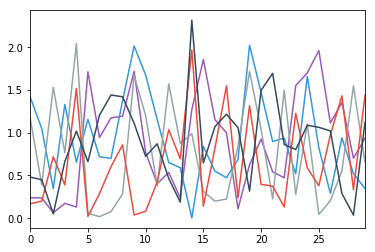

In [179]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(np.split(
    ary=pred_list[norm_test_example_index]["X_time_abs_recon_err"].flatten(),
    indices_or_sections=len(arguments["feat_names"]),
    axis=0)):
  sns.tsplot(arr, color = flatui[i%len(flatui)])

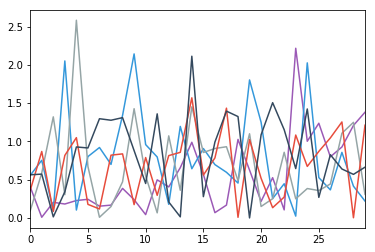

In [181]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(np.split(
    ary=pred_list[norm_test_example_index]["X_feat_abs_recon_err"].flatten(),
    indices_or_sections=len(arguments["feat_names"]),
    axis=0)):
  sns.tsplot(arr, color = flatui[i%len(flatui)])

### Anomalous Example

In [182]:
anom_test_example_index = np.argmax(arr_test_labels=='1')

In [183]:
pred_list[anom_test_example_index]

{'X_feat_abs_recon_err': array([[2.20091636e-01, 4.89022475e-01, 4.80802955e-01, 5.28501440e-02,
         6.59545666e-02],
        [6.11578846e-01, 2.17320564e-01, 3.42855452e-01, 1.13763413e-01,
         5.10599636e-01],
        [1.40502485e+00, 3.20028084e-01, 1.10879740e-01, 1.51722790e+00,
         2.35790609e+00],
        [1.09457012e+00, 6.53823461e-02, 5.27684428e-01, 5.51594081e-02,
         8.39880825e-01],
        [2.07326668e+00, 3.04992047e-01, 1.23865855e+00, 3.25651192e+00,
         2.56814724e+00],
        [2.95969479e+00, 7.98420887e-01, 1.57168229e+00, 1.19865531e-01,
         3.32933252e+00],
        [2.72137530e+00, 9.87531010e-01, 1.01988877e+00, 3.39803337e+00,
         2.65179295e+00],
        [4.72654250e+00, 8.58142045e-01, 1.96423862e+00, 2.60554483e-01,
         4.01787101e+00],
        [1.71581273e+00, 2.03533444e-01, 4.19354836e-01, 1.74875933e+00,
         6.72350321e-01],
        [5.41606747e+00, 4.25023768e-01, 2.50377172e+00, 1.24692571e+00,
         5.4

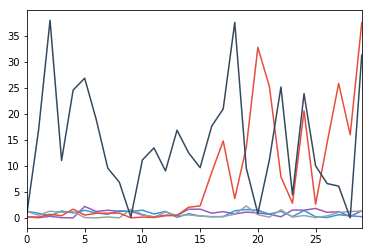

In [184]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(np.split(
    ary=pred_list[anom_test_example_index]["X_time_abs_recon_err"].flatten(),
    indices_or_sections=len(arguments["feat_names"]),
    axis=0)):
  sns.tsplot(arr, color = flatui[i%len(flatui)])

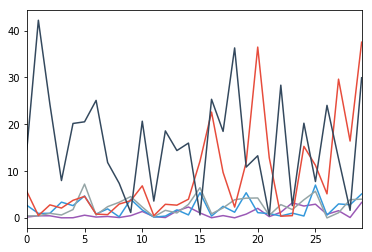

In [185]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(np.split(
    ary=pred_list[anom_test_example_index]["X_feat_abs_recon_err"].flatten(),
    indices_or_sections=len(arguments["feat_names"]),
    axis=0)):
  sns.tsplot(arr, color = flatui[i%len(flatui)])